## Data Exploration to Predict Gallery Tier
### First step towards building an objective Gallery Qualification Score
**Author: Nicholas Sewitz  
Contributors: Anil Bawa-Cavia, Will Goldstein**

This notebook processes certain predetermined features that we believe are predictive of the qualitative gallery tier score applied by the GFI team. The goal is to identify what features and models should be used to build a more ambitious objective qualification score.

In [71]:
import sys, os
import datetime
sys.path.append(os.environ['minotaur'])

import os.path
import http
import urllib.request 
from urllib.request import urlopen
from bs4 import BeautifulSoup
from socket import timeout
import boto3
import gzip
import io


from __future__ import print_function

from pprint import pprint
from time import time
import logging


import yaml

%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 14,3

from dbs import redshift
redshift.connect()

from __future__ import division

from pygeocoder import Geocoder
from geopy.distance import vincenty

from slugify import slugify

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, SGDClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from gensim.models import doc2vec
from collections import namedtuple


#### Locations from Bearden (In Progress)

In [72]:
bearden_locations = redshift.execute("""
SELECT website AS "domain",
       latitude,
       longitude
FROM bearden_exports.organizations
WHERE latitude IS NOT NULL and latitude != 0""")

#### Artsy Partners

In [73]:
partners = redshift.execute("""
SELECT website as "domain"
FROM gravity.partners
where website is not null
""")

#### Artsy Partners with Artists

In [74]:
partner_artists = redshift.execute("""
SELECT 
       p.website AS "domain",
       a.slug AS artist_slug
FROM gravity.partners p
  LEFT JOIN gravity.partner_artists pa ON p.id = pa.partner_id
  LEFT JOIN gravity.artists a ON pa.artist_id = a.id
  """)

#### Artist Bids and Inquiries on Artsy

In [75]:
artsy_artists = redshift.execute("""
SELECT artists.slug AS artist_slug,
       COUNT(DISTINCT inquiry_requests.inquiry_id ) AS "inquiry_requests_count",
       SUM(sale_artworks.artsy_bid_count) AS "bid_count"
FROM gravity.artists
  LEFT JOIN analytics.artworks ON artworks.artist_id = artists.id
  LEFT JOIN analytics.inquiry_requests AS inquiry_requests
         ON artworks.id = inquiry_requests.inquireable_id
        AND inquiry_requests.inquireable_type = 'Artwork'
  LEFT JOIN analytics.sale_artworks ON sale_artworks.artwork_id = artworks.id
GROUP BY 1
""")

#### Gallery Tier (From Salesforce)

In [76]:
salesforce_partners = redshift.execute("""
SELECT website as domain,
       gallery_tier
FROM analytics.salesforce_companies
WHERE website is not null and website != '' and gallery_tier is not null and gallery_tier != '' and "type" IN ('Gallery','Design Gallery')
""")

#### No Longer in Business

In [77]:
closed = redshift.execute("""
SELECT sc.website as domain,disqualified_reason
FROM analytics.salesforce_companies sc
WHERE sc."type" IN ('Gallery', 'Design Gallery')
AND sc.website IS NOT NULL
""")

In [78]:
redshift.close()

#### Bearden Artists Rosters

In [79]:
artists = pd.read_csv('artist_rosters.csv',index_col='domain')

In [80]:
artist_rosters = artists[['notes']].copy()
artist_rosters['has_roster'] = np.where(artist_rosters['notes'] == 'No Artist Roster', False, True)
artist_rosters['domain'] = artist_rosters.index
del artist_rosters['notes']

In [81]:
del artists['organization_type']
del artists['notes']
del artists['specialization']
del artists['updated_website']
del artists['roster_url']
del artists['roster_type']

#### Artsy Artist Page Search Metrics

In [82]:
search = pd.read_csv('artist_search_analytics.csv')

In [83]:
del search['CTR']
del search['Position']

#### Artist Keyword Search Volume

In [84]:
search_volume = pd.read_csv('artist-organic-search-volume.csv')

#### Begin Wrangling

In [85]:
bearden_artists = artists.iloc[:,2:].copy()

In [86]:
bearden_artists = pd.DataFrame(bearden_artists.unstack().dropna()).reset_index()

In [87]:
bearden_artists['artist_slug'] = bearden_artists[0].apply(lambda x: slugify(x))
bearden_artists['source'] = 'bearden'

In [88]:
search_volume['artist_slug'] = search_volume['Keyword'].apply(lambda x: str(x))
search_volume['artist_slug'] = search_volume['artist_slug'].apply(lambda x: slugify(x))
del search_volume['Keyword']

In [89]:
import re

def strip_domain(website):
    website = website.replace("http://","")
    website = website.replace("http:","")    
    website = website.replace("https://","") 
    website = website.replace("http:","")    
    website = re.sub(r'(www.)(?!com)',r'',website)
    urls = website.split('/')[0]
    urls = urls.replace("]","")
    urls = urls.replace("[","")
    urls = urls.strip('.')
    return urls
bearden_artists.domain = bearden_artists.domain.apply(strip_domain)
salesforce_partners.domain = salesforce_partners.domain.apply(strip_domain)
partners.domain = partners.domain.apply(strip_domain)
closed.domain = closed.domain.apply(strip_domain)
artist_rosters.domain = artist_rosters.domain.apply(strip_domain)

In [90]:
bearden_artists = bearden_artists[['domain','artist_slug','source']].copy()
bearden_artists = bearden_artists.drop_duplicates(subset=['domain','artist_slug'], keep='last')
artist_rosters = artist_rosters.drop_duplicates('domain')
closed = closed.drop_duplicates('domain')

In [91]:
partner_artists.domain = partner_artists.domain.astype(str)
partner_artists.domain = partner_artists.domain.apply(strip_domain)
partner_artists['source'] = 'partners'

In [92]:
print(partner_artists.shape)
print(bearden_artists.shape)

(189928, 3)
(185016, 3)


In [93]:
all_artists = pd.concat([bearden_artists, partner_artists])

In [94]:
all_artists = all_artists.drop_duplicates(subset=['domain','artist_slug'], keep='last')

In [95]:
artsy_artists = artsy_artists.dropna()

In [96]:
all_artists['on_artsy'] = all_artists.artist_slug.isin(artsy_artists.artist_slug)

In [97]:
search['artist_slug'] = search.Pages.apply(lambda x: re.split('\\/artist/\\b',x)[-1])
del search['Pages']

In [98]:
artists_with_search = all_artists.merge(search, how="left", left_on='artist_slug', right_on='artist_slug')

In [99]:
# There are 10k artists with search volume that match with the partner artists dataset

test = artists_with_search.merge(search_volume, how="inner", left_on='artist_slug', right_on='artist_slug')
test.drop_duplicates('artist_slug').shape

(10328, 7)

In [100]:
artists_with_search = artists_with_search.merge(search_volume, how="left", left_on='artist_slug', right_on='artist_slug')

In [101]:
artists_with_search_bids_inquiries = artists_with_search.merge(artsy_artists, how="left", left_on='artist_slug', right_on='artist_slug')

In [102]:
# artists_with_search_bids_inquiries.domain = artists_with_search_bids_inquiries.domain.str.strip('.') 
# salesforce_partners.domain = salesforce_partners.domain.str.strip('.')

In [103]:
domains_with_metrics = artists_with_search_bids_inquiries[['domain','Clicks','Impressions','inquiry_requests_count','bid_count','on_artsy','search_volume']].groupby('domain').sum()

In [104]:
slug_count = pd.DataFrame(artists_with_search_bids_inquiries[['domain','artist_slug']].groupby('domain').count())
domains_with_metrics = domains_with_metrics.merge(slug_count, how="left", left_index=True, right_index=True)
salesforce_partners = salesforce_partners.drop_duplicates('domain')

In [105]:
domains_with_metrics_and_demographic = salesforce_partners.merge(domains_with_metrics, how="left", left_on="domain",right_index=True)
domains_with_metrics_and_demographic = domains_with_metrics_and_demographic.fillna(np.nan)


#### Minimum Distance to Art City

In [106]:
bearden_locations.domain = bearden_locations.domain.apply(strip_domain)
bearden_locations = bearden_locations.drop_duplicates('domain')

In [107]:
domain_locations = bearden_locations[['domain','latitude','longitude']].copy()

domain_locations['lat_long'] = list(zip(domain_locations.latitude, domain_locations.longitude))
del domain_locations['latitude']
del domain_locations['longitude']


In [108]:
ny = (40.7465, 74.0014)
london = (51.4851, 0.1749)
los_angeles = (34.0900, 118.3617)
paris = (48.8587, 2.3588)
berlin = (52.5194, 13.4067)
hong_kong = (22.3964, 114.1095)
miami = (25.7617, 80.1918)
venice = (45.4408, 12.3155)
basel = (47.5596, 7.5886)
sao_paulo = (23.5505, 46.6333)
melbourne = (37.8136, 144.9631)
mexico_city = (19.4326, 99.1332)

In [109]:
domain_locations['distance_to_ny'] = domain_locations.lat_long.apply(lambda x: vincenty(x, ny).miles)
domain_locations['distance_to_london'] = domain_locations.lat_long.apply(lambda x: vincenty(x, london).miles)
domain_locations['distance_to_los_angeles'] = domain_locations.lat_long.apply(lambda x: vincenty(x, los_angeles).miles)
domain_locations['distance_to_paris'] = domain_locations.lat_long.apply(lambda x: vincenty(x, paris).miles)
domain_locations['distance_to_berlin'] = domain_locations.lat_long.apply(lambda x: vincenty(x, berlin).miles)
domain_locations['distance_to_hong_kong'] = domain_locations.lat_long.apply(lambda x: vincenty(x, hong_kong).miles)
domain_locations['distance_to_miami'] = domain_locations.lat_long.apply(lambda x: vincenty(x, miami).miles)
domain_locations['distance_to_venice'] = domain_locations.lat_long.apply(lambda x: vincenty(x, venice).miles)
domain_locations['distance_to_basel'] = domain_locations.lat_long.apply(lambda x: vincenty(x, basel).miles)
domain_locations['distance_to_sao_paulo'] = domain_locations.lat_long.apply(lambda x: vincenty(x, sao_paulo).miles)
domain_locations['distance_to_melbourne'] = domain_locations.lat_long.apply(lambda x: vincenty(x, melbourne).miles)
domain_locations['distance_to_mexico_city'] = domain_locations.lat_long.apply(lambda x: vincenty(x, mexico_city).miles)

In [110]:
distance_columns = [col for col in domain_locations if col.startswith('distance_to_')]
domain_locations['min_distance_to_art_city'] = domain_locations[distance_columns].min(axis=1)
galleries_w_demographic_metric_location = domains_with_metrics_and_demographic.merge(domain_locations[['domain','min_distance_to_art_city']], how="left", left_on="domain",right_on="domain")
galleries_w_demographic_metric_location = galleries_w_demographic_metric_location.merge(artist_rosters, how="left", left_on="domain",right_on="domain")
galleries_w_demographic_metric_location = galleries_w_demographic_metric_location.merge(closed,how="left",left_on="domain",right_on="domain")
galleries_w_demographic_metric_location['is_closed'] = np.where(galleries_w_demographic_metric_location['disqualified_reason'] == 'No Longer in Business', True, False)
galleries_open_w_all_metrics = galleries_w_demographic_metric_location[galleries_w_demographic_metric_location['is_closed'] == False].copy()

In [111]:
# getting pretty good coverage using slug matching method 
# *note not every domain has an artist_slug_count

galleries_open_w_all_metrics.count()

domain                      18374
gallery_tier                18374
Clicks                       2842
Impressions                  2842
inquiry_requests_count       4405
bid_count                    4405
on_artsy                     7750
search_volume                5022
artist_slug                  7750
min_distance_to_art_city     5648
has_roster                   4822
disqualified_reason          2232
is_closed                   18374
dtype: int64

#### Limit DF to only include galleries with minimum # of features

In [112]:
# limit dataframe to only galleries that have a tier and at least 3 features

df = galleries_open_w_all_metrics.copy()
df_with_many_features= df[(df.gallery_tier.notnull()) & (df.min_distance_to_art_city.notnull()) & (df.has_roster.notnull())]
df_with_less_features = df[(df.gallery_tier.notnull())]


partners['partner_on_artsy'] = True
partners = partners.drop_duplicates('domain')




In [113]:
# 1250 galleries have most of the features and are not on artsy, with tier

df_with_less_features = df_with_less_features.merge(partners,how="left",left_on="domain",right_on="domain").copy()
df_with_less_features.partner_on_artsy = df_with_less_features.partner_on_artsy.fillna(False)

df_with_many_features = df_with_many_features.merge(partners,how="left",left_on="domain",right_on="domain").copy()
df_with_many_features.partner_on_artsy = df_with_many_features.partner_on_artsy.fillna(False)

In [114]:
def qualify(x):
    if x == '1':
        return "very_qualified"
    elif x == '2':
        return "very_qualified"
    elif x == '3':
        return "very_qualified"
    elif x == '4':
        return "qualified"
    elif x == '5':
        return "not_qualified"
    
def numeralize(x):
    if x == '1':
        return 100
    elif x == '2':
        return 100
    elif x == '3':
        return 100
    elif x == '4':
        return 50
    elif x == '5':
        return 0
    
df_with_many_features['qualified'] = df_with_many_features.gallery_tier.apply(lambda x: qualify(x))
df_with_less_features['qualified'] = df_with_less_features.gallery_tier.apply(lambda x: qualify(x))

df_with_many_features.gallery_tier = df_with_many_features.gallery_tier.apply(lambda x: numeralize(x))
df_with_less_features.gallery_tier = df_with_less_features.gallery_tier.apply(lambda x: numeralize(x))


In [115]:
if sys.version_info[0] < 3: 
    from StringIO import StringIO # Python 2.x
else:
    from io import StringIO # Python 3.x

# get your credentials from environment variables
aws_id = os.environ['AWS_ID']
aws_secret = os.environ['AWS_SECRET']

s3 = boto3.client('s3', aws_access_key_id=aws_id,
        aws_secret_access_key=aws_secret)

bucket_name = 'artsy-data'


In [116]:
object_key = 'temp/many_text.csv.gz'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

many_text = pd.read_csv(StringIO(csv_string))

In [117]:
object_key = 'temp/less_text.csv.gz'
csv_obj = s3.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

less_text = pd.read_csv(StringIO(csv_string))

In [118]:
df_with_many_text = df_with_many_features.merge(many_text,how='left',left_on='domain',right_on='domain')
df_with_less_text = df_with_less_features.merge(less_text,how='left',left_on='domain',right_on='domain')

del df_with_many_text['Unnamed: 0']
del df_with_less_text['Unnamed: 0']

In [120]:
csv_buffer = io.StringIO()
df_with_many_text.to_csv(csv_buffer, index=False)

csv_buffer.seek(0)

with open(csv_buffer.getvalue(), 'rb') as data:
    s3.upload_fileobj(data, bucket_name, 'temp/df_with_many_text.csv.gz')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
csv_buffer = io.StringIO()
df_with_less_text.to_csv(csv_buffer, index=False)

csv_buffer.seek(0)

with open(csv_buffer.getvalue(), 'rb') as data:
    s3.upload_fileobj(data, bucket_name, 'temp/df_with_less_text.csv.gz')

#### Data Exploration

In [54]:
df = df_with_less_features[df_with_less_features.is_closed == False].copy()
df.reset_index(inplace=True,drop=True)

str_cols = ['Clicks','Impressions','inquiry_requests_count','bid_count','on_artsy','artist_slug','search_volume']
df[str_cols] = df[str_cols].fillna(0)

In [55]:
df.groupby(['qualified','has_roster']).count()

domain  gallery_tier  Clicks  Impressions  \
qualified      has_roster                                              
not_qualified  False          231           231     231          231   
               True           894           894     894          894   
qualified      False          347           347     347          347   
               True          3009          3009    3009         3009   
very_qualified False           22            22      22           22   
               True           319           319     319          319   

                           inquiry_requests_count  bid_count  on_artsy  \
qualified      has_roster                                                
not_qualified  False                          231        231       231   
               True                           894        894       894   
qualified      False                          347        347       347   
               True                          3009       3009      3009   
very_qualified False                           22         22        22   
               True                           319        319       319   

                           search_volume  artist_slug  \
qualified      has_roster                               
not_qualified  False                 231          231   
               True                  894          894   
qualified      False                 347          347   
               True                 3009         3009   
very_qualified False                  22           22   
               True                  319          319   

                           min_distance_to_art_city  disqualified_reason  \
qualified      has_roster                                                  
not_qualified  False                             72                  185   
               True                             289                  602   
qualified      False                            105                    3   
               True                             958                    7   
very_qualified False                              7                    0   
               True                             156                    1   

                           is_closed  partner_on_artsy  
qualified      has_roster                               
not_qualified  False             231               231  
               True              894               894  
qualified      False             347               347  
               True             3009              3009  
very_qualified False              22                22  
               True              319               319

In [56]:
del df['domain']
del df['qualified']
del df['disqualified_reason']
del df['is_closed']
del df['Clicks']
del df['Impressions']
df = df.dropna()

In [57]:
df.columns

Index(['gallery_tier', 'inquiry_requests_count', 'bid_count', 'on_artsy',
       'search_volume', 'artist_slug', 'min_distance_to_art_city',
       'has_roster', 'partner_on_artsy'],
      dtype='object')

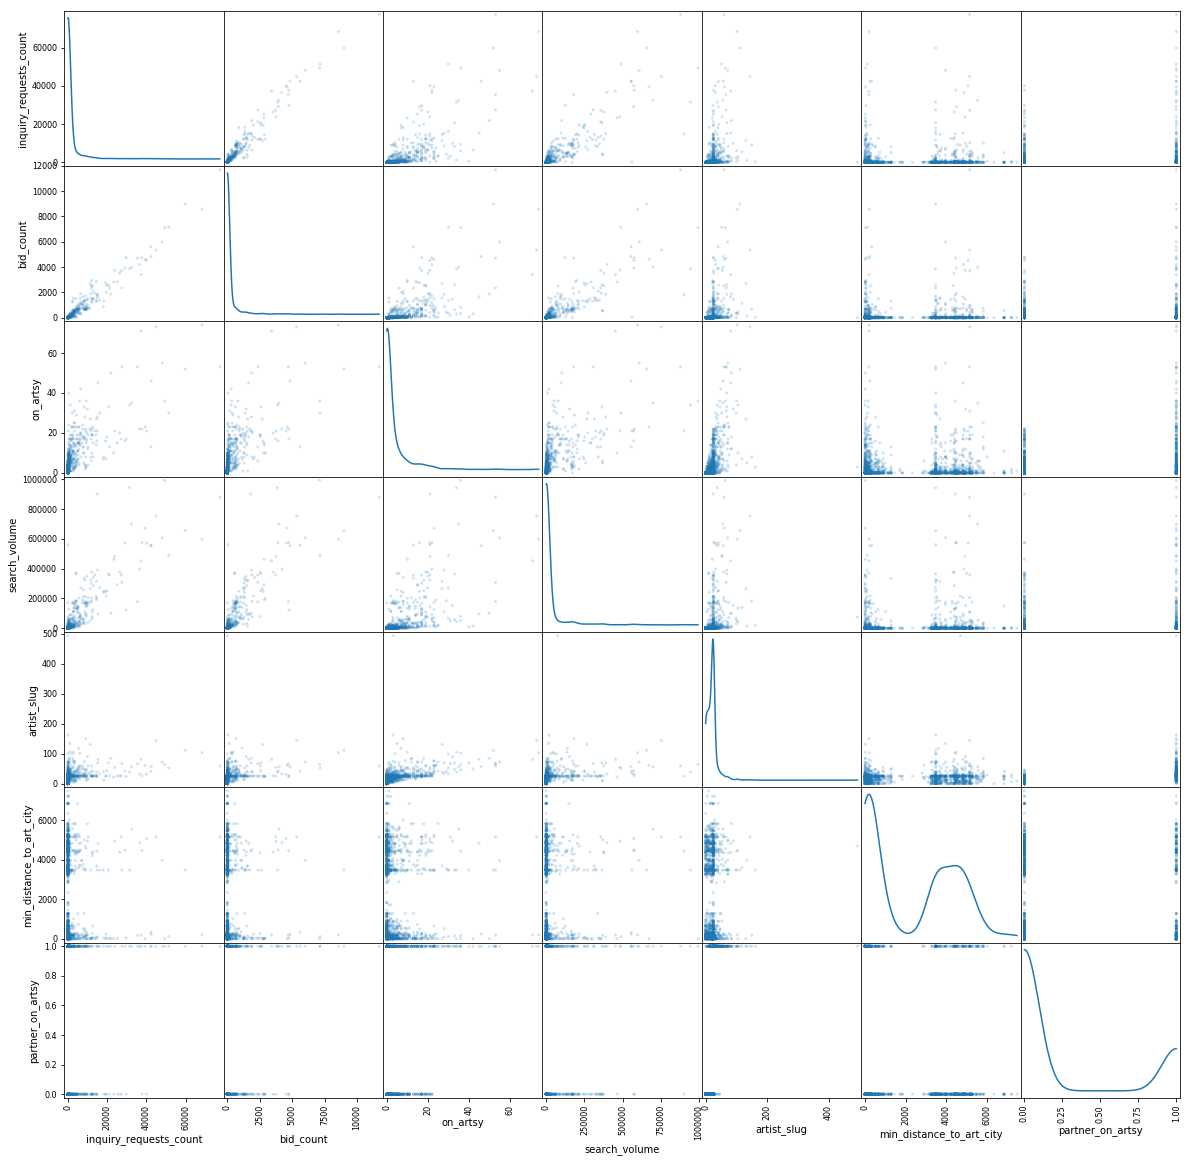

In [58]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')
plt.show()

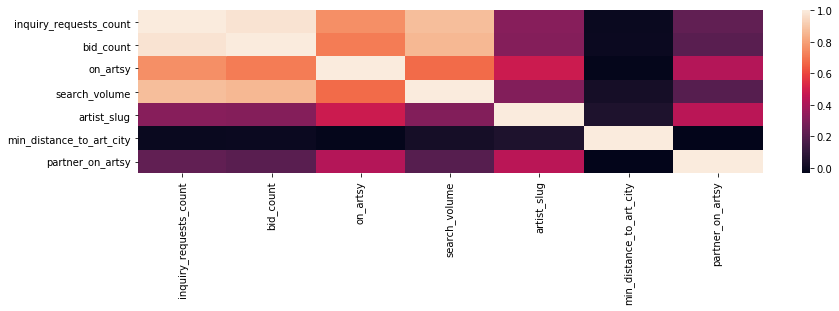

In [59]:
#looks like we might be getting skewed data for galleries that have a lot of artists on artsy. 
#Can we assume these are also galleries on Artsy?
corr = df.corr()

sns.heatmap(corr)


In [60]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,inquiry_requests_count,bid_count,on_artsy,search_volume,artist_slug,min_distance_to_art_city,partner_on_artsy
inquiry_requests_count,1,0.98,0.76,0.88,0.32,-0.0082,0.23
bid_count,0.98,1,0.71,0.86,0.31,-0.0048,0.2
on_artsy,0.76,0.71,1,0.68,0.48,-0.025,0.42
search_volume,0.88,0.86,0.68,1,0.31,0.024,0.19
artist_slug,0.32,0.31,0.48,0.31,1,0.048,0.44
min_distance_to_art_city,-0.0082,-0.0048,-0.025,0.024,0.048,1,-0.036
partner_on_artsy,0.23,0.2,0.42,0.19,0.44,-0.036,1


#### Unsupervised Learning Exploration

In [61]:
df.dropna().shape, df.shape

((1587, 9), (1587, 9))

In [62]:
df.groupby('gallery_tier').count()

,inquiry_requests_count,bid_count,on_artsy,search_volume,artist_slug,min_distance_to_art_city,has_roster,partner_on_artsy
gallery_tier,,,,,,,,
1,17,17,17,17,17,17,17,17
2,27,27,27,27,27,27,27,27
3,119,119,119,119,119,119,119,119
4,1063,1063,1063,1063,1063,1063,1063,1063
5,361,361,361,361,361,361,361,361


In [63]:


X = df.dropna()
X = X.values

In [64]:
np.percentile(df.Impressions, range(0,100,5))

AttributeError: 'DataFrame' object has no attribute 'Impressions'

In [66]:
for col in df.columns:
    
    print(col, df[col].max() / df.Clicks.std())

AttributeError: 'DataFrame' object has no attribute 'Clicks'

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


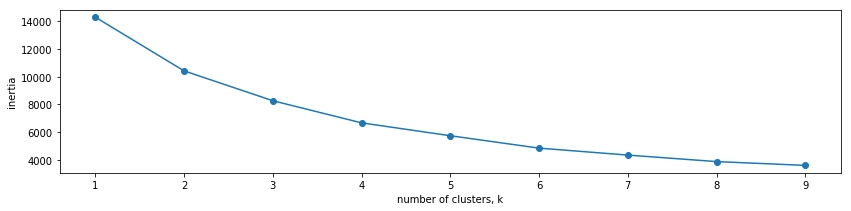

In [67]:
ks = range(1, 10)
inertias = []

scaler = StandardScaler()
X = scaler.fit_transform(X)
    
for k in ks:
    # Create scaler: scaler


    # Create KMeans instance: kmeans
    kmeans = KMeans(n_clusters=k)

    # Create pipeline: pipeline
    
    # Fit model to samples
    kmeans.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()



In [68]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=3)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to samples
pipeline.fit(X)

# Calculate the cluster labels: labels
labels = pipeline.predict(X)

# Create a DataFrame with labels and tier as columns: df
dfl = pd.DataFrame({'labels': labels, 'tier': y})

# Create crosstab: ct
ct = pd.crosstab(dfl['labels'], df['tier'])

# Display ct
print(ct)


NameError: name 'y' is not defined

In [69]:
# average of every feature for each clsuter, concat and group by avrage
# may need to visualize feature by feature
df.shape, 

model = KMeans(n_clusters=3)

# Fit model to samples
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

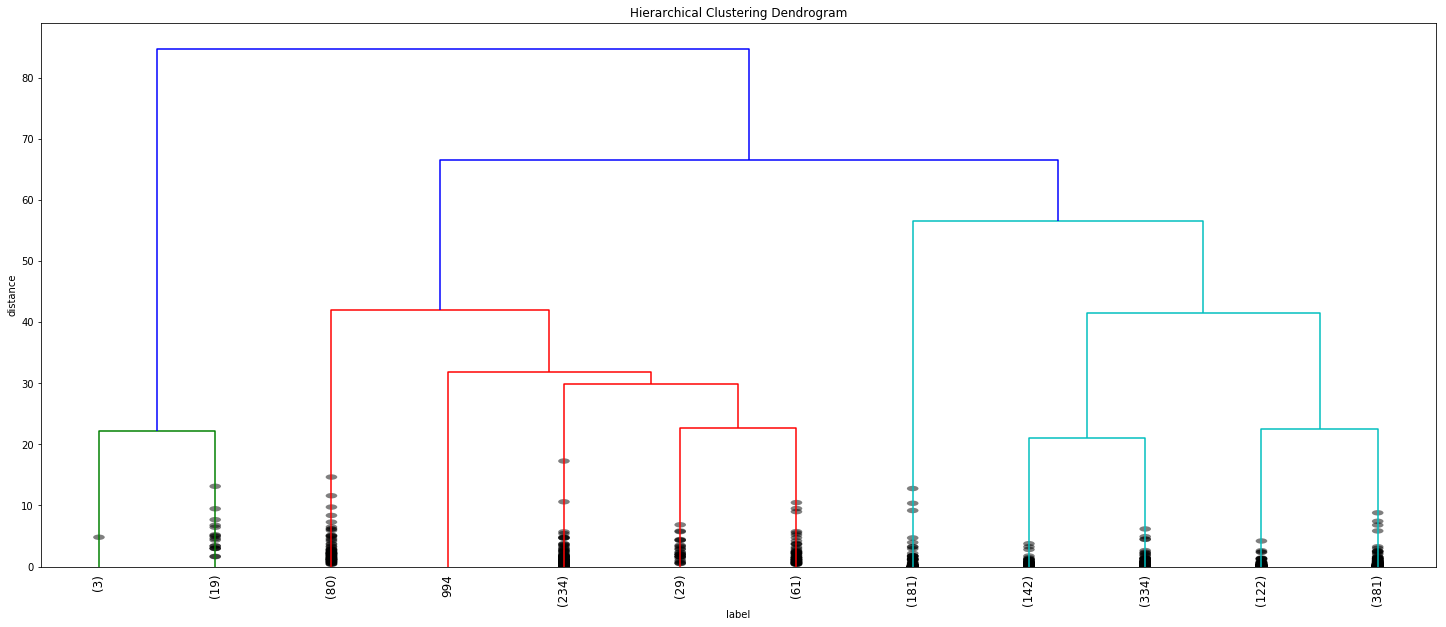

In [70]:
import sys
sys.setrecursionlimit(10000)

# Calculate the linkage: mergings
mergings = linkage(X, method='ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('label')
plt.ylabel('distance')

max_d = .6

# Plot the dendrogram, using varieties as labels
dendrogram(mergings,
           truncate_mode='lastp',  # show only the last p merged clusters
           p=12,  # show only the last p merged clusters
           show_leaf_counts=True,  # otherwise numbers in brackets are counts
           leaf_rotation=90.,
           leaf_font_size=12.,
           show_contracted=True,  # to get a distribution impression in truncated branches
#            annotate_above=.4,
#            max_d=max_d
        )
plt.show()

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


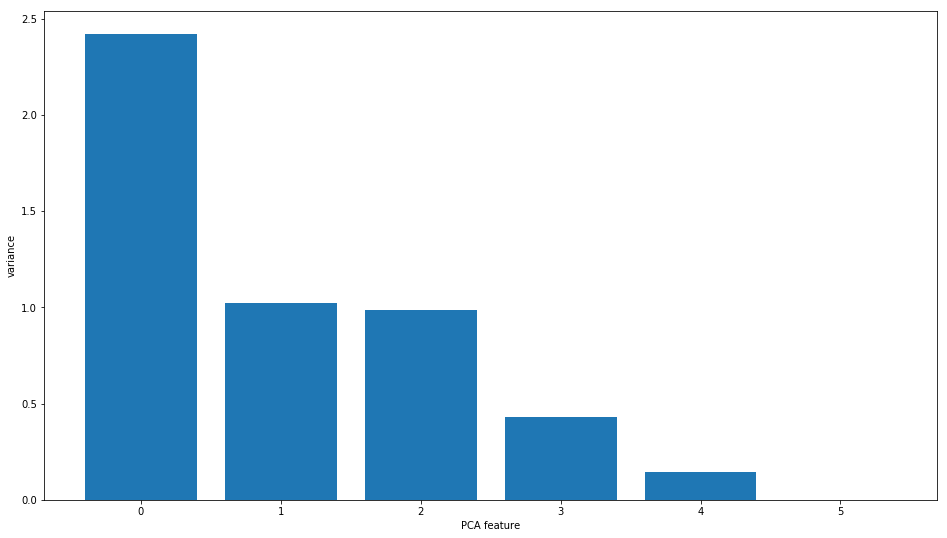

(18355, 2)


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [135]:
# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to 'samples'
pipeline.fit(X)



# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


pca = PCA(n_components=2)

pipeline = make_pipeline(scaler, pca)

# Fit the PCA instance to the scaled samples
pipeline.fit(X)

# Transform the scaled samples: pca_features
pca_features = pipeline.transform(X)

# Print the shape of pca_features
print(pca_features.shape)


In [ ]:
# would run pca features through supervised learning. black box, but works well possibly in terms of prediction

#### URL Scrape for Keywords

In [ ]:
# http://jmausolf.github.io/code/Analyzing_Text_in_Python/#analyzing_text_in_python

In [586]:
# url_keywords = ["about", "fairs", "exhibitions", "artists", "home"]

# def site_text(url):
#     try:
#         sub_urls = []
#         url_full = "http://www."+ str(url).strip()
#         print(url_full)
#         page = urlopen(url_full, timeout=8)
#         soup = BeautifulSoup(page, "html.parser")
#         links = soup.find_all('a', href=True)
#         links = [link['href'] for link in links]
#         lower_links = [x.lower() for x in links]
#         link_dict = dict(zip(links, lower_links))
#         sub_urls = [k for k, v in link_dict.items() if any(xs in v for xs in url_keywords)  ]
#         sub_urls = list(set(sub_urls))
#         raw = soup.get_text()
#         num = 0
        
#         for sub_url in sub_urls:
#             try:
#                 if "http" in sub_url:
#                     sub_url
#                     if sub_url.count("/") > 3:
#                         break
#                 elif url_full.endswith("/"):
#                     sub_url = url_full + sub_url
#                     if sub_url.count("/") > 3:
#                         break
#                 else:
#                     if sub_url.startswith("/"):
#                         sub_url = url_full + sub_url
#                         if sub_url.count("/") > 3:
#                             break
#                     else:
#                         sub_url = url_full + "/" + sub_url
#                         if sub_url.count("/") > 3:
#                             break
#                 print("sub_url: " + sub_url)
#                 sub_page = urlopen(sub_url, timeout=8)
#                 sub_soup = BeautifulSoup(sub_page, "html.parser")
#                 raw += sub_soup.get_text()
#                 num = num + 1
#                 if num == 5:
#                     break
                    
#             except urllib.error.URLError as e:
#                 if hasattr(e, 'reason'): # <--
#                     print('We failed to reach a server.')
#                     print('Reason: ', e.reason)
#                 elif hasattr(e, 'code'): # <--
#                     print('The server couldn\'t fulfill the request.')
#                     print('Error code: ', e.code)
#             except http.client.HTTPException as e:
#                 if hasattr(e, 'reason'): # <--
#                     print('We failed to reach a server.')
#                     print('Reason: ', e.reason)
#                 elif hasattr(e, 'code'): # <--
#                     print('The server couldn\'t fulfill the request.')
#                     print('Error code: ', e.code)      
#             except timeout:
#                 print("timeout")
#             except KeyboardInterrupt:
#                 raise
#             except: 
#                 print("unknown")
                
#         return raw
    
#     except urllib.error.URLError as e:
#         if hasattr(e, 'reason'): # <--
#             print('We failed to reach a server.')
#             print('Reason: ', e.reason)
#         elif hasattr(e, 'code'): # <--
#             print('The server couldn\'t fulfill the request.')
#             print('Error code: ', e.code)
#     except http.client.HTTPException as e:
#         if hasattr(e, 'reason'): # <--
#             print('We failed to reach a server.')
#             print('Reason: ', e.reason)
#         elif hasattr(e, 'code'): # <--
#             print('The server couldn\'t fulfill the request.')
#             print('Error code: ', e.code)
#     except timeout:
#         print("timeout")        
#     except KeyboardInterrupt:
#         raise
#     except: 
#         print("unknown")    
    
    



In [587]:
# df_with_many_features['text_parse'] = df_with_many_features[df_with_many_features.domain.str.len() > 2].domain.apply(lambda x: site_text(x))
# df_with_many_features.to_csv('df_with_many_features.csv')


In [588]:
# df_with_less_features['text_parse'] = df_with_less_features[df_with_less_features.domain.str.len() > 2].domain.apply(lambda x: site_text(x))
# df_with_less_features.to_csv('df_with_less_features.csv')


http://www.tuttiart.ch
http://www.localedue.it
http://www.galleriazabert.com
http://www.5begallery.com
sub_url: http://www.5begallery.com/home.html
http://www.besleysbooks.com
sub_url: http://www.besleysbooks.com/fairs.html
http://www.collect-arts.com
We failed to reach a server.
Reason:  Forbidden
http://www.theartistsundertaking.com
sub_url: http://theartistsundertaking.us7.list-manage.com/subscribe?u=99c9febb6dfd11b69a8866eba&id=e3e51be6a2
sub_url: http://www.theartistsundertaking.com/about.htm
http://www.galeria-piekary.com.pl
timeout
http://www.galeriebar.ch
http://www.libbyedwardsgalleries.com
sub_url: http://www.libbyedwardsgalleries.com/AboutUs.aspx
http://www.odl-art.ru
http://www.tbwbooks.com
http://www.estamp-art.com
http://www.frideslameris.nl
http://www.slap-boutique.com
http://www.covagallery.nl
http://www.galleriaildiaframma.it
http://www.fullcirclestudio.com.au
http://www.morrinsvillegallery.org.nz
sub_url: http://www.morrinsvillegallery.org.nz/about.php
http://www.bret

We failed to reach a server.
Reason:  timed out
http://www.artprojectstaffelbach.ch
http://www.galerieinsideout.com
http://www.mege.fr
We failed to reach a server.
Reason:  Internal Server Error
http://www.hofmanstudios.com
http://www.patriciacamerongallery.com
http://www.italian-paintings.com
sub_url: http://www.italian-paintings.com/About
http://www.tncgallery.com
http://www.the-kgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.adelsongalleriesboston.com
http://www.phyllissteinart.com
http://www.boss-design.co.uk
http://www.nomad-artgallery.com
http://www.premiercollectionsltd.com
http://www.stricklandartgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.karinsanders.com
sub_url: http://www.karinsanders.com/about.html
sub_url: http://www.karinsanders.com/exhibitions.html
sub_url: http://www.karinsanders.com/artists.html
http://www.galerie-francaise.de
sub_url: http://www.galerie-francaise.de/Home.h

http://www.galleryno15.com
We failed to reach a server.
Reason:  Bad Request
http://www.galerielouisgendre.com
http://www.behmgalleriesla.com
sub_url: http://www.behmgalleriesla.com/about.html
http://www.etheringtonfineart.com
http://www.nancydoddsgallery.com
http://www.staeck.de
http://www.afrikanagallery.com.au
http://www.artinfo.com
sub_url: http://www.artinfo.com/galleryguide-artists
http://www.aliceday.be
http://www.moymackaygallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.alain-lecomte.net
We failed to reach a server.
Reason:  Forbidden
http://www.turkalyart.com
http://www.sabbatiqueltd.com
sub_url: http://www.sabbatiqueltd.com/about_artists.htm
sub_url: http://www.sabbatiqueltd.com/about.htm
http://www.susaneisen.com
http://www.art1274hollis.ca
sub_url: http://www.art1274hollis.ca/artists.html
sub_url: http://www.art1274hollis.ca/about.html
http://www.krikoart.com
sub_url: http://www.krikoart.com/about.php?ps=93
sub_url: http://www.krikoart.com/about.php?ps

http://www.themovingart.it
http://www.art-meta.com
sub_url: http://www.art-meta.com/meet-our-artists.html
http://www.galerie-westend.de
http://www.stevenkasher.com
sub_url: http://www.stevenkasher.com/exhibitions
sub_url: http://www.stevenkasher.com/artists
sub_url: http://www.stevenkasher.com/#homepage-news
http://www.floridamininggallery.com
http://www.redhooklabs.com
http://www.milfordgalleries.co.nz
http://www.tftmmelrose.com
http://www.galeriebesch.de
http://www.essexstudios.com
http://www.finerthingsgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.bethswanstrom.com
http://www.galleryrevisited.com
http://www.bilder-im-hof.de
http://www.50pennplacegallery.com
sub_url: http://www.50pennplacegallery.com/artists.htm
http://www.flaneur.sg
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.copticartstudio.com
We failed to reach a server.
Reason:  Forbidden
http://www.walker-poinsett.com
http://www.orinocogallery.

http://www.rosamundfelsen.com
sub_url: http://www.rosamundfelsen.com/exhibitions
sub_url: http://www.rosamundfelsen.com/artists
http://www.patrickheide.com
http://www.gebertcontemporary.com
http://www.block336.com
http://www.tilloufineart.com
sub_url: http://www.tilloufineart.com/exhibitions
http://www.galleriarnstedt.se
http://www.coastalcreationsart.com
http://www.joaogallery.com
http://www.andyjllien.ch
sub_url: javascript:(function() {window.open('http://twitter.com/home?status=' + encodeURIComponent(document.location.href)); return void(0);})();
We failed to reach a server.
Reason:  unknown url type: javascript
http://www.petrarinckgalerie.de
http://www.denisecadegallery.com
sub_url: http://www.denisecadegallery.com/artists.php
sub_url: http://www.denisecadegallery.com/aboutus.php
http://www.whitesp-cegallery.com
http://www.galeriespas.com
sub_url: http://www.galeriespas.com/artists.asp?id=1
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.galeriespas.com/exhibi

http://www.classic-gallery.ru
http://www.ChinaRedStarGallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.galleryna.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gimpelfils.com
http://www.reddoorgallery.co
http://www.Www.haylettsgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.thinggallery.com
sub_url: http://www.thinggallery.com/home
http://www.dxixprojects.com
sub_url: http://www.dxixprojects.com/about.html
http://www.phyllisweston.com
We failed to reach a server.
Reason:  Not Found
http://www.praterinsel.de
http://www.charlottefineart.com
sub_url: http://www.charlottefineart.com/annual_studio_artistsexhibition_and_sale
sub_url: http://www.charlottefineart.com/special_exhibitions_high_profile
sub_url: http://www.charlottefineart.com/about_the_gallery
http://www.coucou-coucou.com
We failed to reach a server.
Reason:  Forbidden
http://www.so

http://www.antiquitenormandie.com
http://www.bhnyfineart.com
sub_url: http://www.bhnyfineart.com/about
sub_url: http://www.bhnyfineart.com/artists
http://www.casaquien.com
http://www.shackletongallery.com
http://www.mannartgallery.ca
http://www.rhinegoldgallery.de
sub_url: https://www.rhinegoldgallery.de/about
http://www.ht-art.com
http://www.textezurkunst.de
http://www.alt-amerika.de
http://www.lisasharpeca.com
http://www.agalleryfineart.com
sub_url: http://www.agalleryfineart.com/homepage.html
http://www.baltazar.be
http://www.nkgallery.be
http://www.cutterandcutter.com
http://www.elkongallery.com
sub_url: http://www.elkongallery.com/about
sub_url: http://www.elkongallery.com/exhibitions
sub_url: http://www.elkongallery.com/artists
http://www.zweigstelle-berlin.de
http://www.kunstwerk-nippes.de
http://www.pinterest.com
http://www.gallerywoo.kr
http://www.roberthughesgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.est

http://www.ekfineart.com
sub_url: http://www.ekfineart.com/exhibitions
sub_url: http://www.ekfineart.com/artists
http://www.takeninagawa.com
http://www.abmeyerwood.com
sub_url: http://www.abmeyerwood.com/About.cfm
http://www.junekellygallery.com
sub_url: http://www.junekellygallery.com/home.htm
http://www.kunstsalon-franke-schenk.de
http://www.lawrencemarkey.com
http://www.flowersgallery.com
sub_url: https://www.flowersgallery.com/artists
http://www.galeriemitterrand.com
http://www.gwl.art.pl
We failed to reach a server.
Reason:  Forbidden
http://www.galeriethoman.com
http://www.enlaceart.com
We failed to reach a server.
Reason:  Forbidden
http://www.aura.art.br
http://www.the9.99.gt
http://www.lighthouseartscenter.com
unknown
http://www.ch-artspace.com
We failed to reach a server.
Reason:  Forbidden
http://www.galleryeast.com.au
http://www.roemerapotheke.ch
http://www.moving-gallery.com
http://www.dlfineartsgallery.com
http://www.eyewashart.com
http://www.larrywaldenart.com
sub_url: h

sub_url: http://www.scottmilo.com/about-us.html
http://www.wangiartroom.wordpress.com
http://www.maricevicfineart.com
http://www.aidasgalerija.lt
http://www.shottowergallery.com
http://www.speerstra.net
We failed to reach a server.
Reason:  Forbidden
http://www.gallerimovitz.com
http://www.galeriegabel.com
http://www.elizabethdee.com
sub_url: http://www.elizabethdee.com/exhibitions
sub_url: http://www.newsweek.com/new-york-john-giorno-exhibitions-summer-poetry-art-623964
http://www.scheubleinbak.com
sub_url: http://scheubleinbak.com/exhibitions
sub_url: http://scheubleinbak.com/about
http://www.ggibsongallery.com
http://www.arndtberlin.com
http://www.garysnyderart.com
http://www.silviacintra.com.br
sub_url: http://www.silviacintra.com.br/exhibitions
sub_url: http://www.silviacintra.com.br/artists
sub_url: http://www.silviacintra.com.br/fairs
http://www.wholmangallery.com
sub_url: http://www.wholmangallery.com/exhibitions
sub_url: http://www.wholmangallery.com/artists
http://www.galerie

http://www.blankspaceart.com
http://www.weekendgallery.co.uk
http://www.galeriekriegershof.nl
http://www.derusfinearts.com
sub_url: http://www.derusfinearts.com/about.asp
sub_url: http://www.derusfinearts.com/artists.asp
http://www.galeriegosserez.com
http://www.nancyhoffmangallery.com
sub_url: http://www.nancyhoffmangallery.com/exhibitions
sub_url: http://www.nancyhoffmangallery.com/exhibitions
sub_url: http://www.nancyhoffmangallery.com/home
sub_url: http://www.nancyhoffmangallery.com/about
http://www.canadanewyork.com
We failed to reach a server.
Reason:  Forbidden
http://www.akinci.nl
We failed to reach a server.
Reason:  Forbidden
http://www.jacobbjorn.com
http://www.rainbowarts.de
http://www.jamesfreemangallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.colnaghi.com
http://www.espacoelianabenchimol.com.br
timeout
http://www.artistcuratedprojects.com
http://www.44309streetartgallery.net
http://www.etcartgallery.com
http://www.thisisnotclothing.com
http://www.ad

sub_url: http://www.nadenemilnegallery.com/artists
http://www.emc2art.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galleryanasukayama.com
http://www.cardozaartgallery.com
http://www.moana-ari.com
We failed to reach a server.
Reason:  Forbidden
http://www.galeriejanssens.be
http://www.triple-v.fr
sub_url: http://www.triple-v.fr/#home
http://www.galerieloehrl.de
http://www.galeriahispanica.es
http://www.johnnyvanhaeften.com
sub_url: http://www.johnnyvanhaeften.com/exhibitions
http://www.whatpipeline.com
http://www.galerielinlassable.com
http://www.metroquadroarte.com
http://www.bugdahnundkaimer.com
http://www.galicca.com


http://www.digizona.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.satelitegaleria.com
We failed to reach a server.
Reason:  Forbidden
http://www.violarte.com
http://www.morandell.it
http://www.bluefigart.gr
http://www.jgogallery.com
http://www.maronaantiques.com
http://www.dennygallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.manitougalleries.com
http://www.jdcfineart.com
http://www.tashkeel.org
sub_url: http://tashkeel.org/artists
sub_url: http://tashkeel.org/exhibitions
http://www.misashin.com
http://www.artsinthevillage.com
http://www.wazzau.com
http://www.gethercontemporary.com
http://www.echtgallery.com
http://www.asia-flachsmann.com
http://www.brauchbarkeit.de
http://www.vermeerenfineart.com
http://www.asymmetrikinc.com
http://www.baldwingallery.com
sub_url: http://www.baldwingallery.com/artists
http://www.eden-gallery.com
http://www.whistler.com
http://www.paulpetro.com
http://www.en.bafund.cn
We

sub_url: http://www.12x16gallery.com/exhibitions17.html
http://www.joewadefineart.com
sub_url: http://www.joewadefineart.com/artists.shtml
sub_url: http://www.joewadefineart.com/about_us.shtml
http://www.canadianartgallery.com
http://www.artisyou.com
http://www.atelier1505.com
http://www.velvetdavinci.com
http://www.gma-lv.com
sub_url: http://www.gma-lv.com/artists
sub_url: http://www.gma-lv.com/about-us
http://www.coalshedstudios.com
http://www.haganfineart.com
sub_url: http://www.haganfineart.com/About.cfm
sub_url: http://www.haganfineart.com/Artist-Detail.cfm?ArtistsID=1137
sub_url: http://www.haganfineart.com/Artwork-Detail.cfm?ArtistsID=1110&NewID=13038
sub_url: http://www.haganfineart.com/Artwork-Detail.cfm?ArtistsID=1165&NewID=12967
sub_url: http://www.haganfineart.com/Artist-Info.cfm?ArtistsID=1110
http://www.smartcoastgallery.com
http://www.biggercode.com
http://www.attagallery.com
http://www.workstead.com
http://www.darkroomgallery.com
sub_url: http://www.darkroomgallery.com/

sub_url: http://www.bsmt.co.uk/#about-us-blurb
We failed to reach a server.
Reason:  Too Many Requests
http://www.pierrespake.com
http://www.galeriasiboney.com
http://www.egenolfgallery.com
http://www.rumigalleries.com
sub_url: http://www.rumigalleries.com/fairs-exhib.asp
sub_url: http://www.rumigalleries.com/about.asp
sub_url: http://rumigalleries.com/exhibitions.asp
http://www.galeriedowntown.com
http://www.nextlevelgalerie.com
http://www.gallerygodo.com
http://www.356mission.com
http://www.estranydelamota.com
We failed to reach a server.
Reason:  Forbidden
http://www.espacioliquido.com
http://www.artbischoff.com
http://www.cordenpottsgallery.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.artbeatus.com
http://www.abc-arte.com
http://www.charlesisaacs.com
http://www.keragallery.com
sub_url: http://www.keragallery.com/about.html
sub_url: http://www.keragallery.com/exhibitions.html
sub_url: http://www.keragallery.com/art-fairs.html
http://www.le22ruededijon.com
h

http://www.piccadillys.com
sub_url: http://www.piccadillys.com/artists-gallery.html
http://www.galerie-thron.de
http://www.artvest.com
http://www.hohmannfineart.com
sub_url: http://www.hohmannfineart.com/events-exhibitions.php
sub_url: http://www.hohmannfineart.com/artists.php
sub_url: http://www.hohmannfineart.com/past-exhibitions.php
sub_url: http://www.hohmannfineart.com/#carousel-home
sub_url: http://www.hohmannfineart.com/events-art-fairs.php
http://www.tsaigallery.com
sub_url: http://www.tsaigallery.com/aboutcn
http://www.shonandai-g.com
http://www.trinta.net
http://www.galerie-lindner.at
http://www.barbarawien.de
http://www.rizzutogallery.com
http://www.legaragedelray.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.opperandwebb.com
We failed to reach a server.
Reason:  Not Found
http://www.dianedecarne.com
http://www.watergategalleryframedesign.com
http://www.eiselefineart.com
sub_url: http://www.eiselefineart.com/about

http://www.lumentravo.nl
http://www.americancontemporaryartgallery.com
sub_url: http://www.americancontemporaryartgallery.com/about.html
sub_url: http://www.americancontemporaryartgallery.com/exhibitions.html
sub_url: http://www.americancontemporaryartgallery.com/artists.html
http://www.astoriafineart.com
sub_url: http://www.astoriafineart.com/Artists
http://www.commissaryarts.com
http://www.art101brooklyn.com
sub_url: http://www.art101brooklyn.com/about.html
sub_url: http://www.art101brooklyn.com/artists.html
sub_url: http://www.art101brooklyn.com/home.html
http://www.galeribohem.com
http://www.brandler-galleries.com
We failed to reach a server.
Reason:  Forbidden
http://www.nealmeltzer.com
http://www.lissgallery.com
http://www.qgallery.net
http://www.1301pe.com
http://www.montreal-art.net
http://www.galerie-gastaud.com
http://www.noabarcelona.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.oaktreefinepress.com
http://www.mou

sub_url: http://www.parafin.co.uk/artists--katie-paterson.html
sub_url: http://www.parafin.co.uk/artists--nathan-coley.html
http://www.marcusjansen.com
http://www.horsesinart.com
http://www.rogercorona.com
http://www.signedprints.de
http://www.continiarte.com
http://www.asiascene.net
http://www.pocascosasarts.com
http://www.vtartgallery.com
sub_url: http://www.vtartgallery.com/Artists.html
sub_url: http://www.vtartgallery.com/Exhibitions.html
sub_url: http://www.vtartgallery.com/AbouttheGallery.html
http://www.sinne.proartibus.fi
http://www.autegarden.com
We failed to reach a server.
Reason:  Forbidden
http://www.australiangalleries.com.au
We failed to reach a server.
Reason:  Forbidden
http://www.globartgallery.it
http://www.the-leith-gallery.co.uk
We failed to reach a server.
Reason:  timed out
http://www.garciastudio.nyc
http://www.azerouno.com
http://www.beatraeber.com
http://www.avenirart.com
http://www.carmenmedeirosgaleria.com.br
http://www.ropac.net
We failed to reach a server.

http://www.blundlund.com
http://www.gallery19-21.com
sub_url: http://www.gallery19-21.com/about.html
sub_url: http://www.gallery19-21.com/artfairs.html
http://www.arki.com.tw
http://www.kandor13.com
http://www.lucatommasi.it
sub_url: http://www.lucatommasi.it/Exhibitions.aspx
sub_url: http://www.lucatommasi.it/Artists.aspx
http://www.ozenneprazowski.com
http://www.delvazprojects.com
sub_url: http://www.delvazprojects.com/about
http://www.chicagobotanic.org
sub_url: http://www.chicagobotanic.org/exhibitions
http://www.galeriefriedrich.de
http://www.toolsgalerie.com
http://www.en.angalia-arts.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gallerym1.se
http://www.galeriethomasbernard.com
http://www.putti.lv
http://www.theaquariumonline.co.uk
http://www.nellimya-exhibition.ch
sub_url: http://www.nellimya-exhibition.ch/home
http://www.didigallery.com
http://www.avant-gardegallery.com
http://www.Galeriesb.com
http://www.fiammamonta

http://www.wynnecityworks.com
http://www.galerie-michele-hayem.com
http://www.regisroyantgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.galleriadellalupa.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.markhanhamartgallery.com
sub_url: http://www.markhanhamartgallery.com/About.cfm
sub_url: http://www.markhanhamartgallery.com/Artist-Detail.cfm?ArtistsID=534
sub_url: http://www.markhanhamartgallery.com/Artist-Detail.cfm?ArtistsID=577
sub_url: http://www.markhanhamartgallery.com/Artwork-Detail.cfm?ArtistsID=577&NewID=10543
sub_url: http://www.markhanhamartgallery.com/Artwork-Detail.cfm?ArtistsID=534&NewID=13810
http://www.paper-gallery.co.uk
sub_url: http://www.paper-gallery.co.uk/exhibitions
sub_url: http://www.paper-gallery.co.uk/paper-artists
sub_url: http://www.paper-gallery.co.uk/about-paper
sub_url: http://www.paper-gallery.co.uk/art-fairs
sub_url: http://www.paper-gallery.co.uk/future-exhibitions-1


http://www.carlorepetto.com
http://www.alarconcriado.com
http://www.l-artgallery.com
http://www.lorenzelliarte.com
http://www.kathmanduphotobkk.com
http://www.gallerytableau.com
http://www.thesouthstreetgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.salondeh.com
http://www.raucciesantamaria.com
http://www.espace40.com
http://www.makeyourmark.fi
http://www.negropontes-galerie.com
http://www.metronom.it
http://www.elikagallery.com
http://www.lelongeditions.com
http://www.mabsociety.com
sub_url: http://www.mabsociety.com/exhibitions--2363735272.html
sub_url: http://www.mabsociety.com/artists--334022641523478.html
sub_url: http://www.mabsociety.com/about--2085120110.html
http://www.edelcoltd.com
sub_url: http://www.edelcoltd.com/kaws-no-one-s-home-stay-steady-the-things-that-comfort.html
http://www.schleicherlange.com
timeout
http://www.commune1.com
http://www.bendergallery.com
sub_url: http://www.bendergallery.com/About.cfm
http://www.acfineartsite.com
http://www.l

http://www.gallerykourd.gr
http://www.gallerilorentzon.com
http://www.blackfish.com
sub_url: http://www.blackfish.com/exhibitions
sub_url: http://www.blackfish.com/artists
http://www.allanhouser.com
http://www.ritafancsaly.com
http://www.galerie20.ch
http://www.sudest57.com
http://www.en.galerie1492.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.abpma.org.br
http://www.caterinatognon.com
sub_url: http://www.caterinatognon.com/artists.htm
http://www.giustinistagetti.com
http://www.hester.nyc
http://www.dhalgren.net
http://www.movart.co.ao
We failed to reach a server.
Reason:  Forbidden
http://www.frm.fm
sub_url: http://www.frm.fm/for_artists
http://www.ikonen.ch
We failed to reach a server.
Reason:  Forbidden
http://www.pepperprojects.com
http://www.galeriealtaripa.com
http://www.nroom-artspace.com
http://www.dmw-artspace.be
http://www.sarahbowenart.com
http://www.art357.com
http://www.steveturnercontemporary.com
http://www.48

sub_url: http://www.goodchildrengallery.com/about.html
sub_url: http://www.goodchildrengallery.com/artists.html
http://www.vividartgallery.net
http://www.photogallery.red
http://www.galeriehalgand.com
sub_url: http://galeriehalgand.com/artists
sub_url: http://galeriehalgand.com/contact#about
http://www.57gallery.co.kr
http://www.tvdart-galerie.de
http://www.dechiaraprojects.space
http://www.galerie-barthelemy-bouscayrol.com
http://www.greyprojects.org
We failed to reach a server.
Reason:  Internal Server Error
http://www.ohquadro.com
http://www.wigsonthegreen.co.uk
http://www.wheelingsalebarn.com
http://www.berggallery.se
http://www.schlapka.de
http://www.coombegallery.com
http://www.kukgalerie.de
http://www.belgisfreidel.com
sub_url: http://www.belgisfreidel.com/artists.html
http://www.c-art.at
We failed to reach a server.
Reason:  Too Many Requests
http://www.galerie-gantois.com
http://www.bertgallery.com
http://www.galerieangle.ch
sub_url: http://www.galerieangle.ch/#About%20us
sub_

http://www.midtowngallery.com
sub_url: http://midtowngallery.com/about
sub_url: http://midtowngallery.com/?keyvalue=18375&page=Artists
http://www.gallerykong.com
http://www.lagaleriacubana.com
sub_url: http://www.lagaleriacubana.com/about.aspx
sub_url: http://www.lagaleriacubana.com/artists.aspx
http://www.steigrad.com
http://www.carolinewiseman.com
sub_url: http://www.carolinewiseman.com/exhibitions
sub_url: http://www.carolinewiseman.com/artfairs
http://www.porthminstergallery.co.uk
http://www.davidserra.es
http://www.add-art.it
http://www.tortoiseshellgallery.com
http://www.galleryonnassau.wordpress.com
http://www.artnycsp.com
http://www.weoccupy.co.uk
http://www.gallery1261.com
We failed to reach a server.
Reason:  Forbidden
http://www.browercenter.org
http://www.hibbleton.com
http://www.laparetegallery.com
sub_url: http://www.laparetegallery.com/home.html
sub_url: http://www.laparetegallery.com/about-us.html
http://www.stolenmomentsgallery.com
http://www.arton5th.com
http://www.sf

http://www.projetoddesign.com.br
http://www.underconstruction
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.fengmian.org.cn
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.cecontemporary.com
http://www.abracaracas.com
http://www.shop.artron.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.cmcfinearts.us
http://www.galeriemagnet.at
http://www.contempotox.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.climaartgallery.com
http://www.collectivegallery.net
We failed to reach a server.
Reason:  Forbidden
http://www.luistinajero.com
http://www.sheilaelias.com
http://www.takadagallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.spazionobile.com
http://www.arte12b.com
We failed to reach a server.
Reaso

http://www.nadaartgallery.com
http://www.hooliganartdealer.com
http://www.friedlandart.com
http://www.cahiersdart.fr
http://www.tannerlawson.co.uk
http://www.appletonartdesign.com
http://www.drawingroom-gallery.com
sub_url: http://www.drawingroom-gallery.com/contemporary-artists.shtml
sub_url: http://www.drawingroom-gallery.com/past-exhibitions.shtml
sub_url: http://www.drawingroom-gallery.com/upcoming-exhibitions.shtml
http://www.talentsdesign.com
http://www.baeditions.com
http://www.artifactsmaine.com
http://www.chinaartobjects.com
http://www.robertoalbangaleria.com.br
http://www.rowgallery.co.kr
http://www.galerieannebarrault.com
http://www.spotphotogallery.com
http://www.pop-machine.com
http://www.inert.co
sub_url: http://www.inert.co/#exhibitions-4
sub_url: http://www.inert.co/#about-2
sub_url: http://www.inert.co/#about-1
sub_url: http://www.inert.co/#about-4
sub_url: http://www.inert.co/#about-3
http://www.alexandregallery.com
http://www.rubicongallery.ie
sub_url: http://www.rub

http://www.hignellgallery.com
http://www.822gallery.com
sub_url: http://www.822gallery.com/artists.html
sub_url: http://www.822gallery.com/home.html
http://www.salomonarts.com
http://www.dakotanature.com
http://www.galerie-nieser.de
http://www.cuatrodiecisiete.com
http://www.info@tonpeek.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gallery-orange.com
http://www.braziergallery.com
sub_url: http://www.braziergallery.com/about.php
http://www.dhaudrecy-art-gallery.com
sub_url: http://www.dhaudrecy-art-gallery.com/exhibitions
http://www.dolna.in
sub_url: http://www.dolna.in/dolna_suport_artists.asp
http://www.galerie-soupirs.com
http://www.onlyonegallery.com
http://www.dobravaga.si
http://www.pollockfineart.com
http://www.cankstreetgallery.co.uk
sub_url: http:/www.leicestersocietyofartists.co.uk
We failed to reach a server.
Reason:  no host given
http://www.odileoms.com
http://www.buysomedamnart.com
We failed to reach a server.


We failed to reach a server.
Reason:  Forbidden
http://www.galerieveroniquedarnault.eu
http://www.galeriee.de
http://www.apcart.com
http://www.en.denfrie.dk
http://www.nordstamp.com
http://www.galleritegel.se
http://www.thebetzalelgallery.com
http://www.fourwhitewalls.co.uk
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.es.lumas.com
http://www.2-eric-hall.artistwebsites.com
http://www.displaylondon.com
We failed to reach a server.
Reason:  Forbidden
http://www.glassartistsgallery.com.au
http://www.kyobashi-garo.co.jp


http://www.outsiderartgallery.net
sub_url: http://www.outsiderartgallery.net/gallery.html?folio=artists&gallery=dion%20hitchings
sub_url: http://www.outsiderartgallery.net/gallery.html?folio=artists&gallery=kim%20robertson
sub_url: http://www.outsiderartgallery.net/gallery.html?folio=artists&gallery=hannah%20fink
sub_url: http://www.outsiderartgallery.net/gallery.html?folio=artists&gallery=%22i%20eat%20art%22%20postcard%20show
sub_url: http://www.outsiderartgallery.net/gallery.html?folio=artists&gallery=randy%20tobias
http://www.bimalprojects.de
http://www.art-centre.com
http://www.naugallery.se
http://www.malagalleria.com
sub_url: http://www.malagalleria.com/artists.html
http://www.galleria132.it
http://www.artstallgallery.com
http://www.thegalleryabq.com
http://www.guidedbyinvoices.us
sub_url: http://www.guidedbyinvoices.us/about.html
sub_url: http://www.guidedbyinvoices.us/exhibitions.html
sub_url: http://www.guidedbyinvoices.us/artists.html
http://www.galeriargenta.com
We failed to

http://www.editionfink.ch
http://www.jungi.com
sub_url: http://www.jungi.com/about.htm
http://www.blue-ginger.com
sub_url: http://www.blue-ginger.com/home_end_farm.htm
sub_url: http://www.blue-ginger.com/about.htm
http://www.maxwigram.com
http://www.susansheehangallery.com
sub_url: http://www.susansheehangallery.com/artfairs
sub_url: http://www.susansheehangallery.com/artists
sub_url: http://www.susansheehangallery.com/about
http://www.micheko.com
http://www.chiaroscurosantafe.com
http://www.gallerythreshold.com
sub_url: http://gallerythreshold.com/exhibitions
sub_url: http://gallerythreshold.com/artists
http://www.gallerymorningkyoto.com
http://www.stillsgallery.com.au
http://www.davidcunninghamprojects.com
http://www.artmovingprojects.blogspot.com
http://www.honeyramka.com
sub_url: http://www.honeyramka.com/-nbsp-about
http://www.olgakorpergallery.com
sub_url: http://www.olgakorpergallery.com/exhibitions
sub_url: http://www.olgakorpergallery.com/artists
http://www.p420.it
http://www.

http://www.westberlingallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.buchgalerie.it
sub_url: http://shop.buchgalerie.it/about?PHPSESSID=90916fc750461a2991f708271e999e29
http://www.galeriamediterranea.com.ar
http://www.catpawtraits.co.uk
http://www.altekunst-vienna.com
http://www.lagorioarte.it
http://www.fundacionmundonuevo.org.ar
http://www.art1307.com
http://www.realarte.it
http://www.laik.de
http://www.laf-ev.de
http://www.kevishouse.com
sub_url: http://www.kevishouse.com/artists.html
sub_url: http://www.kevishouse.com/exhibitions.html
http://www.thewiredgallery.com
http://www.insightgallery.com
sub_url: http://www.insightgallery.com/exhibitions.php
sub_url: http://www.insightgallery.com/exhibitions.php
sub_url: http://www.insightgallery.com/aboutus.php
http://www.a2gallery.co.uk
sub_url: http://www.a2gallery.co.uk/artists.html
http://www.brettwesleygallery.com
http://www.rlfeigen.com
http://www.francisnaumann.com
s

http://www.engsdimitri.com
sub_url: http://www.engsdimitri.com/about.asp
http://www.galerie-antoinettejean.com
http://www.galeria65.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.punchinello.fr
http://www.galerie-swetec.de
http://www.asaartgallery.ru
http://www.galeriewitt.com
http://www.akg-images.de
sub_url: http://www.akg-images.de/C.aspx?VP3=CMS3&VF=Home
sub_url: https://www.akg-images.de/CS.aspx?VP3=CMS3&VF=Home&LANGSWI=1&LANG=English
http://www.galerie-caroline-tresca.fr
http://www.michaelmullinfineart.com
sub_url: http://www.michaelmullinfineart.com/artists.html
sub_url: http://www.michaelmullinfineart.com/exhibitions.html
http://www.hodnettfineart.com
sub_url: http://www.noelhodnett.com/Hodnett_Fine_Art_Scheduled_Exhibitions.htm
sub_url: http://www.noelhodnett.com/Hodnett_Fine_Art_Exhibitions_Past_Exhibitions.htm
sub_url: http://www.noelhodnett.com/Hodnett_Fine_Art_Gallery_Artists.htm
http://www.yoshidogallery.com
htt

http://www.artelia.co.uk
http://www.thecynthiacorbettgallery.com
sub_url: http://www.thecynthiacorbettgallery.com/exhibitions.php
sub_url: http://www.thecynthiacorbettgallery.com/artists.php
sub_url: http://www.thecynthiacorbettgallery.com/about.php
http://www.spaziodellarte.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galleriaraffaellacortese.com
sub_url: http://www.galleriaraffaellacortese.com/index.cfm?box=home&azione=video2
sub_url: http://www.galleriaraffaellacortese.com/index.cfm?box=news&azione=artfairs&idmastro=F2AF592D-6A5B-42D9-B61C825145851374&id=CDA7D29D-D1AB-4974-8BD5E80C5C852C32
http://www.griffingallery.co.uk
sub_url: http://www.griffingallery.co.uk/exhibitions
http://www.galleria-cornice.de
http://www.harbourcottagegallery.org.uk
sub_url: http://www.harbourcottagegallery.org.uk/>-about-the-gallery
sub_url: http://www.harbourcottagegallery.org.uk/home
sub_url: http://www.harbourcottagegallery.org.uk/>-annual-

http://www.fashionillustrationgallery.com
sub_url: http://www.fashionillustrationgallery.com/about
sub_url: http://www.fashionillustrationgallery.com/exhibitions
sub_url: http://www.fashionillustrationgallery.com/artists
http://www.anacristeagallery.com
sub_url: http://www.anacristeagallery.com/past-exhibitions
http://www.thomasdane.com
http://www.denverartgalleries.co
sub_url: http://www.denverartgalleries.co/Denver-Art-Exhibitions
sub_url: http://www.denverartgalleries.co/Past-Denver-Art-Exhibitions
sub_url: http://denverartgalleries.co/Past-Denver-Art-Exhibitions
sub_url: http://denverartgalleries.co/About-Saks-Galleries-in-Cherry-Creek
sub_url: http://denverartgalleries.co/Denver-Art-Exhibitions
http://www.globalgallery.com.au
http://www.elementsartgallerymaine.com
sub_url: http://www.elementsartgallerymaine.com/artists.html
sub_url: http://www.elementsartgallerymaine.com/about.html
http://www.fribourgnord.ch
http://www.pool-gallery.com
We failed to reach a server.
Reason:  Forbidd

http://www.stewartcliffordgallery.com
sub_url: http://www.stewartcliffordgallery.com/about.html
sub_url: http://www.stewartcliffordgallery.com/exhibitions.html
sub_url: http://www.stewartcliffordgallery.com/artists.html
http://www.sporecontemporary.com
http://www.estudiocajiga.com
http://www.galerie-zaiss.de
http://www.galerie-bausmann.de
sub_url: http://www.galerie-bausmann.de/176-0-exhibitions.html
http://www.tasneemgallery.com
http://www.toh-atin.com
http://www.maysongallery.com
sub_url: http://www.maysongallery.com/artists.html
sub_url: http://www.maysongallery.com/lara-ivanovic-exhibitions.html
sub_url: http://www.maysongallery.com/-exhibitions.html
http://www.totallyradgallery.com
http://www.zanateimports.com
timeout
http://www.jelmonigallery.com
http://www.atmgallery.info
http://www.blankcanvasgallery.ca
http://www.galerie-ollivier-henry.com
http://www.payfauxn.com
http://www.prairiefireglass.com
We failed to reach a server.
Reason:  Forbidden
http://www.belart.rs
http://www.rea

sub_url: http://www.accolagriefen.com/artists
http://www.ausiart.com.au
http://www.moretonarts.com
http://www.arincontemporary.com
http://www.jerniganwickerfinearts.com
http://www.estensearte.com
We failed to reach a server.
Reason:  Service Temporarily Unavailable
http://www.whitestonegallery.co.jp
http://www.niagaragalleries.com.au
We failed to reach a server.
Reason:  Forbidden
http://www.anagama.fr
timeout
http://www.pdnbgallery.com
http://www.winfieldgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.galerieutermann.de
http://www.dadianifineart.com
We failed to reach a server.
Reason:  Forbidden
http://www.gearygallery.com
sub_url: https://www.gearygallery.com/?artists=michael-lowenbein
http://www.boilerroomsf.com
http://www.mobileart.co.nz
We failed to reach a server.
Reason:  Forbidden
http://www.vanilla-gallery.com
http://www.artsensus.com
http://www.alvagallery.com
http://www.knewgallery.com
http://www.kovalyk.us
http://www.evenementgalerie.com
We failed to

sub_url: http://www.octagongalerie.nl/home_06.html
sub_url: http://www.octagongalerie.nl/home_07.html
sub_url: http://www.octagongalerie.nl/home_04.html
sub_url: http://www.octagongalerie.nl/home_08.html
sub_url: http://www.octagongalerie.nl/home_02.html
http://www.galleriamarcolini.it
http://www.konsortium-d.de
sub_url: http://www.konsortium-d.de/about.html
http://www.como-management.com
http://www.bertonigallery.com
http://www.imminentdomain.com
http://www.artamalgamated.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.janedeeringgallery.com
sub_url: http://www.janedeeringgallery.com/about
sub_url: http://www.janedeeringgallery.com/artists
http://www.secristgallery.com
http://www.bulgergallery.com
http://www.kaufmannrepetto.com
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(3,757);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(4,757);
We fail

We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(4,563);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(3,8190);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(4,7362);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(5,733);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(1,1989);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(4,765);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(1,779);
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.kaufmannrepetto.com/javascript:pSetArtistSez(4,4884);
We failed to reach a server.

http://www.ginocchiogaleria.com
http://www.esrawe.com
http://www.galleria.mimmoscognamiglio.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.nunufineart.com
sub_url: http://www.nunufineart.com/art-fairs
sub_url: http://www.nunufineart.com/artists-main
http://www.worksprojects.co.uk
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.amesgallery.com
sub_url: http://www.amesgallery.com/artists.html
http://www.mariposa-gift.com
http://www.ddd.d
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.jpartconsultancy.com
http://www.archivo1984.com
http://www.heissingsart.com
http://www.artlinkinternational.com
http://www.hartgallery.ro
We failed to reach a server.
Reason:  Forbidden
http://www.beside-the-wave.co.uk
http://www.benstonerantiques.com
http://www.edjaffe.com
http://www.arte57.com.br
http://www.art-et-miss.com
http://www.m

http://www.taglialatellagalleries.com
http://www.riverhousearts.com
http://www.kanalidarte.com
http://www.newartprojects.com
We failed to reach a server.
Reason:  Forbidden
http://www.designgallerymilano.com
http://www.z2ogalleria.it
http://www.rainalupa.com
http://www.partnersandmucciaccia.com
We failed to reach a server.
Reason:  Forbidden
http://www.azucargallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.proartuae.com
sub_url: http://www.proartuae.com/about-us.htm
http://www.ohmyblue.com
sub_url: http://www.ohmyblue.com/#baobao-home
sub_url: http://www.ohmyblue.com/#news-home
sub_url: http://www.ohmyblue.com/#selected-stories-home
We failed to reach a server.
Reason:  Too Many Requests
sub_url: http://www.ohmyblue.com/#isabel-dammermann-home
sub_url: http://www.ohmyblue.com/#cauliflower-home
http://www.county.gallery
http://www.212arts.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.marciabarroz

http://www.jacobsongallery.com
sub_url: http://www.jacobsongallery.com/index.php?nav=artists
sub_url: http://www.jacobsongallery.com/index.php?nav=aboutus
sub_url: http://www.jacobsongallery.com/index.php?nav=exhibitions
sub_url: http://www.jacobsongallery.com/index.php?nav=artfairs
http://www.davidrisleygallery.com
sub_url: http://www.davidrisleygallery.com/exhibitions
sub_url: http://www.davidrisleygallery.com/artists
http://www.galleryihn.com
http://www.carpentersworkshopgallery.com
sub_url: http://www.carpentersworkshopgallery.com/Fairs
sub_url: http://www.carpentersworkshopgallery.com/About
sub_url: http://www.carpentersworkshopgallery.com/Exhibitions
sub_url: http://www.carpentersworkshopgallery.com/Artists
http://www.ygallerynewyork.com
http://www.woodwardgallery.net
http://www.westongallery.com
sub_url: http://www.westongallery.com/artists.htm
sub_url: http://www.westongallery.com/exhibitions1.htm
http://www.gallerysam.com
http://www.mariangoodman.com
http://www.die-galerie.com

sub_url: http://www.galleryshchukin.com/about
http://www.tzrgalerie.de
http://www.lgtrippgallery.com
http://www.galerieduret.com
http://www.statespacesf.com
http://www.bleuacier.com
sub_url: http://www.bleuacier.com/about
sub_url: http://www.bleuacier.com/artists
http://www.galerie-claramariasels.de
sub_url: http://www.galerie-claramariasels.de/artists.html
http://www.art-of-life.at
http://www.rosaluxgallery.com
http://www.svetlanagallery.com
http://www.fusionartps.com
http://www.architechgallery.com
http://www.galerialgm.com
http://www.crowngalleryknokke.com
sub_url: http://www.crowngalleryknokke.com/artists.php
http://www.Www.avranart.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.boxgalleries.com
sub_url: http://www.boxgalleries.com/about.html
sub_url: http://www.boxgalleries.com/artists.html
http://www.whitneymcveigh.com
http://www.omnibusgallery.com
http://www.cramer.ch
http://www.city-gallery.org
http://www.konstnarshus

sub_url: http://www.gnsgrafton.com/about.html
sub_url: http://www.gnsgrafton.com/artists.html
http://www.designresponsemui.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.artetrece.com
http://www.artisangallery.biz
http://www.ballardfineart.com
http://www.artbymarklewis.com
We failed to reach a server.
Reason:  The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Found
http://www.cecilefakhoury.com
http://www.cemersonfinearts.com
sub_url: http://www.cemersonfinearts.com/about.html
sub_url: http://www.cemersonfinearts.com/exhibitions.html
http://www.johnadamsfineart.com
http://www.joyceyahoudagallery.com
http://www.wigmore-fine-art.co.uk
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.lawrenceasher.com
http://www.contextgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.eosgallery.com
We failed t

sub_url: http://www.galeria-ipanema.com/home


http://www.kayokoyuki.com
http://www.hebecker.com
http://www.robischongallery.com
sub_url: http://www.robischongallery.com/exhibitions
sub_url: http://www.robischongallery.com/artists
http://www.dastangallery.com
http://www.utebarth.com
http://www.smithklein.com
http://www.ashokjaingallery.com
http://www.galeriemourlot.com
http://www.irl.institute
http://www.galeriesellem.com
http://www.kenauster.com
http://www.freeformartspace.com
http://www.kevinreillycollection.com
http://www.michaelwigleygalleries.com
sub_url: http://www.michaelwigleygalleries.com/home.htm
http://www.standardart.com
http://www.likkyruph.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.twfineart.com
http://www.hubertybreyne.com
http://www.labsgallery.it
http://www.marzee.nl
sub_url: http://www.marzee.nl/#Previous exhibitions
http://www.artlabbe.cl
http://www.locuslux.com
http://www.newamericanartunion.com
We failed to reach a server.
Reason:  Request Timeout

sub_url: http://www.frankpages.com/#Artists


http://www.deanproject.com
http://www.11-12.ru
http://www.lisabrownconsulting.com
We failed to reach a server.
Reason:  timed out
http://www.mariannefriedlandglry.com
sub_url: http://www.mariannefriedlandglry.com/about-marianne-friedland.html
sub_url: http://www.mariannefriedlandglry.com/exhibitions.html
sub_url: http://www.mariannefriedlandglry.com/artists.html
sub_url: http://www.mariannefriedlandglry.com/about-marianne-friedland.html
http://www.travishansson.com
http://www.Www.artunprimed.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.heathertongallery.biz
http://www.interpr8artspace.com
We failed to reach a server.
Reason:  Forbidden
http://www.laurelgallery.co.uk
sub_url: https://www.laurelgallery.co.uk/artists
sub_url: https://www.laurelgallery.co.uk/home-shop
http://www.victorsaavedra.com
http://www.telluridegallery.com
sub_url: http://www.telluridegallery.com/exhibitions
sub_url: http://www.telluridegallery.com/artist

http://www.yamamotogendai.org
http://www.craigheadgreen.com
http://www.rosenbergco.com
sub_url: http://www.rosenbergco.com/about
sub_url: http://www.rosenbergco.com/exhibitions
http://www.gregkucera.com
http://www.no web site for the moment
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.lievehemel.nl
http://www.kostuikgallery.com
http://www.kunsthandlung-julius-giessen.de
sub_url: http://www.kunsthandlung-julius-giessen.de/home.php
http://www.candela-project.com
http://www.thelostgypsy.com
http://www.santiagodesign.de
sub_url: http://www.santiagodesign.de/aboutcontact.html
http://www.aretsgalleries.be
We failed to reach a server.
Reason:  Forbidden
http://www.galeriewernerklein.de
http://www.galerie-geiger.de
http://www.claireverity.com
http://www.sundanceglass.com
sub_url: http://www.sundanceglass.com/about-sundance-diversity.php
sub_url: http://www.sundanceglass.com/about.php
sub_url: http://www.sundanceglass.com/about-sundance

http://www.altstadt-antiquariat.de
http://www.thesculpturecompany.co.uk
http://www.bottegantica.com
http://www.artspaceben.co.kr
http://www.isisphoenixarts.com
http://www.shorepublishingny.com
sub_url: http://www.shorepublishingny.com/about
http://www.galeriathomascohn.com.br
http://www.artvaultunlimited.com
http://www.galeriesintitulo.fr
http://www.privateprojects.net
http://www.galleryward.com
sub_url: http://www.galleryward.com/Exhibitions.php
sub_url: http://www.galleryward.com/Art_Fairs.php
http://www.artistscorner.us
sub_url: http://instagram.com/artistscornergallery
http://www.elegantcenturyart.com
http://www.chandlersf.com
http://www.borssenanger.de
http://www.puxagallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.amreiheyne.com
http://www.bernalespacio.com
http://www.christianouwens.nl
http://www.kuaba.com
http://www.crdavidsonart.com
http://www.lacolombedor.com
http://www.chambersfineart.com
sub_url: http://www.chambersfineart.com/art-fairs
sub_url: http:/

sub_url: http://www.thecreatorstouch.vpweb.com/About-Us.html
http://www.uralvisiongallery.com
http://www.abracadabragallery.com
http://www.galerie-guenther-borgmann.de
http://www.ceciliadetorres.com
http://www.rhondaschallerchelsea.com
http://www.merzbau.it
sub_url: http://www.merzbau.it/home.php
http://www.jacmelartscenter.com
http://www.duettoarts.com
http://www.stonemalonegallery.com
http://www.brendaharrop.com
http://www.peterlvillafineart.com
http://www.floriankappe.com
http://www.charliecooleystudioandgallery.blogspot.com
http://www.n.a
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.cb1gallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.rosenthalfineart.com
http://www.richardtaittinger.com
http://www.mariettaclages.de
http://www.galerie-pieceunique.com
http://www.galleriamarabini.it
We failed to reach a server.
Reason:  Forbidden
http://www.cepgallery.com
sub_url: http://www.cepgallery.com/artists.html
su

http://www.robingibson.net
http://www.froschportmann.com
sub_url: http://www.froschportmann.com/about.html
sub_url: http://www.froschportmann.com/exhibitions.html
sub_url: http://www.froschportmann.com/artists.html
http://www.slateart.net
http://www.rjdgallery.com
http://www.miyakoyoshinaga.com
http://www.derekeller.com
sub_url: http://www.derekeller.com/art-fairs
sub_url: http://www.derekeller.com/exhibitions
http://www.izzygallery.com
sub_url: http://izzygallery.com/about
http://www.jonathanvinergallery.com
http://www.salamatina.com
http://www.peterfreemaninc.com
http://www.aarteinvernizzi.it
http://www.inga-gallery.com
sub_url: http://www.inga-gallery.com/exhibitions
sub_url: http://www.inga-gallery.com/about
sub_url: http://www.inga-gallery.com/artists
http://www.cuebgallery.com
http://www.art.com
We failed to reach a server.
Reason:  The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Moved Temporarily
http://www.galerieth

http://www.robicara.com
http://www.studiosixtysix.ca
http://www.gaiagallery.com
http://www.michellerosenfeldgallery.com
http://www.coatesandscarry.com
http://www.davidlawrencegallery.com
http://www.jette-rudolph.de
http://www.stewartstewart.com
http://www.nougallery.com
sub_url: http://www.nougallery.com/exhibitions.php
sub_url: http://www.nougallery.com/artists.php
sub_url: http://www.nougallery.com/about.php
http://www.studio21.ca
sub_url: http://www.studio21.ca/exhibitions
http://www.sommerkohl.com
http://www.artesilva.com
timeout
http://www.graystone.org
sub_url: http://www.graystone.org/artistshow.html
http://www.davidgillgalleries.com
http://www.pierogi2000.com
http://www.neochromegallery.com
http://www.berlonigallery.com
http://www.art-uncovered.com
http://www.galerijalkatraz.org
We failed to reach a server.
Reason:  Forbidden
http://www.galeriaedurne.com
http://www.navaprintstudio.com
http://www.estorickcollection.com
http://www.williamhavugallery.com
http://www.la-galeria.com.

http://www.emmanuelherve.com
http://www.williamcampbellcontemporaryart.com
http://www.edelmangallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.lalehjune.com
http://www.galeriedivision.com
http://www.diggins.com.au
http://www.lightandspacecontemporary.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.matthiasjahn.net
http://www.galeriadagavea.com.br
http://www.southardreid.com
http://www.carolinesmulders.com
http://www.galeriacaylus.com
http://www.galleryabsinthe.com
http://www.galleryjung.com
http://www.minesanat.com
http://www.greengrassi.com
sub_url: https://twitter.com/share?text=At+%23greengrassi+%3A+Home&url=http%3A%2F%2Fwww.greengrassi.com%2F
sub_url: http://www.greengrassi.com/Artists
http://www.lynchtham.com
http://www.gassergrunert.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.capkuwait.com
http://www.edwinsgallery.com
sub_url: http://www

http://www.edarcom.it
http://www.cxsilvergallery.com
http://www.StudioSapiti.com
http://www.piter-art.com
http://www.leo.coppi.de
http://www.schmidtdean.com
http://www.artallwaysprojects.com
sub_url: http://www.artallwaysprojects.com/about-1
sub_url: http://www.artallwaysprojects.com/artists
http://www.wallartnow.eu
http://www.rochestercontemporary.org
http://www.teken.co.za
http://www.cheneaugallery.com
timeout
http://www.lecabanondesign.com
http://www.boo-hooray.com
http://www.martinmertens.com
http://www.themaingallery.org
http://www.waxlandergallery.com
We failed to reach a server.
Reason:  Not Found
http://www.ivnewyork.com
http://www.mcguffeyartcenter.com
http://www.galerie-goutal.com
http://www.jasonhaam.com
sub_url: http://www.jasonhaam.com/about
sub_url: http://www.jasonhaam.com/exhibitions
sub_url: http://www.jasonhaam.com/artists
http://www.proartsgallery.org
http://www.unaffiliate.us
http://www.franciscoacedo.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor 

sub_url: http://handelstreetprojects.com/artists
http://www.GoodDogGallery.com
http://www.golestani.gallery
sub_url: http://www.golestani.gallery/home
http://www.zkgallery.com
http://www.blueraingallery.com
sub_url: http://www.blueraingallery.com/artists
http://www.teamlump.org
sub_url: http://teamlump.org/home.html
http://www.artesimodena
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.psgart.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.gallerymarcoux.com
http://www.art8star.co.uk
http://www.resolutiongallery.com
http://www.americaneaglefineart.com
http://www.dioart.ru
http://www.kbachgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.meta.mc
http://www.artcult.org.ua
http://www.guerrerogaleria.es
http://www.southportgalleries.com
http://www.pdpgallery.com
sub_url: http://www.pdpgallery.com/about.html
http://www.lovaasprojects.com
http://www.silvaexpo.com
http://www.gallery21.com
http

http://www.tobinohashi.com


http://www.galeriefelli.com
http://www.samartprojects.org
http://www.beumee.com
sub_url: http://www.beumee.com/home
We failed to reach a server.
Reason:  Too Many Requests
http://www.vardaxoglou.com
http://www.madorangallery.com
sub_url: http://www.madorangallery.com/Artwork-Detail.cfm?ArtistsID=476&NewID=12573
sub_url: http://www.madorangallery.com/Artist-Detail.cfm?ArtistsID=615
sub_url: http://www.madorangallery.com/Artist-Detail.cfm?ArtistsID=600
sub_url: http://www.madorangallery.com/Artist-Detail.cfm?ArtistsID=471
sub_url: http://www.madorangallery.com/Artwork-Detail.cfm?ArtistsID=471&NewID=12650
http://www.galleri-gl-lejre.dk
We failed to reach a server.
Reason:  Forbidden
http://www.legendsgallerylajolla.com
http://www.detayart.com
http://www.somagaleria.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.Www.bsgaleria.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.printsellers.com
sub_url: http://w

We failed to reach a server.
Reason:  Forbidden
http://www.rendezvousartgallery.com
sub_url: http://www.rendezvousartgallery.com/artists.php?type=bio&artist=Hastie
sub_url: http://www.rendezvousartgallery.com/artists.php?type=bio&artist=Tch
sub_url: http://www.rendezvousartgallery.com/artists.php?type=bio&artist=Chan
sub_url: http://www.rendezvousartgallery.com/artists.php?type=bio&artist=Jones
sub_url: http://www.rendezvousartgallery.com/artists.php?type=bio&artist=Schlademan
http://www.carlyle-auctions.com
We failed to reach a server.
Reason:  Forbidden
http://www.whitestargallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.whiteboxnyc.org
http://www.ferrincontemporary.com
We failed to reach a server.
Reason:  Forbidden
http://www.charimgalerie.at
http://www.artzooming.com
We failed to reach a server.
Reason:  Not Found
http://www.millercontemporary.nyc
http://www.theabfactory.it
http://www.zeugnis.com.br
http://www.walt

http://www.interart.nu
http://www.barngalleries.com
http://www.bernheim-jeune.com
http://www.galerieankeschmidt.com
http://www.galleriatega.it
http://www.dierking.ch
http://www.auksopjuvis.lt
http://www.livingstonegallery.nl
sub_url: http://www.livingstonegallery.nl/exhibitions
sub_url: http://www.livingstonegallery.nl/artists
http://www.artegp.com
http://www.materiagallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.zerp.nl
sub_url: http://www.zerp.nl/kunstenaars--artists.html
sub_url: http://www.zerp.nl/beurzen--fairs.html
sub_url: http://www.zerp.nl/tentoonstellingen--exhibitions.html
sub_url: http://www.zerp.nl/guest-artists.html
sub_url: http://www.zerp.nl/emerging-artists.html
http://www.galleryima.com
sub_url: http://www.galleryima.com/about.html
sub_url: http://www.galleryima.com/exhibitions.html
sub_url: http://www.galleryima.com/artists.html
http://www.galeriestmichel.fr
http://www.shaynegallery.com
http://www.galeriatiroalblanco.com
http://www.coningsbygal

http://www.hotartwetcity.com
http://www.imaginarioarte.com
http://www.geryartgallery.com
http://www.rdzfineart.com
http://www.bantamfinearts.com
http://www.g2gallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.peterblakegallery.com
http://www.StGeorgeofEthiopia.com
http://www.charlesharoldgallery.com
sub_url: http://www.charlesharoldgallery.com/exhibitions
sub_url: http://www.charlesharoldgallery.com/artists
http://www.janeowenpr.net
http://www.boyoyoboy.com
http://www.lomex.gallery
http://www.infuse.gallery
http://www.kieselbach.hu
sub_url: http://www.kieselbach.hu/kereses?abcfilter=1&artistsearch=1
http://www.atelier21.ma
http://www.riverart.com.tw
sub_url: http://www.riverart.com.tw/about
http://www.davidallenfinearts.com
http://www.prestigegems.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.seeingthingsgallery.com
http://www.bigskyfineart.com
sub_url: http://

sub_url: http://www.duplex100m2.com/?portfolio_category=artists
http://www.galeriaornitorrinco.com.br
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gliori.it
http://www.gallerydarte.com
http://www.yukikokoide.com
http://www.theoldtreasury.nl
http://www.janyjansem.com
http://www.durlachercontemporary.com
sub_url: http://www.durlachercontemporary.com/about
http://www.baibakovartprojects.com
sub_url: http://baibakovartprojects.com/about
http://www.gallerianinosindoni.com
We failed to reach a server.
Reason:  Gone
http://www.proantic.com
We failed to reach a server.
Reason:  [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:748)
http://www.heitschgalerie.de
http://www.penza-art.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.chinatownsoup.nyc
We failed to reach a server.
Reason:  Too Many Requests
http://www.ccgallery.co.uk
http://www.kurteschonltd.com
http

http://www.haishangshan.com
http://www.galerie-art204.de
http://www.galleriaferranti.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.koraalberg.be
http://www.maslakmcleod.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galerie-heinz-bossert.de
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.piuplus.com
http://www.galeriasantafe.gov.co
http://www.whiteflaggallery.com
http://www.judithwolberink.com
We failed to reach a server.
Reason:  Forbidden
http://www.gallerydepaul.com
http://www.nohomegallery.com
http://www.zava.tokyo
http://www.raab-galerie-berlin.de
http://www.superfreshgallery.com
http://www.agnes-m.com
http://www.fannygarvergallery.com
sub_url: http://garvergallery.com/about-us.php
http://www.goodengallery.com
http://www.i31732.wixsite.com
We failed to reach a server.
Reason:  Not Found
http://www.galerie

http://www.galleriaspazio6.it
http://www.1artspace.com
http://www.galleriailbulino.it
http://www.webbergallery.com
http://www.galerie-yvert.com
http://www.galerievaleriepeter.com
http://www.tcag.jp
sub_url: http://www.tcag.jp/exhibitions.html
sub_url: http://www.tcag.jp/aboutus.html
http://www.listok-gallery.ru
http://www.heussenstamm-stiftung.de
http://www.kultur-kasino.de
http://www.artforwallgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.pacemasterprints.com
http://www.alternativaonce.blogspot.fr
http://www.r-s-a.co.uk
http://www.eskerfoundation.com
We failed to reach a server.
Reason:  Forbidden
http://www.lacyprimitiveandfineart.com
http://www.prospectusartgallery.wordpress.com
http://www.neworleansauction.com
http://www.suttercreekgallery.com
sub_url: http://www.suttercreekgallery.com/artists.html
sub_url: http://www.suttercreekgallery.com/about-us.html
http://www.seekersglass.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provid

sub_url: http://www.frazerfineart.com/#about
http://www.janethochsteinfineart.com
sub_url: http://janethochsteinfineart.com/about
http://www.architectureforart.com
http://www.claybasrelief.info
http://www.kngallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gallery-of-everything.com
http://www.galeriemoa.nl
http://www.kompaen-lisse.nl
http://www.gallerygoodchild.com
http://www.danielleannmillican.com
sub_url: http://www.statelyhomesbythesea.com/profile.asp?d_id=86
We failed to reach a server.
Reason:  timed out
sub_url: http://www.danielleannmillican.com/home
sub_url: http://www.danielleannmillican.com/home#categories
sub_url: http://www.danielleannmillican.com/home#categories
sub_url: http://www.danielleannmillican.com/about_danielle
http://www.StrayKatGallery.com
http://www.theoldschoolgallery.co.uk
http://www.mm-kunst.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http:

http://www.galarroyo.com
sub_url: http://www.galarroyo.com/home_subasta.htm
http://www.glassartistsgallery.com
sub_url: http://www.artisancraftedhome.com/
sub_url: http://www.glassartistsgallery.com/about-us-5
sub_url: http://www.glassartistsgallery.com/glass-artists-mirrors
http://www.kunsttraum-duerereck.de
http://www.galerielommel.de
We failed to reach a server.
Reason:  Not Found
http://www.ars-historica.com


http://www.artnowny.com
http://www.galeriephal.com
We failed to reach a server.
Reason:  Forbidden
http://www.eastongallery.com
http://www.casadastevip.com
We failed to reach a server.
Reason:  Forbidden
http://www.feelcontemporaryart.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.offbeatlounge.co.uk
http://www.freeportsquare.com
http://www.antiquesatinchmartine.co.uk
sub_url: http://www.antiquesatinchmartine.co.uk/about_businesses.asp
http://www.paulkotula.com
http://www.museums-sheffield.org.uk
http://www.charlesbankgallery.com
http://www.thornthwaitegallery.co.uk
sub_url: http://www.thornthwaitegallery.co.uk/about.html
sub_url: http://www.thornthwaitegallery.co.uk/exhibitions.html
sub_url: http://www.thornthwaitegallery.co.uk/artists.html
http://www.jehanlegac.com
http://www.zingerpresents.net
http://www.espace-mue.com
sub_url: http://espace-mue.com/saitama-artists
sub_url: http://espace-mue.com/artists
http://www.galerie-

http://www.langfords.com
We failed to reach a server.
Reason:  Forbidden
http://www.tsalinezgallery.com
http://www.malvoisin.be
http://www.hirogallery.com
http://www.PrjctOMNi.com
We failed to reach a server.
Reason:  Not Found
http://www.galeriaarteviva.com
http://www.hilliardgallery.com
http://www.yanceyrichardson.com
sub_url: http://www.yanceyrichardson.com/exhibitions
sub_url: http://www.yanceyrichardson.com/artists
http://www.perrotin.com
We failed to reach a server.
Reason:  Forbidden
http://www.wyethalexander.com
http://www.chawla-artgallery.com
sub_url: http://www.chawla-artgallery.com/about.php
http://www.gallerikant.dk
sub_url: http://www.gallerikant.dk/exhibitions
sub_url: http://www.gallerikant.dk/artists
http://www.the-generalstore.net
sub_url: http://www.the-generalstore.net/artists.php
sub_url: http://www.the-generalstore.net/artfairs.php
http://www.veracortes.com
sub_url: http://www.veracortes.com/art-fairs
sub_url: http://www.veracortes.com/exhibitions
sub_url: http://

sub_url: http://www.runhildroeder.com/about.php
sub_url: http://www.runhildroeder.com/past-exhibitions.php
http://www.lemmonscontemporary.com
http://www.galerie-am-stern.de
http://www.dumouchelle.com
http://www.paullequireandcompany.com
http://www.gottahavitart.com
http://www.artbureau.co.nz
sub_url: http://www.artbureau.co.nz/home-staging
sub_url: http://www.artbureau.co.nz/your-home
sub_url: http://www.artbureau.co.nz/your-home
http://www.space44.com.au
http://www.theclayandglass.ca
http://www.tatarartprojects.ca
We failed to reach a server.
Reason:  Forbidden
http://www.ibegin.com
http://www.fitch-febvrel.com
http://www.sanfordsmithfineart.com
http://www.galeriaczas.pl
http://www.jsmithstudio.com
sub_url: http://www.jsmithstudio.com/exhibitions.htm
http://www.galleriabattaglie.it
http://www.galeriephilippechaume.com
We failed to reach a server.
Reason:  Forbidden
http://www.galiara.com
http://www.kohngallery.com
http://www.takaishiigallery.com
http://www.c24gallery.com
sub_url: http

http://www.scottedergallery.com
sub_url: http://www.scottedergallery.com/aboutNEW.htm
sub_url: http://www.scottedergallery.com/artists.htm
sub_url: http://www.scottedergallery.com/about.htm
http://www.pkmgallery.com
http://www.jonathanboos.com
sub_url: http://www.jonathanboos.com/all-exhibitions
http://www.badcocksandshepherd.com
http://www.picchio.com
sub_url: http://www.speedtv.com/home.php
We failed to reach a server.
Reason:  Service Unavailable
http://www.ladenfuernichts.de
http://www.gallerimagnuskarlsson.com
sub_url: http://www.gallerimagnuskarlsson.com/exhibitions
sub_url: http://www.gallerimagnuskarlsson.com/artists
http://www.durbansegnini.com
http://www.cohju.co.jp
http://www.libero.it
http://www.weihergut-linzergasse.at
http://www.blokartspace.com
http://www.koru-hk.com
http://www.marineartsgallery.com
sub_url: http://www.marineartsgallery.com/artists.htm
sub_url: http://www.marineartsgallery.com/about.htm
http://www.vergolderei-beuster.de
http://www.salleaantiques.com
http

http://www.ab-anbar.com
sub_url: http://www.ab-anbar.com/Exhibitions.aspx
sub_url: http://www.ab-anbar.com/ArtFairs.aspx
sub_url: http://www.ab-anbar.com/About.aspx
We failed to reach a server.
Reason:  timed out
sub_url: http://www.ab-anbar.com/Artists.aspx
http://www.interstitialtheatre.com
http://www.zabriskiegallery.com
sub_url: http://www.zabriskiegallery.com/past-exhibitions
sub_url: http://www.zabriskiegallery.com/about
sub_url: http://www.zabriskiegallery.com/home
http://www.lookforart.nl
sub_url: http://www.vroomandvarossieau.com/artists
sub_url: http://www.lookforart.nl/artists
http://www.roedergallery.com
http://www.griffins-gargoyles.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.artmondial.at
http://www.esedition.com
We failed to reach a server.
Reason:  timed out
http://www.jclfineart.com
http://www.szabofinearts.com
sub_url: http://www.szabofinearts.com/about.html
http://www.wolfsgallery.com
http://www.davidach

http://www.runyonfineart.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.delgiudiceantiques.com
http://www.jgma.co
http://www.galerie-danant.com
http://www.theholenyc.com
http://www.foleygallery.com
sub_url: http://www.foleygallery.com/home
sub_url: http://www.foleygallery.com/artists
sub_url: http://www.foleygallery.com/exhibitions
http://www.essexstreet.biz
http://www.light-cube.be
timeout
http://www.xaviernicod.com
http://www.ruseasons.ru
http://www.galerie54.com
http://www.nimponi.com
http://www.moncheri.co
http://www.assemblygallery.com
sub_url: http://assemblygallery.com/fairs-events
http://www.suelaymandesigns.com
We failed to reach a server.
Reason:  Forbidden
http://www.annatschopp.com
http://www.kahmanngallery.com
sub_url: http://www.kahmanngallery.com/about
sub_url: http://www.kahmanngallery.com/artists
http://www.truthandconsequences.ch
sub_url: http://www.truthandconsequences.ch/artfairs
sub_url: http://www.trutha

sub_url: http://www.cfag.co.uk/exhibitions.php?timespan=archive
sub_url: http://www.cfag.co.uk/exhibitions.php?timespan=current
sub_url: http://www.cfag.co.uk/artistsindex.php
sub_url: http://www.cfag.co.uk/exhibitions.php?timespan=future
http://www.ounovis.com
http://www.watercolours-drawings.com
http://www.jgg.co.nz
http://www.meiselgallery.com
http://www.clicgallery.com
http://www.marthaotero.com
http://www.raremaps.com
http://www.galeriecalderone.com
http://www.hervecourtaigne.com
http://www.artgallery-u.com
http://www.isaartadvisory.com
We failed to reach a server.
Reason:  Forbidden
http://www.web.facebook.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.umbrellaarts.com
http://www.hawthornefineart.com
http://www.galeriekamm.de
http://www.thelilaproject.com
We failed to reach a server.
Reason:  Not Found
http://www.mossensongalleries.com.au
We failed to reach a server.
Reason:  Internal Server Error
http://www.theroadgall

sub_url: http://www.rodbarton.com/artfairs.php
http://www.goldundbeton.de
http://www.caisgallery.com
sub_url: http://www.caisgallery.com/about.php
http://www.benjamangallery.com,benjamancontemporary.com,curatedgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.negativamoderna.org
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.smithstudio.co.za
We failed to reach a server.
Reason:  Forbidden
http://www.bode-galerie.de
http://www.gilzarate.com
http://www.sageparis.com
sub_url: http://www.sageparis.com/artfairs
sub_url: http://www.sageparis.com/exhibitions
sub_url: http://www.sageparis.com/artists
http://www.nilgallery.com
http://www.kailinart.com
http://www.marinetanguyart.com
http://www.galerie-hermeyer.de
http://www.agora-gallery.com
http://www.visionquest.it
http://www.abc-westside-galerie.de
http://www.50golborne-artdesign.com
http://www.salapares.com
http://www.y

http://www.steeldoorgallery.com
http://www.theswitchgallery.com
sub_url: http://www.theswitchgallery.com/#home-section
http://www.chainlinkgallery.com
We failed to reach a server.
Reason:  The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Found
http://www.go-arizona.com
We failed to reach a server.
Reason:  Forbidden
http://www.findlay.com
http://www.evabreuerartdealer.com.au
sub_url: http://www.netfleet.com.au/about
We failed to reach a server.
Reason:  Forbidden
http://www.heinercontemporary.com
http://www.beerscontemporary.com
sub_url: http://www.beerscontemporary.com/artfairs
sub_url: http://www.beerscontemporary.com/exhibitions
sub_url: http://www.beerscontemporary.com/artists
http://www.rosenfeldporcini.com
http://www.galerist.com.tr
http://www.cohndrennancontemporary.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gallery-one.com.au
We failed to reach a server

sub_url: http://www.skyeartgallery.com/artists.html
sub_url: http://www.skyeartgallery.com/about.html
http://www.elcuartodemaquinas.com
http://www.meetartprojects.com
timeout
http://www.viewpointgallery.org
http://www.gallery-505.com
sub_url: http://www.gallery-505.com/Artists.html
sub_url: http://www.gallery-505.com/Artists.html
sub_url: http://www.gallery-505.com/home.html
http://www.aklundh.se
http://www.phoenixfiredart.com
http://www.dagartgalerie.com
We failed to reach a server.
Reason:  Forbidden
http://www.sth-gallery.com
http://www.onthewall.no
http://www.deschampsgallery.com
http://www.collectionlambert.fr
http://www.kochundkesslau.de
http://www.robertkleiner.co.uk
http://www.inscenes.com
http://www.hawthorngallery.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galeriagm.cultura.gob.cl
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galerie-des-ocres.fr
http://w

http://www.taylorandgraham.com
http://www.fischbachgallery.com
http://www.carrollfletcher.com
http://www.houldsworth.co.uk
sub_url: http://www.houldsworth.co.uk/exhibitions.php
sub_url: http://www.houldsworth.co.uk/exhibitions
sub_url: http://www.houldsworth.co.uk/artists
sub_url: http://www.houldsworth.co.uk/arts-fairs
http://www.jeannefreda.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.harrisartgallery.com
http://www.sdrc.qld.gov.au
http://www.aiwhomedecor.com
http://www.nystudiogallery.com
sub_url: http://www.nystudiogallery.com/about.html
sub_url: http://www.nystudiogallery.com/artists.html
sub_url: http://www.nystudiogallery.com/home.html
http://www.pahkny.com
http://www.hespe.com
sub_url: http://www.hespe.com/about.asp
http://www.gmurzynska.com
sub_url: http://www.gmurzynska.com/art-fairs
sub_url: http://www.gmurzynska.com/exhibitions
sub_url: http://www.gmurzynska.com/artists
http://www.jayetkingallery.com
http://www.

sub_url: http://www.galeriekugel.com/Galerie-Kugel-Exhibitions-DesktopDefault.aspx?tabid=21
sub_url: http://www.galeriekugel.com/Galerie-Kugel-Home-DesktopDefault.aspx?tabid=1
sub_url: http://www.galeriekugel.com/Galerie-Kugel-Home-DesktopDefault.aspx?tabid=1&lg=fr
http://www.oranygallery.com
http://www.vankranendonk.nl
http://www.redcorridor.com
sub_url: http://www.redcorridor.com/83-art-fairs-autumn-2017
http://www.cuevastilleard.com
http://www.auralgaleria.com
http://www.essexfineartsgallery.com
http://www.judyyouensgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.rogerpailhas.com
We failed to reach a server.
Reason:  Forbidden
http://www.gridchinhall.ru
sub_url: http://www.gridchinhall.ru/about-us
http://www.contessagallery.com
sub_url: http://www.contessagallery.com/exhibitions
sub_url: http://www.contessagallery.com/artists
http://www.sargentsdaughters.com
http://www.starter.org.pl
sub_url: https://starter-gallery

http://www.mingei-arts-gallery.com
http://www.heatherlanepottery.coM
http://www.openairmodern.com
http://www.ruckusgallery.com
http://www.artswestchester.org
http://www.wetpaintgalleryonline.com
http://www.giannimanhattan.com
sub_url: http://www.giannimanhattan.com/exhibitions
sub_url: http://www.giannimanhattan.com/artists
http://www.vivendi-gallery.com
sub_url: http://www.vivendi-gallery.com/exhibitions.html
http://www.de-fineart.com
We failed to reach a server.
Reason:  Forbidden
http://www.guastallacentroarte.com
http://www.adrianphippen.co.uk
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.zuckerartbooks.com
sub_url: http://www.zuckerartbooks.com/exhibitions
http://www.gemallamazares.com
http://www.revillondapreval.com
http://www.flartistsgallery.com
http://www.galerieamdom.info
http://www.sagafineart.com
sub_url: http://sagafineart.com/?keyvalue=28627&page=Artists
http://www.lorch-seidel.de
sub_url: http://www.lorch-seidel.d

http://www.debutcontemporary.com
http://www.jorgenostergaard.com
timeout
http://www.ukama.ca
http://www.dominickemp.co.uk
http://www.giudecca795.com
http://www.minstergallery.com
http://www.galerie-hartwich.de
http://www.mymuseum.co
http://www.haroldgolengallery.com
http://www.galeriemaximilianhutz.at
http://www.breadfield.com
http://www.buckshotgallery.com
http://www.vandermieden.com
http://www.nicolavonsenger.com
http://www.hapgaleria.com.br
http://www.torrancegallery.co.uk
http://www.bivinsgallery.com
sub_url: http://www.bivinsgallery.com/exhibitions
sub_url: http://www.bivinsgallery.com/artists
http://www.kallerfinearts.com
sub_url: http://www.kallerfinearts.com/about
sub_url: http://www.kallerfinearts.com/artists
http://www.galleryartnsoul.com
We failed to reach a server.
Reason:  Forbidden
http://www.andrearte.it
http://www.jaszigaleria.hu
http://www.michalopoulos.com
http://www.russellsimpson.co.uk
http://www.galerie-barnoud.com
sub_url: http://www.galerie-barnoud.com/artists.ht

http://www.d-art.cn
http://www.artinthegame.com
http://www.labalsaarte.com
http://www.g77gallery.com
http://www.giovannialtamura.it
http://www.myanmartevolution.com
http://www.trois14gallery.com
http://www.jsfearnley.com
http://www.murraygalleries.com
sub_url: http://www.murraygalleries.com/aboutus.php
http://www.wyn317.com
http://www.violetandwilde.com
http://www.baahng.com
sub_url: http://www.baahng.com/?catediv=info&subnum=1home
http://www.lemieuxgalleries.com
http://www.phdstl.com
We failed to reach a server.
Reason:  Internal Server Error
http://www.rotermund-kunsthandel.de
http://www.artlegacytx.com
http://www.pinkpalais.com
http://www.peraartgallery.com
http://www.ebensperger.net
http://www.galeriecapricorne.com
http://www.seasonsgalleries.nl
http://www.thegrassisgreener.de
http://www.cre8sartgallery.com
http://www.wertheimcontemporary.com
http://www.atticgallery.com
sub_url: http://www.atticgallery.com/GalleryArtists.html
http://www.galeriezavodny.com
http://www.bodson-emelinck

http://www.lloydloom.com
We failed to reach a server.
Reason:  Forbidden
http://www.barr-ochsner.com
http://www.canfingallery.com
http://www.qing-artgallery.com
http://www.Www.vivartgallery.com working on it
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.capuletart.com
http://www.kunstkontor.com
sub_url: http://www.kunstkontor.com/index.php?id=home
http://www.thesecondbedroom.gallery
http://www.callaghan-finepaintings.com
http://www.aplusa.it
We failed to reach a server.
Reason:  Forbidden
http://www.artcontemporaingalerie.com
http://www.flecha.es
http://www.keszlergallery.com
http://www.creeksidestudiogallery.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galerielindaverge.ca
http://www.artinterior.com.pl
http://www.fassbendergallery.com
sub_url: http://www.fassbendergallery.com/about.html
http://www.kinseydesforges.com
We failed to reach a server.
Reason:  [Errno 8] n

http://www.centralgalleries.com
http://www.benefitprintproject.com
sub_url: http://www.benefitprintproject.com/about.html
sub_url: http://www.benefitprintproject.com/artists.html
http://www.galeriepapillonparis.com
http://www.artpk.com.br
http://www.galeriezink.de
http://www.galeriebecker.de
http://www.fqprojects.com
http://www.desape.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.tonyshafrazigallery.com
sub_url: http://www.tonyshafrazigallery.com/index.php?mode=home
http://www.thetappancollective.com
http://www.norasotres.com
http://www.joelsorokagallery.com
sub_url: http://www.joelsorokagallery.com/about.html
http://www.princestreetgallery.com
http://www.ilexphoto.com
http://www.mfinearts.com
http://www.famouswhendead.com
sub_url: http://www.famouswhendead.com/ABOUT-CONTACT
sub_url: http://www.famouswhendead.com/RECENT-EXHIBITIONS
http://www.schalling.se
sub_url: http://schalling.se/about-us
http://www.vidal-bertoux.com
htt

http://www.moberggallery.com
sub_url: http://moberggallery.com/artists.shtml
http://www.mrrstudio.space
http://www.carnealsimmons.com
sub_url: http://www.carnealsimmons.com/artists.html
sub_url: http://www.carnealsimmons.com/home-1.html
http://www.wilcoxgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.damtschach.at
http://www.geraldblandinc.com
http://www.afterimagegallery.com
http://www.wtgallery.com
sub_url: http://www.wtgallery.com/artists
http://www.soussanart.com
sub_url: http://www.soussanart.com/about.php
http://www.longviewgallerydc.com
sub_url: http://www.longviewgallerydc.com/about
sub_url: http://www.longviewgallerydc.com/artists
sub_url: http://www.longviewgallerydc.com/exhibitions
http://www.printcave.co.uk
sub_url: http://www.printcave.co.uk/about us.html
We failed to reach a server.
Reason:  Bad Request
http://www.art-gallery64.com
http://www.giesicke.com
http://www.kunstinzicht.nl
http://www.jankesnergallery.com
http://www.brugart.be
http://www.hwl

http://www.magdagallery.com
http://www.hugomichellgallery.com
http://www.galerie-doebele.de
http://www.salomonlilian.com
http://www.gachiprieto.com
http://www.systemagallery.com
http://www.galerie-chobot.at
http://www.galeriafernandez-braso.com
http://www.fucares.com
http://www.abbottandholder-thelist.co.uk
http://www.dialectogallery.com
sub_url: http://www.dialectogallery.com/about.php
sub_url: http://www.dialectogallery.com/exhibitions.php
http://www.in-other-words.co.uk
http://www.galleryhuue.com
http://www.addisfineart.com
http://www.pontualarte.com.br
http://www.galleryriebeek.co.za
http://www.galeriemichelguimont.com
http://www.elmgarts.com
http://www.robert-azensky-fine-art.culturalspot.org
unknown
http://www.namingha.com
sub_url: http://www.namingha.com/exhibitions.php
sub_url: http://www.namingha.com/about_us.php
http://www.HTTP:
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.zenithartandfashion.com
http://www.392rmeil39

http://www.sikkemajenkinsco.com
sub_url: http://www.sikkemajenkinsco.com/?v=exhibitions
sub_url: http://www.sikkemajenkinsco.com/index.php?v=artists
http://www.eva-vautier.com
http://www.faustgallery.com
http://www.fousiongallery.com
http://www.predellahouse.com
http://www.gallerytpw.ca
http://www.fotografiska.eu
http://www.buildingprocess.com
http://www.cinemagallery.cc
http://www.ingramgallery.com
http://www.binhold.com
http://www.frithstreetgallery.com
sub_url: https://www.frithstreetgallery.com/art-fairs
sub_url: https://www.frithstreetgallery.com/artists
sub_url: https://www.frithstreetgallery.com/exhibitions
http://www.koplindelrio.com
We failed to reach a server.
Reason:  Bad Behavior
http://www.michaelfuchsgalerie.com
http://www.hionasgallery.com
sub_url: http://www.hionasgallery.com/about.html
sub_url: http://www.hionasgallery.com/exhibitions.html
sub_url: http://www.hionasgallery.com/artists.html
sub_url: http://www.hionasgallery.com/art-fairs.html
http://www.ursreichlin.com


http://www.asymetria.eu
http://www.danishmodernnoho.com
sub_url: http://www.danishmodernnoho.com/about-us.php
http://www.dacilart.com
http://www.demosmobilia.ch
sub_url: http://www.demosmobilia.ch/about-us
http://www.ethertongallery.com
http://www.paramogaleria.com
http://www.artvillagegallery.com
http://www.alfa-gallery.com
sub_url: http://www.alfa-gallery.com/gallery-photos-home
sub_url: http://www.alfa-gallery.com/upcoming-exhibitions
sub_url: http://www.alfa-gallery.com/alfa-gallery-art-fairs
sub_url: http://www.alfa-gallery.com/about-alfa-gallery
sub_url: http://www.alfa-gallery.com/alfa-gallery-exhibitions
http://www.redbaseart.com
http://www.photographywest.com
http://www.annnathangallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.minorityspace.org
sub_url: http://minorityspace.org/About-Minority-Space
sub_url: http://www.minorityspace.org/About-Minority-Space
http://www.wonderwall.co.in
sub_url: http://www.wonderw

http://www.cobaltfinearts.com
sub_url: http://www.cobaltfinearts.com/about-us.php
sub_url: http://cobaltfinearts.com/about-us.php
sub_url: http://www.cobaltfinearts.com/artists.php
sub_url: http://cobaltfinearts.com/artists.php
http://www.lockartgallery.com
http://www.wyethprints.com
http://www.bushman-art.de
http://www.artnxt.net
sub_url: http://www.artnxt.net/About.cfm
http://www.galerie-januar.de
http://www.ciutadella.es
http://www.tammfinearts.com
sub_url: http://www.tammfinearts.com/home
http://www.electricbuffalogallery.com
http://www.galerie-weigand.com
http://www.gallerygitanjali.com
sub_url: http://www.gallerygitanjali.com/about-us.php


sub_url: http://www.gallerygitanjali.com/artists.php
http://www.CatherineAsquithGallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.nilandgallery.weebly.com
http://www.art629.com
http://www.connaisseur.ru
http://www.zmps.de
http://www.boggiarte.it
http://www.gallerialacanto.it
http://www.bca-gallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.tvhgallery.com.au
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.heppentransfer.art.pl
We failed to reach a server.
Reason:  Forbidden
http://www.nationmultimedia.com
http://www.eyelightgallery.com
http://www.marvelligallery.com
sub_url: http://www.marvelligallery.com/ARTISTS.html
http://www.williamwendtgallery.com
sub_url: http://www.williamwendtgallery.com/exhibitions.html
sub_url: http://www.williamwendtgallery.com/home.html
http://www.plane-space.com
http://www.beracaartgallery.wix.com
We failed to reach a

sub_url: http://www.ebbtidegalleryofgifts.com/ArtistHomePage.aspx?x=19
sub_url: http://www.ebbtidegalleryofgifts.com/ArtistHomePage.aspx?x=48
sub_url: http://www.ebbtidegalleryofgifts.com/ArtistHomePage.aspx?x=819
http://www.hansenfineart.se
http://www.bluemedium.com
http://www.alfredovinas.com
http://www.galerie418.ch
http://www.galeriemeissner.de
We failed to reach a server.
Reason:  Forbidden
http://www.galerie-40.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.artvietgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.devijewelsdubai.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galeriedakota.com
http://www.randolphgallery.com
http://www.rebeccamolayemarts.com
http://www.wendycoopergallery.com
http://www.bromfieldartgallery.com
http://www.paesaggiofineart.com
We failed to reach a server.
Reason:  [E

http://www.prettyarty.co.uk
sub_url: https://www.nelsonandforbes.co.uk/about-us
http://www.vonfraunbergart.com
http://www.artboygallery.com
http://www.avemariaart.com
http://www.galerieaccart.fr
http://www.mergemeier.net
http://www.gallery873.com
http://www.amrum-galerie.de
http://www.miriamfernandes.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.pinonfineart.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.portnoygalleries.com
http://www.yagbla.imagekind.com
http://www.galeriatraba.com.ar
http://www.artco-ac.de
http://www.jancarjones.com
sub_url: http://www.jancarjones.com/exhibitions
http://www.harwoodking.eu
http://www.ricmichelfineart.com
http://www.thegascoignegallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.11888.gr
http://www.artemisantiques.com
http://www.rabih-hage.com
http://www.skylandgaller

http://www.rimawiartgallery.com
http://www.doswellgallery.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.sunnyartcentre.co.uk
We failed to reach a server.
Reason:  Forbidden
http://www.morpethcontemporary.com
http://www.gallerydifferent.co.uk
sub_url: http://www.gallerydifferent.co.uk/exhibitions
http://www.devinborden.com
http://www.prohibitiongallery.com
sub_url: http://www.prohibitiongallery.com/past-artists.html
http://www.laplace.es
http://www.galeriilecarol.ro
We failed to reach a server.
Reason:  Service Unavailable
http://www.galerie-peter-sillem.com
http://www.latinamericanfinearts.com
timeout
http://www.capitalfineart.com
http://www.theapplegallery.co.uk
http://www.amuthon-art.de
We failed to reach a server.
Reason:  Forbidden
http://www.galleriadegliartisti.net
http://www.av17gallery.com
http://www.trunkarchive.com
http://www.art-pluriel.fr
We failed to reach a server.
Reason:  Forbidden
http://www.orientgallery.net
http://www.irastehmann.com
http://w

http://www.duvalcontemporary.com
http://www.artgroupprojects.com
http://www.elizabethwanggallery.com
sub_url: http://www.elizabethwanggallery.com/Exhibitions.html
http://www.artonnet.de
http://www.karinnewbygallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.monacomodernart.mc
We failed to reach a server.
Reason:  Service Unavailable
http://www.gallery-sokyo.jp
http://www.spencerbrownstonegallery.com
http://www.galeriaomaralonso.com
http://www.maxmonument.de
sub_url: http://www.maxmonument.de/about
http://www.mintmoue.com
sub_url: http://www.mintmoue.com/exhibitions
http://www.korologosgallery.com
http://www.contemporary.artemons.at
http://www.galeriefredlanzenberg.be
http://www.galeriatexu.com
http://www.ciraada.com
http://www.zygotepress.com
http://www.denoyelle-europe.com
http://www.wychwoodart.com
http://www.galerieleminotaure.net
We failed to reach a server.
Reason:  Service Unavailable
http://www.elizabethrice.com
sub_url: http://www.elizabethrice.com/about%20u

http://www.galeria-bwa.karkonosze.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gallery21yo-j.com
http://www.aldengallery.com
http://www.arteantiques.com
http://www.jrarch.com
sub_url: http://www.jrarch.com/days-of-future-passed-the-multigenerational-home
http://www.antiquecollectiblelamps.com
sub_url: http://www.antiquecollectiblelamps.com/about.html
http://www.adremgroup.com
http://www.cardynstaleyprints.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.trifectagallery.com
http://www.lindengruen.at
http://www.lindalandofineart.com
We failed to reach a server.
Reason:  Forbidden
http://www.jorgealyskewycz.com
http://www.galerie-muelhaupt.de
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.eckhartgallery.com
http://www.luckytackle.com
http://www.meyersartgallery.com
We failed to reach a server.
Reason:  Not Found


http://www.comebeck.com
http://www.haubrok.org
http://www.pastaartgallery.com
http://www.wentworthgallery.com
sub_url: http://www.wentworthgallery.com/about.html
sub_url: http://www.wentworthgallery.com/artists.html
http://www.purplebeegallery.com
sub_url: http://www.purplebeegallery.com/home.html
sub_url: http://www.purplebeegallery.com/about-us.html
http://www.abovetheblue.co.uk
http://www.fischer-galerie.de
http://www.ninoskahuertagallery.com
http://www.chitrakootart.com
http://www.l2kontemporary.com
http://www.americanfinearts.com
http://www.fonis-galerie.de
http://www.dorothyricestudios.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gallerygen.com
http://www.rowleykennerk.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.joaoferreiragallery.com
http://www.artincapitals.com
http://www.lagalerie.de
http://www.villanueva-fineart.es
http://www.sagefineart.com
We faile

http://www.theionagallery.co.uk
http://www.villagegreengallery.com
http://www.evergreencrafts.com
http://www.larchwoodcanada.com
http://www.thomasyounggallery.com
sub_url: http://www.thomasyounggallery.com/about
sub_url: http://www.thomasyounggallery.com/exhibitions
http://www.theprintmakersgallery.com
http://www.vervegallery.com?p=welcome
sub_url: http://www.vervegallery.com?p=welcome/?p=represented_artists
sub_url: http://www.vervegallery.com?p=welcome/?p=exhibitions
sub_url: http://www.vervegallery.com?p=welcome/?p=about
http://www.searchingmagnified.com
http://www.art-paysbasque.com
We failed to reach a server.
Reason:  Forbidden
http://www.theartistsgalleryfrederick.com
http://www.CaracolaGallery.com
We failed to reach a server.
Reason:  The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Moved Permanently
http://www.hawthorngalleries.com
sub_url: http://www.hawthorngalleries.com/about
http://www.galeriagurriaran.com
http:

We failed to reach a server.
Reason:  Forbidden
http://www.malingue.net
http://www.basfisherinvitational.com
sub_url: http://www.basfisherinvitational.com/SOLD-OUT-March-6-Tree-Walk-for-Miami-Artists-Led-by-Dr-David-Lee
sub_url: http://www.basfisherinvitational.com/ABOUT
sub_url: http://www.basfisherinvitational.com/April-9th-Artists-In-Residence-In-Everglades-WEIRD-MIAMI-bus-tour
http://www.galeriazuccaro.com
We failed to reach a server.
Reason:  Forbidden
http://www.waylight.pt
http://www.cham.de
http://www.albertosughi.com
http://www.carolinagalleryart.com
http://www.santosgallery.com
sub_url: http://www.santosgallery.com/upperv.php?article=about
http://www.janlarsenart.com
sub_url: http://www.janlarsenart.com/artists.html
sub_url: http://www.janlarsenart.com/exhibitions.html
sub_url: http://www.janlarsenart.com/about.html
sub_url: http://www.janlarsenart.com/home.html
http://www.jackgallery.com
http://www.strathearn-gallery.com
http://www.pundoles.com
http://www.a.a
We failed to re

http://www.bam-gallery.com
http://www.locus-media.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.naderhaitianart.com
http://www.blamprojects.com
http://www.daviddavidgallery.com
http://www.nicolaturcoarte.it
http://www.boulderweekly.com
We failed to reach a server.
Reason:  Forbidden
http://www.hofer-photo.com
http://www.cullomgallery.com
http://www.thecommunity.io
http://www.images-art.co.uk
sub_url: http://www.images-art.co.uk/artists
sub_url: http://www.images-art.co.uk/about
http://www.artsfblog.com
sub_url: http://www.artsfblog.com/about.html
sub_url: http://www.artsfblog.com/homeware.html
http://www.christopherqueengallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.galerie-portalis-aix.com
http://www.igniteglass.com
sub_url: http://igniteglass.com/artists
http://www.knuppgallery.com
http://www.galleribla.se
http://www.amandawilkinsongallery.com
http://www.odalys.com
http://www.martconsulting.com
http

http://www.galeriedauphin.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.geneoliver.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.iraqi-art.com
http://www.myymala2.com
http://www.thegallerymourmans.com
http://www.pamme-vogelsang.de
http://www.holybournebooks.com
http://www.thegibby.com
http://www.dieschoenestadt.de
http://www.galerie-art99.de
http://www.galerie-lauterbach.de
http://www.antieaugallery.com
http://www.artloft.eu
sub_url: http://www.artloft.eu/about.html
sub_url: http://www.artloft.eu/artists.html
http://www.galerie-boehner.de
http://www.galeriemariskahammoudi.com
http://www.studio151finearts.com
sub_url: http://studio151finearts.com/?keyvalue=17273&page=About%20the%20Artist
sub_url: http://studio151finearts.com/about
http://www.Www.kankiyatea.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.ga

http://www.theartofjanewalker.com
http://www.maikasanchez.es
http://www.meglinskaya.ru
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.norwoodflynngallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.photographydealers.com
http://www.periscopio.art.br
http://www.thehartsgallery.com
http://www.asfaltartgallery.com
sub_url: http://www.asfaltartgallery.com/about.php
http://www.toad-fish.com
http://www.paulfishergallery.com
http://www.55artspace.com
http://www.priestleyandferraro.com
http://www.arthobler.com
We failed to reach a server.
Reason:  Forbidden
http://www.twingallery.es
http://www.artonnet.com
sub_url: http://www.artonnet.com/artists.html
http://www.saludarte.org
sub_url: http://www.saludarte.org/about.html
http://www.laocoontegalleria.it
http://www.jegallery.co.uk
http://www.lagaleriadeguadalajara.es
sub_url: http://www.lagaleriadeguadalajara.es/de_colores_va_la_cosaabout_colours.html
http://www.berlinale

sub_url: http://www.brockstedt.com/M-Home.html
sub_url: http://www.brockstedt.com/M-Artists-Einstieg.html
http://www.afanyc.com
http://www.hannesschmid.ch
http://www.artspace8.com
http://www.artopiagallery.net
http://www.kellybarrettefineart.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.mooch-art.co.uk
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.devonhallmusic.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.creaestudi.com
We failed to reach a server.
Reason:  timed out
http://www.mixografia.com
We failed to reach a server.
Reason:  Forbidden
http://www.syra-arts.com
http://www.rare-gallery.com
http://www.uniongallery.co.uk
sub_url: http://www.uniongallery.co.uk/exhibitions
http://www.kastelgallery.com
http://www.grayscalestore.co.za
sub_url: http://www.grayscalestore.co.za/#about
http://www.artsintheplaza.c

sub_url: http://www.haninafinearts.com/artists
http://www.michelmanfineart.com
http://www.simonwilde.com
http://www.classicconsignmentonline.com
http://www.jaydeepgupt@787.come
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.moasgallery.com
http://www.mu-terem.hu
http://www.rebeccacontainer.com
http://www.forthestate.com
http://www.yjcontemporary.com
sub_url: http://www.yjcontemporary.com/artists.html
sub_url: http://www.yjcontemporary.com/about.html
http://www.publicworksgallery.com
http://www.tellerstreetgallery.com
http://www.general-public.us
http://www.thevillagegallery.in
http://www.c3artspace.com.au
We failed to reach a server.
Reason:  Forbidden
http://www.artemper.com
http://www.bluemule.net
We failed to reach a server.
Reason:  Forbidden
http://www.galleriaariete.it
http://www.sg.lumas.com
http://www.baumkotter.com
http://www.cas-chicago.com
http://www.fiorellagallery.com
sub_url: http://www.fiorellagallery.com/fiorellaA

http://www.ivobouwman.nl
http://www.beta.companieshouse.gov.uk
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.opus-art.com
http://www.vogtlecontemporary.com
http://www.jaigallery.net
http://www.calicobrooklyn.com
http://www.giorgiogalotti.com
sub_url: http://www.giorgiogalotti.com/exhibitions
sub_url: http://www.giorgiogalotti.com/artists
http://www.mariancramer.com
http://www.skotogallery.com
sub_url: http://www.skotogallery.com/artists
sub_url: http://www.skotogallery.com/about
sub_url: http://www.skotogallery.com/SPT-0-131-Thabiso-Phokompe-Tracing-Home
sub_url: http://www.skotogallery.com/past-exhibitions
http://www.form-bronze.com
http://www.cincuentopia.com
http://www.beikthanogallery.com
http://www.redroundgallery.com
http://www.genamlier.com
http://www.cthomasgallery.com
http://www.heden.nl
http://www.estudiocuatro.com
http://www.galerievoigt.de
http://www.gallery-inadederer.com
http://www.grimson.co.kr
http://www.marinaro

http://www.gallevery.com
sub_url: http://www.gallevery.com/artists
sub_url: http://www.gallevery.com/about
sub_url: http://www.gallevery.com/exhibitions
http://www.anahita-arts-of-asia.com
http://www.thz-art.com
sub_url: http://www.thz-art.com/?main=about
http://www.bohungallery.co.uk
sub_url: http://www.bohungallery.co.uk/index.php?location=artists
sub_url: http://www.bohungallery.co.uk/index.php?location=exhibitions
http://www.sgorbatiprojects.com
sub_url: http://www.sgorbatiprojects.com/exhibitions
sub_url: http://www.sgorbatiprojects.com/artists
http://www.deborahbellphotographs.com
http://www.scherergallery.com
http://www.annecfishergallery.com
http://www.ccagallery.com
We failed to reach a server.
Reason:  The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Found
http://www.galeriedesouzy.com
http://www.carolynheinz.de
http://www.conectearte.com.br
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname prov

http://www.sunnesavage.com
http://www.artaddiction.net
http://www.gallery-art-veritas.com
sub_url: http://www.gallery-art-veritas.com/artists.html
sub_url: http://www.gallery-art-veritas.com/exhibitions.html
sub_url: http://www.gallery-art-veritas.com/about.html
sub_url: http://www.gallery-art-veritas.com/exhibitions---archive.html
http://www.tigerstrikesasteroid.com
http://www.kleur.cl
http://www.airproject.ch
http://www.cityartgreenville.com
http://www.murdochcollections.com
http://www.whitecourtart.com
sub_url: http://www.whitecourtart.com/artists
http://www.sgeorgios.com
http://www.sandronirey.com
sub_url: http://www.sandronirey.com/home.shtml
http://www.thegong.com.au
http://www.taiyogal.com
timeout
http://www.haohaus.com
http://www.simoncapstick-dale.com
http://www.bortolamigallery.com


http://www.galleryapple.co.kr
http://www.doualart.org
http://www.chewdays.com
sub_url: http://www.chewdays.com/about.html
sub_url: http://www.chewdays.com/exhibitions---chewday-s.html
http://www.progettoarte-elm.com
http://www.lacajanegra.com
http://www.sartonicerveau.wixsite.com
We failed to reach a server.
Reason:  Not Found
http://www.schillingstudio.com
http://www.showroomgowanus.com
http://www.thecamelfordgallery.co.uk
http://www.msfineart.com
http://www.caviar20.com
http://www.soncealexandergallery.com
http://www.sevenartlimited.com
http://www.galerielefeuvre.com
http://www.stanekgallery.com
http://www.galeriapunto.com
sub_url: http://www.galeriapunto.com/home.html?lang=eng
sub_url: http://www.galeriapunto.com/home.html
http://www.agua8.com
sub_url: http://www.agua8.com/about
sub_url: http://www.agua8.com/exhibitions
sub_url: http://www.agua8.com/artists
http://www.tenthaus.no
sub_url: http://www.tenthaus.no/about
http://www.galerielefebvre.com
sub_url: http://www.galerielefebvre

http://www.hakaren.com
http://www.levydelval.com
http://www.cinqgallery.com
http://www.galeriedominiquebouffard.com
http://www.gwenhughesart.co.uk
http://www.nfgaleria.com
http://www.vallois.com
http://www.emanuellayr.com
http://www.thenwblk.com
http://www.baronboisante.com
http://www.galerianudo.com
http://www.stevenjanssen.com
http://www.dallarosagallery.com
http://www.galeriepiximarievictoirepoliakoff.com
http://www.alitashkgallery.com
http://www.hastingscityartgallery.co.nz
http://www.galeriefabiennerhein.wordpress.com
http://www.gregnorrell.com
http://www.sandringhamfinearts.co.uk
http://www.sissonsgallery.co.uk
http://www.thevictorygallery.co.uk
http://www.americanfineartgallery.com
sub_url: http://www.americanfineartgallery.com/exhibitions
We failed to reach a server.
Reason:  Too Many Requests
http://www.espace-projet.blogspot.com
http://www.gallerialapiccola.it
sub_url: http://www.gallerialapiccola.it/home.html
http://www.galeriecadrenoir.com
http://www.reginart-collections.co

http://www.adviseinsight.com
http://www.russell-gallery.com
http://www.piktogram.org
We failed to reach a server.
Reason:  Forbidden
http://www.berlinischegalerie.de
http://www.openmindartspace.com
http://www.m17.kiev.ua
sub_url: https://m17.kiev.ua/pro-nas-about-us
http://www.bellarosasb.com
http://www.pruskingallery.com
http://www.harow.fr
sub_url: http://www.harow.fr/about.html
sub_url: http://www.harow.fr/exhibitions.html
sub_url: http://www.harow.fr/about.html
sub_url: http://www.harow.fr/exhibitions.html
http://www.pervegaleria.eu
We failed to reach a server.
Reason:  [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:748)
http://www.Livwillart.com
We failed to reach a server.
Reason:  Forbidden
http://www.amadorgallery.com
sub_url: http://www.amadorgallery.com/Past Exhibitions.html
We failed to reach a server.
Reason:  Bad Request
sub_url: http://www.amadorgallery.com/Artists.html
http://www.square101.com
http://www.wlotus.com
http://www.artbelow.org.uk
http://ww

http://www.vanstraatengallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.edition-spahn.de
http://www.ouraycolorado.com
http://www.kunsthaus.org.mx
http://www.maryboonegallery.com
sub_url: http://www.maryboonegallery.com/exhibitions
sub_url: http://www.maryboonegallery.com/artists
http://www.galleririis.com
sub_url: http://www.galleririis.com/about
http://www.jacqueslacoste.com
http://www.dianerosenstein.com
http://www.gallery9.com.au
http://www.mcclaingallery.com
http://www.wachgallery.com
http://www.michelemackfineart.com
sub_url: http://www.michelemackfineart.com/about.html
sub_url: http://www.michelemackfineart.com/artists.html
sub_url: http://www.websiteforartists.com
http://www.bortolozzi.com
http://www.kashyahildebrand.org
http://www.artcommune.com.sg
http://www.artplusshanghai.com
sub_url: http://www.artplusshanghai.com/about
sub_url: http://www.artplusshanghai.com/artists
http://www.josedelafuente.gallery
We faile

http://www.imagemusictext.com
http://www.thomasduncangallery.com
http://www.prometeogallery.com
sub_url: http://eva.ie/home-2016
sub_url: https://l.facebook.com/l.php?u=http%3A%2F%2Fhetvlot-oostende.be%2Fnl%2Fhome&h=ATMSPqBymdYqQ5CRvlYjZmaGkc0elBhaDO3aoWRrkgbIJGTc5P1Xi26Th4e9hNxgprEAklF-EI436Kw0MzoMDUAeXeKEOqhpLZC62sUxmd1SO9Br2bTWnhMm5U16oawupTp0rAj-Av2zjI5FM0wo8hk0IPEgcVTLMw2CCvUPtmCov8V9cIodt0uh-qxoWE5ZRQ0iD6ObY79S8X1orruwGMMYSzYjb7II-LfPcaGh8wYMMrYoW5neTTHdZzOgQ1MdP-0MCtoxr1GBvPpN3OPSRkGIk6l0YWnnbjlTblAr0TuYM8o
http://www.bowmanart.com
sub_url: http://www.bowmanart.com/exhibitions.html
sub_url: http://www.bowmanart.com/about_art_advisory.html
http://www.kg75.com
http://www.artstatements.com
We failed to reach a server.
Reason:  Forbidden
http://www.mugelloart.com
http://www.carlsloan.com
sub_url: http://www.carlsloan.com/exhibitions
http://www.theofficegallery.com
http://www.sulger-buel-lovell.com
http://www.galeriamoniquepaton.com
We failed to reach a server.
Reason:  Not Found
htt

sub_url: http://www.galeriekleindienst.de/exhibitions.html?language=en
http://www.fordfineart.com
http://www.worldmoneygallery.com
sub_url: http://worldmoneygallery.com/home
http://www.winnslavinfineart.com
sub_url: http://www.winnslavinfineart.com/home.html
http://www.gfzk.de
http://www.mikagallery.com
http://www.schubert.it
http://www.christineklassengallery.com
sub_url: http://www.christineklassengallery.com/exhibitions-2
http://www.drawingrooms.org
sub_url: http://www.drawingrooms.org/rainbow-thursdays-artists.html
http://www.edpollackfinearts.com
sub_url: http://www.edpollackfinearts.com/about.html
http://www.arts.fr
http://www.almasargallery.com


http://www.sherriegallerie.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.capricornogallery.com
http://www.msctq.com
http://www.abstractprintgallery.co.uk
http://www.galleriscandinavia.se
http://www.eotla.com
http://www.alicefolker.dk
http://www.kournikovagallery.ru
http://www.victoriagal.org.uk
We failed to reach a server.
Reason:  Forbidden
http://www.normmaxwell.com
http://www.fortnight.institute
http://www.northerncontemporarygallery.com
sub_url: http://www.northerncontemporarygallery.com/about
sub_url: http://www.northerncontemporarygallery.com/pastexhibitions
http://www.kelleystellingcontemporary.com
http://www.ycassociates.co.jp
http://www.galleriah.com
We failed to reach a server.
Reason:  timed out
http://www.ziehersmithandhorton.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.robertkananajgallery.com
sub_url: http://www.robertkananajgallery.com/index.php?page=artists
http://www.redgategallery.

sub_url: http://www.ruthbachofnergallery.com/About.php
sub_url: http://www.ruthbachofnergallery.com/Artists.php
http://www.thepopularworkshop.com
http://www.artolease.com
sub_url: http://artolease.com/artistsapplication
http://www.maestroarts.com
sub_url: http://maestroarts.com/about
http://www.Www.high5gallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galeriavirgilio.com.br
http://www.ihgallery.com
sub_url: http://www.ihgallery.com/artists.html
http://www.akigallery.com.tw
http://www.rolfart.com.ar
http://www.capricious88.com
We failed to reach a server.
Reason:  Not Found
http://www.nan.com.tw
http://www.galeriexx.com
http://www.galerie-kellermann.de
http://www.mingshanart.com
http://www.bidprojectgallery.com
http://www.gallerikampmann.dk
http://www.drfootprints.co.uk
http://www.sandrageringinc.com
http://www.defoscherari.com
sub_url: http://www.defoscherari.com/exhibitions
sub_url: http://www.defoscherari.com/exhibiti

sub_url: http://www.sapergalleries.com/AboutSaperGalleries.html#Restorationof_Paintings_and_Works_of_Art_on_Paper
http://www.galeriedroste.de
http://www.saboofj.com
sub_url: http://www.saboofj.com/home.html
http://www.torildartistes.com
http://www.2020artgallery.com
sub_url: http://www.2020artgallery.com/about.html
sub_url: http://www.2020artgallery.com/artists.html
http://www.glasswheelstudio.com
http://www.felixfrachon.com
http://www.graffitistreet.com
http://www.mexicanart.online
http://www.Www.higherartgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.ambitgaleriaart.com
http://www.ronagallery.com
sub_url: http://www.ronagallery.com/home-bottom-right.html
sub_url: http://www.ronagallery.com/home-bottom-left.html
sub_url: http://www.ronagallery.com/home-top-left.html
sub_url: http://www.ronagallery.com/home-top-right.html
http://www.belayagallery.com
sub_url: http://top100.rambler.ru/home?id=2190170
http://www.galerie

sub_url: http://www.thornthwaitegalleries.co.uk/artists.html
http://www.auldkirk.com
http://www.grahamsgallery.co.za
sub_url: http://www.grahamsgallery.co.za/Home.aspx
http://www.galeriezumhof.com
http://www.galerieazerty.com
http://www.roguebuddha.com
sub_url: http://www.roguebuddha.com/artists.html
sub_url: http://www.roguebuddha.com/aboutroguebuddha.html
sub_url: http://www.roguebuddha.com/aboutnicholasharper.html
http://www.fontanelle.com.au
We failed to reach a server.
Reason:  Forbidden
http://www.auction-rakursi.com
sub_url: http://www.auction-rakursi.com/about.html
http://www.riseberlin.com
timeout
http://www.jorgeshirley.com
http://www.vp.studio.ru
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.pigmentgallery.es
sub_url: http://www.pigmentgallery.es/#exhibitions
sub_url: http://www.pigmentgallery.es/#artists
http://www.wallyworkmangallery.com
sub_url: http://www.wallyworkmangallery.com/artists.lasso
http://www.belami.inf

http://www.ararionewyork.com
http://www.microcosmgallery.com
We failed to reach a server.
Reason:  timed out
http://www.qbixart.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.harbor-gallery.com
http://www.galleriafrancocancelliere.it
We failed to reach a server.
Reason:  Forbidden
http://www.colinpender.co.uk
http://www.bonnibenrubi.com
sub_url: http://www.bonnibenrubi.com/exhibitions
sub_url: http://www.bonnibenrubi.com/artists-works
sub_url: http://www.bonnibenrubi.com/artists
sub_url: http://benrubigallery.com/exhibitions
sub_url: http://benrubigallery.com/home
http://www.davidnolangallery.com
sub_url: http://www.davidnolangallery.com/art-fairs
sub_url: http://www.davidnolangallery.com/exhibitions
sub_url: http://www.davidnolangallery.com/artists
http://www.yellowperilgallery.com
http://www.buchmanngalerie.com
http://www.feinbergprojects.com
We failed to reach a server.
Reason:  
http://www.silvertalks.com
http://www.mostl

http://www.wallworksny.com
http://www.binyamin-gallery.com
sub_url: http://www.binyamin-gallery.com/about
sub_url: http://www.binyamin-gallery.com/artists
http://www.pilarcubillo.com
http://www.thedistrictgallery.com
http://www.adamcavefineart.com
sub_url: http://www.adamcavefineart.com/about.php
sub_url: http://www.adamcavefineart.com/artists.php
http://www.spicerwarin.com
http://www.studiolb.eu
http://www.thanhbinhgallery.com.vn
sub_url: http://www.thanhbinhgallery.com.vn/artists.asp
sub_url: http://www.thanhbinhgallery.com.vn/about_us.asp
http://www.tealartgallery.com
http://www.artebraque.com.ar
http://www.accessiongallery.com
sub_url: http://listings.homestead.com
sub_url: http://www.accessiongallery.com/ABOUT-US.html
sub_url: http://www.homestead.com/
http://www.theheartfollowergallery.com
We failed to reach a server.
Reason:  Not Found
http://www.artstra.dk
http://www.gregburns-fineart.com
We failed to reach a server.
Reason:  Forbidden
http://www.ricoadair.com
We failed to reac

http://www.aspengrovefineart.com
sub_url: http://aspengrovefineart.com/artists
sub_url: http://aspengrovefineart.com/about-us
sub_url: http://aspengrovefineart.com/home
sub_url: http://aspengrovefineart.com/exhibitions
http://www.308artecontemporaneo.com
http://www.spaziofarini6.com
http://www.adgallery.be
http://www.artistsofrussia.com
http://www.wardnasse.org
http://www.dicart-net.fr
sub_url: http://www.dicart-net.fr/home_fr.htm
sub_url: http://www.dicart-net.fr/home_uk.htm
http://www.galerie-horschamp.fr
http://www.artrust.ch
http://www.macadamgallery.com
sub_url: http://www.macadamgallery.com/artistsIndex.php
sub_url: http://www.macadamgallery.com/about.php
sub_url: http://www.macadamgallery.com/events.php?liens=FAIRS
http://www.sheridanrussellgallery.com
http://www.beauregardfineart.com
http://www.marigoldgallery.com
sub_url: http://www.marigoldgallery.com/about.aspx
http://www.stgeorgeofethiopia.com
http://www.cooperhay.com
http://www.theartcocoon.com
http://www.jarvisdooney.com


http://www.bkw-gallery.com
http://www.cask.gr
sub_url: http://www.cask.gr/exhibitions.html
http://www.kunsthaus-klueber.de
http://www.910.gallery
http://www.gronert.com
http://www.gabomanchano.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.harborgallery.biz
sub_url: http://www.harborgallery.biz/exhibitions.php
sub_url: http://www.harborgallery.biz/exhibitions.php#Highlight
sub_url: http://www.harborgallery.biz/artists.php
sub_url: http://www.harborgallery.biz/about.php
http://www.artstuebli.ch
http://www.kleineditions.com
http://www.secondstoryart.com
http://www.galeriabreve.com
http://www.virgilgallery.com
http://www.somagallery.net
sub_url: http://www.somagallery.net/home.html
http://www.art-advisors.de
http://www.5piecesgallery.com
http://www.londoncityarts.com
http://www.mateosariel.com
http://www.african-art.at
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.elliscr

http://www.Milli Reasürans Art Gallery
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.visual.org
http://www.gravura.es
http://www.gallerypiquel.com
http://www.shortstgallery.com.au
http://www.mckennagallery.com
http://www.griesbach-art.com
http://www.tommerrifield.co.uk
http://www.antiquitaeten-muenzer.ch
http://www.kunstpunkt.com
http://www.kookseye.com
http://www.splashgalleryolympia.com
http://www.bronzeandmarblegallery.com
sub_url: http://www.bronzeandmarblegallery.com/AboutUs.htm
http://www.newalbiongallery.com
http://www.artstudio1.de
http://www.jhterrygallery.com
http://www.artframegallery.co.uk
http://www.corretger5.com
http://www.vogesundpartner.com
http://www.masterpiecegalleryus.com
sub_url: http://www.masterpiecegalleryus.com/aboutus.html
sub_url: http://www.masterpiecegalleryus.com/aboutgallery.html
http://www.salthousegallery.co.uk
http://www.blutstein-brondino.com


http://www.establishedandsons.com
http://www.thrushholmes.com
sub_url: http://www.thrushholmes.com/about
http://www.galerie-frenhofer.eu
We failed to reach a server.
Reason:  Forbidden
http://www.e31gallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galeriassanmiguel.com
http://www.justinsparks.com
sub_url: http://www.justinsparks.com/AbouttheArtist.html
http://www.newgallery.net
http://www.artizenfinearts.com
http://www.dinterfineart.com
http://www.grandgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.hgallerybkk.com
http://www.norafisch.com
http://www.kwanhoongallery.com
http://www.piacsekgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.microartspace.com
http://www.gallerysnow.com
sub_url: http://www.gallerysnow.com/aboutgallerysnow.html
http://www.hof-artbangkok.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servn

sub_url: http://www.reubencolleyfineart.co.uk/about
sub_url: http://www.reubencolleyfineart.co.uk/exhibitions
http://www.juliamartingallery.com
sub_url: http://www.juliamartingallery.com/exhibitions
http://www.galeriearichi.com
http://www.ravenrow.org
http://www.marksmit.nl
http://www.imprevisual.es
http://www.ilcesello.com
http://www.galleriaclivio.it
http://www.artstandardtime.com
http://www.bonbon.co.uk
sub_url: http://www.bonbon.co.uk/about_us.htm
http://www.armin-vogt.ch
http://www.adhhardware.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.geminigel.com
http://www.rhoffmangallery.com
http://www.keithchapmanlandscapes.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.ft.com
sub_url: http://www.ft.com/house-home
http://www.i-20.com
http://www.lirosgallery.com
sub_url: http://www.lirosgallery.com/maphome.html
sub_url: http://www.lirosgallery.com/harehome.html
sub_url

We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.lilliannassau.com
http://www.gerhardsengerner.com
sub_url: http://www.gerhardsengerner.com/artists.htm
http://www.adekat-gallery.co.jp
http://www.galleryschlesinger.com
http://www.christopherfareed.com
http://www.tentaclesgallery.com
http://www.amikor.hu
http://www.lecube-art.com
http://www.artforte.com
sub_url: http://www.artforte.com/artists.htm
sub_url: http://www.artforte.com/about.htm
http://www.cocoonart.eu
We failed to reach a server.
Reason:  Internal Server Error
http://www.mclawlor.weebly.com
http://www.natalieseroussi.com
http://www.nielsborchjensen.com
http://www.ribotgallery.com
http://www.annelyjudafineart.co.uk
sub_url: http://www.annelyjudafineart.co.uk/about
sub_url: http://www.annelyjudafineart.co.uk/artists
http://www.carbon12dubai.com
http://www.barbarian-art.com
sub_url: http://www.barbarian-art.com/exhibitions_upcoming.php
sub_url: http://www.barbarian-art.com/a

http://www.oudcortrycke.be
http://www.firstcontemporary.com
http://www.donnarogersfineart.com
sub_url: http://www.donnarogersfineart.com/gallery_artists.php
http://www.fkmg.fr
http://www.lumiaa-gallery.com
sub_url: http://www.lumiaa-gallery.com/about
http://www.galerialepetitatelier.es
http://www.linyilin.com
http://www.metrogallery.com.au
sub_url: http://www.metrogallery.com.au/exhibitions
sub_url: http://www.metrogallery.com.au/artists-list
http://www.fifiprojects.net
http://www.soganart.com
http://www.bravermangallery.com
http://www.weissfalk.com
sub_url: http://www.weissfalk.com/exhibitions
http://www.woodsymphony.com
sub_url: http://www.woodsymphony.com/about-larisa-safaryan.html
sub_url: http://www.woodsymphony.com/past_exhibitions.html
sub_url: http://www.woodsymphony.com/artists.html
sub_url: http://www.woodsymphony.com/about-nairi-safaryan.html
http://www.gauchetfineart.com
sub_url: http://www.gauchetfineart.com/#qode-home-fullscreen-slider
http://www.sanatinitiative.com
http:

http://www.galerie-unterm-maulbeerbaum.de
http://www.meijijingugaien.jp
http://www.buchholzpyroth.de
http://www.hartergalerie.fr
http://www.alamakproject.com
http://www.martahewett.com
http://www.jimbooks.com
sub_url: http://www.jimbooks.com/aboutstegner.htm
http://www.art.info
http://www.ledondufel.com
http://www.ox.ac.uk
http://www.bowmanbloomgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.fidelitusgallery.com
http://www.werkhallen.net
http://www.allsoppcontemporary.com
We failed to reach a server.
Reason:  Forbidden
http://www.skalitzers.com
We failed to reach a server.
Reason:  Service Unavailable
http://www.artencuentro.com
http://www.lesdoucheslagalerie.com
sub_url: http://www.lesdoucheslagalerie.com/#artist_list_home
http://www.lotprive.com
http://www.dutchalleyartistsco-op.com
sub_url: http://www.dutchalleyartistsco-op.com/aboutus.html
sub_url: http://www.dutchalleyartistsco-op.com/mailto:info@dutchalleyartists

http://www.gambit.cz
http://www.urartgallery.com
http://www.amells.com
http://www.galerie-m-bochum.de
We failed to reach a server.
Reason:  timed out
http://www.albemarlegallery.com
sub_url: http://www.albemarlegallery.com/artists.php
sub_url: http://www.albemarlegallery.com/exhibitions.php
http://www.highlightgallery.com
http://www.freshpaintart.com
http://www.eslitegallery.com
http://www.brendamaygallery.com.au
sub_url: http://www.brendamaygallery.com.au/artists.php
sub_url: http://www.brendamaygallery.com.au/about.php
sub_url: http://www.brendamaygallery.com.au/exhibitions.php
http://www.castaniergallery.com
http://www.thedryansky.com
http://www.artinsights.com
http://www.auktionshauswendl.de
http://www.maerz.at
http://www.galeriegolkar.de
http://www.southandnorth.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.nicholasgrindley.com
sub_url: http://www.nicholasgrindley.com/about.html
http://www.darmar.rs
http://www.kochxbos.

sub_url: http://www.trishgallery.com/exhibitions
sub_url: http://www.trishgallery.com/artists
http://www.eoaprojects.com
http://www.jwillott.com
http://www.galeriebuchholz.de
http://www.m97gallery.com
http://www.arcenseine.com
http://www.adamargallery.com
http://www.galeriaoscarroman.mx
http://www.bearandbird.com
http://www.icagallery.com
http://www.tfa-exhibits.com
http://www.asiacontemporaryart.com
http://www.galerie-starnberger-see.de
http://www.jynoblet.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.bcontemporary.com
http://www.ammann-gallery.com
http://www.subjectmatterart.com
http://www.season.cz
http://www.saltfineart.com
We failed to reach a server.
Reason:  Forbidden
http://www.mouchegallery.com


http://www.barbaramathesgallery.com
sub_url: http://www.barbaramathesgallery.com/art-fairs
sub_url: http://www.barbaramathesgallery.com/exhibitions
sub_url: http://www.barbaramathesgallery.com/artists
http://www.dirimart.com
http://www.specta.dk
http://www.fatgallery.com.sg
http://www.aakritiartgallery.com
http://www.galerielesplumes.com
We failed to reach a server.
Reason:  [Errno 51] Network is unreachable
http://www.vanderplasgallery.com
http://www.annarumma.net
http://www.drop-city.net
http://www.brickworkgallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.julesjulian.dk
We failed to reach a server.
Reason:  Not Found
http://www.hawthornstudiogallery.com.au
http://www.algusgreenspon.com
http://www.7adam.gallery
http://www.gallerydoll.com
http://www.brunodahl.dk
We failed to reach a server.
Reason:  Forbidden
http://www.sabrinaraffaghello.com
http://www.ottozoo.com
http://www.geraldmooregallery.org
http://www.loranger.com.tw
http://www.pascalpolar.be
http://www.ca

http://www.miaartgallery.com
http://www.artchina-gallery.de
http://www.yagallery.com
sub_url: http://www.yagallery.com/exhibitions
http://www.bruns-fine-arts.com
http://www.geoffreysmithfineart.com
http://www.hartbeat.co.jp
http://www.greenlanegallery.com
timeout
http://www.breadandbutter.co.nz
http://www.bengtssonfineart.com
http://www.profinart.com
http://www.gallerik.com
http://www.flair.it
http://www.sla307.com
http://www.calabargallery.com
http://www.neboartgallery.com.ua
http://www.questroyalfineart.com
http://www.theeastgallery.com
sub_url: http://www.theeastgallery.com/about-the-east-gallery
http://www.schultefineart.com
http://www.delmesefischer.ch
http://www.nathaliedefrouville.com
http://www.vernissage.co
sub_url: http://www.vernissage.co/about.html
http://www.thecarlosreidgallery.com
http://www.icelandicartcenter.is
http://www.artfigl.at
http://www.mainstreetartsgallery.com
sub_url: http://www.mainstreetartsgallery.com/about.html
sub_url: http://www.mainstreetartsgallery.co

http://www.cfeva.org
We failed to reach a server.
Reason:  Forbidden
http://www.atelierhomegallery.org
http://www.mcqfineart.com
sub_url: http://www.mcqfineart.com/mcq_exhibitions.cfm
http://www.benjaminogilvy.com
http://www.myartisreal.com
http://www.atkinsky.com
http://www.ingriddeussgallery.com
http://www.farrowcontemporary.com
http://www.sharkyartgallery.it
http://www.anglinsmith.com
http://www.galerieborn-berlin.de
http://www.fougallery.com
http://www.dubgallery.com
http://www.caldbeck.com
sub_url: http://www.caldbeck.com/exhibitions
sub_url: http://www.caldbeck.com/artists
http://www.tru-m.cn
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.abstractearth.com
sub_url: http://www.abstractearth.com/about.asp
sub_url: http://www.abstractearth.com/search_artists.asp
http://www.artfelchlin.ch
http://www.sarracinogallery.com
http://www.theartcollection.com
We failed to reach a server.
Reason:  Forbidden
http://www.methodgallery.com


http://www.betskoy-gallery.com
http://www.illustratedgallery.com
http://www.mitchellbrownfineart.com
http://www.robertupstone.com
sub_url: http://www.robertupstone.com/exhibitions.html
http://www.gallery19.com
sub_url: http://www.gallery19.com/about-us.html
http://www.glassgaragegallery.com
sub_url: http://www.glassgaragegallery.com/0home.html
http://www.edcamos.de
http://www.steidelfineart.com
http://www.hobbsgallery.com
http://www.debruynefineart.com
http://www.medinagallery.com
http://www.g-garando.com
http://www.argenteusvault.com
http://www.utahands.com
http://www.zimmermanshop.com
http://www.astrolabegallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.kathleenmcmahon.com
http://www.petraprojects.com
http://www.maryrangallery.net
http://www.merida.com
http://www.rstgallery.com
http://www.hildtgalleries.com
http://www.fiftydots.com
http://www.davidcasefineart.com
http://www.marginiartecontemporanea.com
We failed to rea

sub_url: http://www.italianetchings.com/ARTISTS.htm
sub_url: http://www.italianetchings.com/ABOUT.html
http://www.kh-gallery.com
http://www.impact-artwork.com
http://www.herwigsimons.be
sub_url: http://www.herwigsimons.be/contemporary-artists
http://www.anais-galerie.de
http://www.funkisinc.com
http://www.vernssage.com
sub_url: http://vernssage.com/#about
http://www.kravetswehbygallery.com
http://www.vancouver-mastersgalleryltd.com
http://www.prosjektromnormanns.com
http://www.balmoralfinancial.com
http://www.stables-gallery.co.uk
http://www.shiringalleryny.com
http://www.roslynoxley9.com.au
http://www.dotfiftyone.com
http://www.beneventolosangeles.com
http://www.goldfieldsartscentre.com.au
sub_url: http://www.goldfieldsartscentre.com.au/About-GAC
http://www.No website
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.cacmalaga.eu
sub_url: http://www.malagaturismo.com/home.jsp
http://www.dauwensbeernaert.com
sub_url: http://www.dauw

http://www.perrinehumeau.fr
http://www.pcart.com
sub_url: http://www.pcart.com/artists.html
http://www.danielmarzona.com
http://www.imanefares.com
http://www.yeoworkshop.com
sub_url: http://www.yeoworkshop.com/artists
sub_url: http://www.yeoworkshop.com/about
http://www.theexchangeint.com
http://www.altmansiegel.com
http://www.yongaboodjah.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.nicolaskrupp.com
We failed to reach a server.
Reason:  Forbidden
http://www.thefocusgalleries.com
http://www.pinakotheke.com.br
http://www.galeriecosner.com
http://www.photos-site.com
http://www.zwickersgallery.ca
http://www.nosofineart.com
http://www.scottish-gallery.co.uk
We failed to reach a server.
Reason:  Forbidden
http://www.artonics-international.com
http://www.collidingworldsfineart.com
http://www.vgarte.com.br
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.liberty-gallery.com
su

sub_url: http://www.armandbartos.com/fairs-exhibitions.html
http://www.ww2.karskaya.com
http://www.artgalleryapollo.com
http://www.canciocontemporary.com
sub_url: http://www.canciocontemporary.com/Fairs.html
sub_url: http://www.canciocontemporary.com/About.html
sub_url: http://www.canciocontemporary.com/Artists.html
http://www.torchegalerie.com
sub_url: http://www.torchegalerie.com/artists.html
sub_url: http://www.torchegalerie.com/exhibitions.html
sub_url: http://www.torchegalerie.com/about.html
http://www.shopmormor.com
http://www.dimaca.com.ve
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.brookssmithgallery.co.uk
http://www.galerialuna.com
http://www.artrouge.com
http://www.huismarseille.nl
http://www.oddfellowsgallery.com
http://www.delaneycookegallery.com
We failed to reach a server.
Reason:  Not Found
http://www.artcau.gr
sub_url: http://www.artcau.gr/artists.php
http://www.nandahobbs.com
sub_url: http://www.nandahobbs.com

http://www.ayegallery.com
http://www.wagnerartgallery.com.au
http://www.caldwellsnyder.com
http://www.galerie-beckers.de
http://www.judithcharlesgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.proto-gallery.com
http://www.artificialgallery.co.uk
http://www.thegavinproject.co.za
http://www.monteclarkgallery.com
http://www.ippodogallery.com
sub_url: http://www.ippodogallery.com/artists.php
sub_url: http://www.ippodogallery.com/about.php
sub_url: http://www.ippodogallery.com/fairs.php
sub_url: http://www.ippodogallery.com/exhibitions.php
http://www.gallerinoerballe.dk
http://www.aperturecontemporary.com
http://www.cliftonfineart.com
http://www.piroir.com
http://www.beckstonesartgallery.co.uk
http://www.foothillsfineart.com
http://www.medusa-art.com
http://www.axisgallery.com
http://www.morettigallery.com
http://www.caglacabaoglu.com
http://www.jessicabradleyinc.com
http://www.akeoghartanddesign.com
We failed to reach a se

http://www.Theyeiser.org
http://www.frederickbakerinc.com
sub_url: http://www.frederickbakerinc.com/about_us.html
sub_url: http://www.frederickbakerinc.com/exhibitions.html
http://www.bggalleries.com
sub_url: http://www.bggalleries.com/about.php
http://www.bihlhausarts.org
http://www.amasinartgallery.com
http://www.galeriamonicasaucedo.com
http://www.jahroc.com.au
http://www.cosmoswords.org
http://www.candicebermangallery.com
http://www.bellusfineart.com
http://www.andrehn-schiptjenko.com
http://www.barronsfinejewelry.com
http://www.artsation.com
http://www.marbellaartgallery.com
http://www.liquidarthouse.com
http://www.apdartservices.com
http://www.bartolomechey.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.galerijamak.com
http://www.rpr-art.com
We failed to reach a server.
Reason:  Forbidden
http://www.333montezumaarts.com
http://www.edwardtylernahemfineart.com
sub_url: http://www.edwardtylernahemfineart.com/art-fairs
sub_url: http://www.edwardtylernahemfinea

http://www.engel-art.co.il
We failed to reach a server.
Reason:  The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Temporary Redirect
http://www.southwindartgallery.com
http://www.galleryelv.com
http://www.galerie-ewa.com
http://www.gallery2.co.za
sub_url: http://www.gallery2.co.za/artists.htm
http://www.bearspace.co.uk
http://www.evelynaimisfineart.com
We failed to reach a server.
Reason:  Forbidden
http://www.hua-gallery.com
http://www.jamesfuentes.com
http://www.dwigmore.com
sub_url: http://www.dwigmore.com/about.html
sub_url: http://www.dwigmore.com/pastexhibitions.html
http://www.belenky.com
http://www.doriangreygallery.com
sub_url: http://www.doriangreygallery.com/about.html
http://www.sragowgallery.com
http://www.natsoulas.com
http://www.marcstraus.com
We failed to reach a server.
Reason:  Forbidden
http://www.galerie-jordanow.de
sub_url: http://www.galerie-jordanow.de/home.html
http://www.sandy-brown.com
sub_url: http

http://www.artdialogue6.wixsite.com
We failed to reach a server.
Reason:  Not Found
http://www.timhobart.com
http://www.redochregallery.ca
sub_url: http://www.redochregallery.ca/home.html
http://www.welshart.net
http://www.gallerisyd.dk
http://www.galleryflux.com
sub_url: http://www.galleryflux.com/About.cfm
http://www.designfestagallery.com
http://www.willardmonroefineart.com
http://www.jasonlindsayfineart.com
sub_url: http://www.jasonlindsayfineart.com/about.html
http://www.jgmart.co.uk
http://www.janehaslemgallery.com
http://www.plantureux.fr
http://www.mingogalleryandframe.com
sub_url: http://www.mingogalleryandframe.com/about
http://www.roomonline.com
We failed to reach a server.
Reason:  Forbidden
http://www.boundarygalleryonline.com
http://www.davidsimoncontemporary.com
http://www.cr8hub.gallery
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.argentic-photo.com
sub_url: http://www.argentic-photo.com/exhibitions.html
http://

http://www.buyarts.gallery
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.artflux.it
http://www.galerie-sophiescheidecker.com
sub_url: http://galerie-sophiescheidecker.com/about
sub_url: http://galerie-sophiescheidecker.com/artists
http://www.artbythesea.co.nz
sub_url: http://www.artbythesea.co.nz/artists.htm
sub_url: http://www.artbythesea.co.nz/nzartexhibitions.htm
sub_url: http://www.artbythesea.co.nz/artists.htm
http://www.ungallery.com.ar
http://www.apostrophenyc.org
http://www.echo-gallery.net
http://www.alternateprojects.net
sub_url: http://www.alternateprojects.net/exhibitions
http://www.gallerimonicastrandberg.se
http://www.westlondonartfactory.com
http://www.contour.gallery
http://www.scottgallery.com
http://www.artisgallery.co.nz
http://www.galleryso.com
http://www.bonomogallery.com
http://www.charme-exklusiv.de
http://www.peleprints.com
http://www.delobelle-antiques.be
http://www.barnadas.com
http://www.gilleysgallery

http://www.g13gallery.com
http://www.praz-delavallade.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.graygallery.com
We failed to reach a server.
Reason:  Not Found
http://www.dlart-gallery.com
http://www.postergroup.com
We failed to reach a server.
Reason:  Forbidden
http://www.99limitededitions.com
http://www.michaelreid.com.au
We failed to reach a server.
Reason:  Forbidden
http://www.dtrmodern.com
sub_url: http://www.dtrmodern.com/artistslarge.php?artist=96&work=15068
sub_url: http://www.dtrmodern.com/artistslarge.php?artist=6&work=15049
sub_url: http://www.dtrmodern.com/artistslarge.php?artist=20352&work=15441
sub_url: http://www.dtrmodern.com/aboutus.php
sub_url: http://www.dtrmodern.com/artistslarge.php?artist=20305&work=15735
http://www.galleryjones.com
http://www.ppowgallery.com
sub_url: http://www.ppowgallery.com/art-fairs
sub_url: http://www.ppowgallery.com/exhibitions
sub_url: http://www.ppowgallery.com/artists
http://www.sohodh.com
http://www.prisci

http://www.artcan-gallery.com
http://www.drawingroom-hamburg.de
http://www.43inverness-street.com
http://www.marksibley.co.uk
http://www.rgfineart.com
sub_url: http://www.rgfineart.com/about.asp
sub_url: http://www.rgfineart.com/artists.asp
http://www.beartbe.com
We failed to reach a server.
Reason:  Not Found
http://www.rebekahjacobgallery.com
http://www.artwansongallery.co.uk
http://www.francescaantonini.it
http://www.artgonewildgalleries.com
sub_url: http://artgonewildstudios.com/about
http://www.schuer-galerie.ch
We failed to reach a server.
Reason:  Forbidden
http://www.josjoosartwinedesign.be
http://www.kallosgallery.com
http://www.bigumbrellastudios.com
http://www.antonart.com
sub_url: http://www.antonart.com/artists.htm
http://www.casacano.co
http://www.adlibantiques.com


We failed to reach a server.
Reason:  Too Many Requests
http://www.galerienoelguyomarch.com
http://www.luniverre.com
sub_url: http://www.luniverre.com/artists_7.html
http://www.galeriedutta.ch
http://www.verumultimumartgallery.com
http://www.italianfineartgallery.com
http://www.artemundi.com
http://www.galerieloft.com
sub_url: http://www.galerieloft.com/#carousel-home
http://www.zellervanalmsick.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.rlfinearts.com
http://www.galerie-perreault.com
http://www.persegallery.com
http://www.gallery158.wixsite.com
We failed to reach a server.
Reason:  Not Found
http://www.musegalleryphiladelphia.com
sub_url: http://www.musegalleryphiladelphia.com/exhibitions
sub_url: http://www.musegalleryphiladelphia.com/artists
http://www.easyartproject.com
http://www.burn-in.at
http://www.thebrownstongallery.co.uk
sub_url: http://www.thebrownstongallery.co.uk/artists.html
sub_url: http://www.thebrownstongallery.co.uk/contemporary-art-exhibi

We failed to reach a server.
Reason:  Too Many Requests
http://www.leongallery.com
http://www.galerierastoll.com
http://www.galleriaconsadori.com
http://www.aarongalleries.com
http://www.dittrich-schlechtriem.com
We failed to reach a server.
Reason:  Forbidden
http://www.luisdejesus.com
sub_url: http://www.luisdejesus.com/exhibitions.php
http://www.arksf.com
sub_url: http://www.arksf.com/about
sub_url: http://www.arksf.com/index.php?p=about
sub_url: http://www.arksf.com/index.php?p=home
http://www.lilyrobert.com
sub_url: http://www.lilyrobert.com/exhibitions
sub_url: http://www.lilyrobert.com/artists
http://www.haynesgalleries.com
sub_url: http://www.haynesgalleries.com/about.html
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.haynesgalleries.com/artistsAll.html
We failed to reach a server.
Reason:  Not Found
http://www.chinaheights.com
http://www.michaelmcguire.net
sub_url: http://michaelmcguire.net/about
http://www.lunarienne.com
http://www.mmxgallery.com
sub_url

http://www.hverfisgalleri.is
http://www.gallery3.co.kr
http://www.cgaleria.com
http://www.art600up-gallery.blogspot.hk
http://www.huzgalleries.com
http://www.brunobischofberger.com
http://www.art-affair.net
http://www.galleriastrasburgo.com
http://www.lumieredesroses.com
http://www.kellykinzleantiques.com
sub_url: http://www.kellykinzleantiques.com/about.html
http://www.debackker.be
http://www.williamzimmergallery.com
sub_url: http://www.williamzimmergallery.com/about-us.html
http://www.galerie-kura.de
http://www.bjcagallery.com
We failed to reach a server.
Reason:  Service Unavailable
http://www.elizabethstonegallery.com
http://www.georgesantiquesoc.com
http://www.kipmckesson.com
sub_url: http://www.kipmckesson.com/exhibitions
sub_url: http://www.kipmckesson.com/about-us
http://www.collectionair.com
http://www.wisearts.net
http://www.henry
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.Reyesprojects.com
sub_url: http://www.Reyes

We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galerie-madesta.de
sub_url: http://www.galerie-madesta.de/about.html
http://www.megared.net.mx
We failed to reach a server.
Reason:  timed out
http://www.jandemaere.com
We failed to reach a server.
Reason:  timed out
http://www.localcolornashville.com
sub_url: http://www.localcolornashville.com/artists.php
We failed to reach a server.
Reason:  Not Found
http://www.meyergallery.com.au
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.nationalgallerywest.wordpress.com
http://www.cimmic.com
sub_url: http://www.cimmic.com/artists.php?cid=29
sub_url: http://www.cimmic.com/artists.php?aid=140
sub_url: http://www.cimmic.com/artists.php?cid=25
sub_url: http://www.cimmic.com/artists.php?aid=151
sub_url: http://www.cimmic.com/artists.php?aid=139
http://www.paulasharpgallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor se

http://www.galerie-ulrich-grimm.de
http://www.antiques-atlas.com
http://www.WWW.JOHNROPERSCULPTURE.COM
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.sonjartgalerie.ch
sub_url: http://www.sonjartgalerie.ch/artists.html
sub_url: http://www.sonjartgalerie.ch/about.html
http://www.holburngallery.co.uk
http://www.candb.com
http://www.keepsakesgallery.ca
http://www.caitlinmoraninteriors.com
We failed to reach a server.
Reason:  Forbidden
http://www.finearts.co.za
http://www.nicolegagnum.com
http://www.westportgallery.com
http://www.aviscafineart.com
sub_url: http://www.aviscafineart.com/artists.html
sub_url: http://www.aviscafineart.com/about.html
http://www.greenleafgallery.com
http://www.viktoria8.de
http://www.nakulsen.com
http://www.galeriehohenlohe.at
We failed to reach a server.
Reason:  Forbidden
http://www.eterso.com
http://www.galerie-im-unteren-tor.de
http://www.kunstvereinnuernberg.de
http://www.cvartandframe.com
http://www

http://www.jaquesart.com
http://www.galerie-schindel.de
http://www.tronganhgallery.webs.com
We failed to reach a server.
Reason:  Forbidden
http://www.modernnow.com
http://www.violethour.org
sub_url: http://www.violethour.org/about-us
sub_url: http://www.violethour.org/artists
http://www.baerartprojects.com
sub_url: http://www.baerartprojects.com/about
http://www.sophisgallery.com
http://www.davisdominguez.com
http://www.FB69.com
http://www.mironova-gallery.com
http://www.artnassau42.com
sub_url: http://www.artnassau42.com/about
We failed to reach a server.
Reason:  Not Found
sub_url: http://www.artnassau42.com/artists
http://www.urgart.com
http://www.hiraethgallery.com
http://www.artef.com
We failed to reach a server.
Reason:  Forbidden
http://www.Www.MartaStaffordFineArt.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.artgalleryahmedia.com
sub_url: http://www.artgalleryahmedia.com/indian-artists-artgallery-ahmedia.php
sub_ur

sub_url: http://www.gallery2014.com/about-us.html
sub_url: http://www.gallery2014.com/upcoming-exhibitions.html
sub_url: http://www.gallery2014.com/past-exhibitions.html
http://www.golbornegallery.com
http://www.apequenagaleria.com
http://www.brotfabrik-berlin.de
http://www.folddtla.com
http://www.csg15.net
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.edition-hausamgern.ch
We failed to reach a server.
Reason:  Not Extended
http://www.filipkurzewski.com
http://www.annsnellgallery.com.au
http://www.artegarten.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.respondforme.biz
http://www.upart-online.de
http://www.friday-studio-gallery.com
http://www.artandantiquesmag.com
We failed to reach a server.
Reason:  Forbidden
http://www.kunstgalerie-bunter-hund.de
http://www.upcc.com
http://www.galerie-anne-moerchen.de
We failed to reach a server.
Reason:  timed out
http://www.mels

http://www.iamikan.com
http://www.nanetterichardsonfineart.com
http://www.kerriquirk.com
http://www.foreignaffairintl.com
http://www.tache-levy.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.lamgalleryla.com
sub_url: http://www.lamgalleryla.com/about
sub_url: http://www.lamgalleryla.com/exhibitions
sub_url: http://www.lamgalleryla.com/artists
sub_url: http://www.lamgalleryla.com/fairs
http://www.galerieneuse.de
sub_url: http://www.galerieneuse.de/#home_gallery_image2
sub_url: http://www.galerieneuse.de/#home_gallery_image1
sub_url: http://www.galerieneuse.de/#home_gallery_image3
http://www.setareh-gallery.com
sub_url: http://www.setareh-gallery.com/setareh-gallery---artists.html
sub_url: http://www.setareh-gallery.com/index.html#home
http://www.circleartagency.com
sub_url: https://twitter.com/search?q=artiststalks
http://www.zaglmaier.de
http://www.dehollandschemaagd.nl
sub_url: http://www.biancaboer.nl/home.php
We failed to 

http://www.laurarusso.com
sub_url: http://www.laurarusso.com/exhibitions
http://www.qeturah.com
sub_url: http://www.qeturah.com/about
http://www.colletteblanchard.com
http://www.orchardartgallery.com
We failed to reach a server.
Reason:  The HTTP server returned a redirect error that would lead to an infinite loop.
The last 30x error message was:
Moved Permanently
http://www.arsmundi.de
http://www.markmitchellpaintings.com
http://www.maison44.ch
http://www.galleryimperato.com
We failed to reach a server.
Reason:  Forbidden
http://www.michiganartistsgallery.com
http://www.galleriacontempo.fi
http://www.atlasvioleta.pt
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.ayeshagallery.com
http://www.mcdonoughfineart.com
sub_url: http://www.mcdonoughfineart.com/index.php?main_page=about_us
http://www.surfartsgallery.com
http://www.nowhere-gallery.com
http://www.galerie-lindenthal.de
http://www.arte.it
http://www.dvirgallery.com
We failed 

We failed to reach a server.
Reason:  Internal Server Error
http://www.gallerihelle.com
http://www.paulsharpegallery.com
sub_url: http://www.paulsharpegallery.com/artists.html?&sz=3
http://www.bellangelo.gr
http://www.e-artis-contemporary.com
http://www.ravizzabrownfield.com
http://www.Galleryzprov.com
http://www.blueberrylanepottery.com
http://www.greenmountainfineart.com
sub_url: http://www.greenmountainfineart.com/about
http://www.touchstonegallery.com
http://www.thelodge.la
http://www.hollyjohnsonantiques.com
http://www.mariebetteley.com
http://www.worlds-end-bookshop.co.uk
http://www.pahor.de


http://www.agkomori.sunnyday.jp
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.andrew-artgallery.com
sub_url: http://www.andrew-artgallery.com/aboutus.php
http://www.teeuwisse.de
http://www.jonathanlevinegallery.com
http://www.galeriedukan.com
http://www.oe-art.com
http://www.AlessandroButera.it
http://www.openmindmuseum.com
We failed to reach a server.
Reason:  Forbidden
http://www.pratimaarts.com
http://www.mindysolomon.com
We failed to reach a server.
Reason:  Forbidden
http://www.joanneartmangallery.com
http://www.cedarwoodgallery.com
http://www.gbw-berlin.de
http://www.natolimascarenhas.com
http://www.galerie-koenigstrasse.de
http://www.artandsoulgallery.co.uk
http://www.galeriestudio38.at
http://www.alcuadrado.com
http://www.parinadimigallery.com
http://www.galerie-mam.com
http://www.athrart.com
sub_url: http://www.athrart.com/about
sub_url: http://www.athrart.com/exhibitions
sub_url: http://www.athrart.com/artists
http://w

sub_url: http://www.artarmongalleries.com.au/artistsshowcase.html
sub_url: http://www.artarmongalleries.com.au/previous_exhibitions.html
http://www.adagallery.com
sub_url: http://www.adagallery.com/about.html
sub_url: http://www.adagallery.com/artists.html
sub_url: http://www.adagallery.com/ADA_gallery_Art_Fairs.html
http://www.salart.org
http://www.ca-doro.com
http://www.correiagallery.com
http://www.laurencegould.com
http://www.oneintheother.com
http://www.michaellett.com
We failed to reach a server.
Reason:  Forbidden
http://www.efrainlopezgallery.com
http://www.teutloff.net
http://www.terborg.com
We failed to reach a server.
Reason:  Forbidden
http://www.leblancfineart.com
sub_url: http://www.leblancfineart.com/bronze-sculpture-exhibitions.html
http://www.galeriegauthier.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gunzenhauser.de
http://www.twelve21gallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.

sub_url: http://www.lampsandartglass.com/about_us.htm
http://www.erniewolfegallery.com
http://www.mirandakuogallery.com
sub_url: http://www.mirandakuogallery.com/exhibitions
sub_url: http://www.mirandakuogallery.com/artists
http://www.darefineart.com
sub_url: http://darefineart.com/about-us
sub_url: http://darefineart.com/artists
sub_url: http://www.darefineart.com/artists
sub_url: http://www.darefineart.com/about
http://www.phoenix-gallery.com
sub_url: http://www.phoenix-gallery.com/guest-exhibitions-schedule.html
sub_url: http://www.phoenix-gallery.com/artists.html
sub_url: http://www.phoenix-gallery.com/gallery-artists.html
sub_url: http://www.phoenix-gallery.com/past-member-exhibitions.html
http://www.sashawolf.com
http://www.exit-art.fr
http://www.DuesenbergLTD.com
http://www.rsartz.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.gurugalleryshop.com
http://www.photizogallery.com
http://www.langmann.com
sub_url: http://www

We failed to reach a server.
Reason:  Gone
http://www.challery.net
http://www.galleryguichard.com
http://www.zenerschongallery.com
http://www.onegallery.eu
http://www.galeriefleury.com
sub_url: http://www.galeriefleury.com/#artists
http://www.art-at-almenkerk.com
http://www.hunterkirklandcontemporary.com
We failed to reach a server.
Reason:  Forbidden
http://www.galeriec.ch
http://www.suprainfinit.com
sub_url: http://www.suprainfinit.com/about
sub_url: http://www.suprainfinit.com/exhibitions?future
sub_url: http://www.suprainfinit.com/exhibitions?past
sub_url: http://www.suprainfinit.com/exhibitions?present
http://www.Florida-FineArt.com
sub_url: http://www.Florida-FineArt.com/aboutUs.php
http://www.collegialedesarts.fr
http://www.seyhounartgallery.com
http://www.propeller.gallery
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.auttoinen.fi
http://www.multieditions.com
http://www.kelimatgaleri.com
http://www.verandahart.com
sub_ur

http://www.gallery68.com
http://www.vieuxcarregallery.com
http://www.kwaipo.com
We failed to reach a server.
Reason:  Forbidden
http://www.frise.de
http://www.piarubner.de
http://www.nogallery.it
http://www.kucharskiolszewski.com
http://www.risinggallery.blogspot.com
http://www.areteframegallery.com
sub_url: http://www.areteframegallery.com/index.php?sect=home
sub_url: http://www.areteframegallery.com/index.php?sect=about_us
http://www.mrgallery.eu
http://www.jazzartz.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galerie-vieuxlyon.com
We failed to reach a server.
Reason:  Forbidden
http://www.galerie-hans-tepe.de
We failed to reach a server.
Reason:  Internal Server Error
http://www.pdaprojects.com
http://www.skidmorecontemporaryart.com
http://www.hagiwaraprojects.com
http://www.thatcherprojects.com
sub_url: http://www.thatcherprojects.com/exhibitions#future
sub_url: http://www.thatcherprojects.com/exhibitions
sub_url: http:

sub_url: http://www.shproject.jp/about_sh.html


sub_url: http://www.shproject.jp/exhibitions.html


sub_url: http://www.shproject.jp/artists.html


http://www.galleriarisorgimento.com
http://www.mosoart.com
http://www.barrundochsner.com
http://www.mitchellalgusgallery.com
http://www.antiquesabbeloosdidier.be
sub_url: http://www.antiquesabbeloosdidier.be/about
http://www.gtfineart.com
http://www.arte21.it
sub_url: http://www.arte21.it/english-home.html
http://www.masatakahayakawa.co.jp
http://www.jewelsbyviggi.com
We failed to reach a server.
Reason:  [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:748)
http://www.alexandremaps.com
sub_url: http://www.alexandremaps.com/about.php
http://www.Www.alpha137.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.acaoax.com
http://www.oreganoart.co
http://www.zuninoshop.com
http://www.meredithgunderson.com
http://www.sandraleegallery.com
http://www.purnamaartspace@gmail.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.Upart-online.de
http://www.claude-bernard.

http://www.theneworleansartcenter.com
sub_url: http://www.theneworleansartcenter.com/calls-for-artists
http://www.laurabuliangallery.com
sub_url: http://www.laurabuliangallery.com/about.html
sub_url: http://www.laurabuliangallery.com/art-fairs.html
sub_url: http://www.laurabuliangallery.com/artists.html
http://www.harelart.co
http://www.maryrangallery.com
http://www.castorgallery.com
http://www.lagattaeditions.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.galeriarabieh.com.br
http://www.galeriabenlliure.com
http://www.athensartgallery.gr
http://www.galeriegilbertdufois.com
http://www.davisandlangdale.com
sub_url: http://listings.homestead.com
http://www.space776.com
http://www.markhumphreygallery.com
http://www.loevenbruck.com
http://www.rubbers.com.ar
http://www.garciagaleria.com
http://www.capsuleshanghai.com
http://www.studiogallerydc.com
http://www.galeriedesgaleries.com
http://www.gallery-darkmatter.com
sub_url: http://

http://www.shelf.mx
http://www.lacostegallery.com
http://www.artchinauk.com
http://www.not yet set up
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.artthema.com
http://www.wildprojectgallery.com
http://www.giuseppepero.it
http://www.sumut.dk
http://www.nnamdicontemporary.com
http://www.zawyeh.net
http://www.gasgallery.co.uk
http://www.justinedeparis.com
http://www.billingbild.ch
http://www.aurobora.com
http://www.gallerilohme.se
http://www.yafasignedjewels.com
http://www.dellasposa.com
sub_url: http://www.dellasposa.com/exhibitions
sub_url: http://www.dellasposa.com/about-index
We failed to reach a server.
Reason:  Too Many Requests
sub_url: http://www.dellasposa.com/#dellasposa-home
http://www.newbygallery.com
We failed to reach a server.
Reason:  Forbidden
http://www.galeriebs.com
http://www.Jamesbaird.ca
sub_url: http://www.Jamesbaird.ca/aboutus.php
http://www.bullionartgallery.com
http://www.dynamitegallery.com
http://www.th

http://www.aktnz.com
http://www.zetterberggallery.com
http://www.spluegenrooms.com
http://www.artpilgrim.com
sub_url: http://www.artpilgrim.com/exhibitions_present.html
sub_url: http://www.artpilgrim.com/exhibitions.html
http://www.avenuedesarts.org
sub_url: http://www.avenuedesarts.org/#section-artists
sub_url: http://www.avenuedesarts.org/#section-about
sub_url: http://www.avenuedesarts.org/#section-current-exhibitions-2
http://www.franklandau.com
http://www.galerie-krinzinger.at
http://www.paulthiebaudgallery.com
http://www.lyndengallery.com
sub_url: http://www.lyndengallery.com/about us.htm
http://www.kaniaferringallery.com
http://www.dulonbernard.fr
http://www.gvcc.ma
We failed to reach a server.
Reason:  Service Temporarily Unavailable
http://www.whitenoisegallery.it
http://www.campdesigngallery.com
http://www.studioloproject.com
sub_url: http://www.studioloproject.com/home
sub_url: http://www.studioloproject.com/artists
http://www.galeriehelder.nl
sub_url: http://www.galerieheld

sub_url: http://www.parkcityfineart.com/about.php
sub_url: http://www.parkcityfineart.com/artists.php
http://www.WWW.GOOD-BOUTIQUE.COM
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.dorisleslieblau.com
http://www.lagaleriemontaigne.com
http://www.semaphore.gallery
http://www.degenerateartgallery.com
http://www.gallerydiet.com
http://www.bridgettemayergallery.com
sub_url: http://www.bridgettemayergallery.com/exhibitions
sub_url: http://www.bridgettemayergallery.com/art-fairs
sub_url: http://www.bridgettemayergallery.com/home
sub_url: http://www.bridgettemayergallery.com/artists
http://www.linlingallery.com
sub_url: http://www.linlingallery.com/artists.php
http://www.clatl.com
http://www.kingstongallery.com
http://www.transit.be
http://www.weinstein.com
http://www.apalazzo.net
sub_url: http://www.apalazzo.net/exhibitions_current.html
sub_url: http://www.apalazzo.net/exhibitions_upcoming.html
sub_url: http://www.apalazzo.net/exhibit

http://www.commonroom.co
http://www.artsg.ru
http://www.amstelart.com
http://www.gflk.de
sub_url: http://www.gflk.de/index.php?title=Home
http://www.goyacontemporary.com
http://www.smacgallery.com
http://www.fredhoffmanfineart.com
http://www.corp-vault.com
http://www.reriddle.com
http://www.bernardbouisset.com
http://www.kunstgalleri-kunstudstilling.dk
http://www.dma-art.com
http://www.muu.fi
http://www.tgt-gallery.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.artdujapon.com
http://www.beverleyknowles.com
http://www.dogpainting.com
sub_url: http://www.dogpainting.com/home.cfm
sub_url: http://www.dogpainting.com/home.cfm
http://www.neoartgallery.it
http://www.samsonprojects.com
http://www.pacemacgill.com
sub_url: http://www.pacemacgill.com/artists.php
sub_url: http://www.pacemacgill.com/about_us.php
sub_url: http://www.pacemacgill.com/art_fairs.php
http://www.washburngallery.com
http://www.galerieraphael12.com
http://www.osca

sub_url: http://www.vagabondgallery.net/#home


sub_url: http://www.vagabondgallery.net/#about


http://www.lamottafineart.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.grandcentury.biz
http://www.jmcfaber.at
sub_url: http://www.jmcfaber.at/exhibitions.html
sub_url: http://www.jmcfaber.at/artists.html
sub_url: http://www.jmcfaber.at/artfairs.html
http://www.ardasanatgalerisi.com
http://www.gallerymiriam.com
sub_url: http://www.gallerymiriam.com/gs-about.html
sub_url: http://www.gallerymiriam.com/index.html#artists
http://www.michelmejuto.com
http://www.artfein.com
http://www.double-v-gallery.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.zannettacci.com
http://www.leonarddavenportfinearts.com
http://www.arttragallery.dk
http://www.galleryheist.com
http://www.bunnycutlet.com
sub_url: http://www.bunnycutlet.com/about.html
http://www.wolfevonlenkiewicz.com
http://www.studio18galleries.com
sub_url: http://www.studio18galleries.com/about.html
http://www.fondationbehnambakhtiar.com
http://www.probertso

http://www.jeffreyspahn.com
sub_url: http://www.jeffreyspahn.com/about.php
http://www.jfjfkd.com
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.harrisstantongallery.com
sub_url: http://www.harrisstantongallery.com/ourartists.html
sub_url: http://www.harrisstantongallery.com/aboutus.html
http://www.schillerandbodo.com
sub_url: http://www.schillerandbodo.com/about
sub_url: http://www.schillerandbodo.com/artists
http://www.galleryelle.com
http://www.destagallery.com
http://www.no-end.co.za
sub_url: http://www.no-end.co.za/ABOUT
http://www.blankspacegallery.com
http://www.greenwaldantiques.com


http://www.mu.nl
We failed to reach a server.
Reason:  Forbidden
http://www.galleryshoalcreek.com
sub_url: http://www.galleryshoalcreek.com/about.html
sub_url: http://www.galleryshoalcreek.com/artists.html
http://www.amdyart.com
http://www.cubegallery.ca
sub_url: http://www.cubegallery.ca/exhibitions
http://www.galerie-kley.de
http://www.roma
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.mcnaughtfineart.com
sub_url: http://www.mcnaughtfineart.com/american-artists.html
sub_url: http://www.mcnaughtfineart.com/european-artists.html
http://www.mnmgallery.bigcartel.com
sub_url: http://www.mnmgallery.bigcartel.com/about
http://www.artism.pt
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.jcacciolagallery.com
sub_url: http://www.jcacciolagallery.com/exhibitions
sub_url: http://www.jcacciolagallery.com/home
sub_url: http://www.jcacciolagallery.com/artists
sub_url: http://www.jcacci

We failed to reach a server.
Reason:  Too Many Requests
http://www.proledrift.com
sub_url: http://proledrift.com/exhibitions
http://www.tallybeckcontemporary.com
sub_url: https://tallybeckcontemporary.com/about-us
sub_url: https://tallybeckcontemporary.com/artists-and-works
http://www.galeriems.com
sub_url: http://www.galeriems.com/exhibitions.php
sub_url: http://www.galeriems.com/artists.php
sub_url: http://www.galeriems.com/about.php
http://www.varenne.ch
sub_url: http://www.varenne.ch/about.html
sub_url: http://www.varenne.ch/exhibitions.html
sub_url: http://www.varenne.ch/artists.html
sub_url: http://www.varenne.ch/home.html
http://www.galerie-wagner-partner.com
http://www.galleriacontinua.com
http://www.alonsegev.com
http://www.mondecor.com
sub_url: http://www.mondecor.com/artists
sub_url: http://www.mondecor.com/artfairs
sub_url: http://www.mondecor.com/exhibitions
sub_url: http://www.mondecor.com/about
http://www.spacecottonseed.com
http://www.galerijafotografija.si
http://www.s

http://www.maxmayer.net
sub_url: http://www.maxmayer.net/all-exhibitions
http://www.fischer-kunsthandel.de
http://www.alejandrogallery.com
http://www.johanssonprojects.com
http://www.galerielmarsa.com
sub_url: http://www.galerielmarsa.com/artists.html
sub_url: http://www.galerielmarsa.com/art-fairs.html
sub_url: http://www.galerielmarsa.com/about-us.html
http://www.kamalbakhshi.co.uk
http://www.craigkrullgallery.com
sub_url: http://www.craigkrullgallery.com/About.html
sub_url: http://www.craigkrullgallery.com/Artists.html
http://www.liliputxperimental.wixsite.com
We failed to reach a server.
Reason:  Not Found
http://www.Aubine
We failed to reach a server.
Reason:  [Errno 8] nodename nor servname provided, or not known
http://www.fishcake.us
http://www.opendoorgallery.art
http://www.parkwestgallery.com
sub_url: https://www.parkwestgallery.com/artists
http://www.artdeco1925.de
http://www.mariogiustihq.com
http://www.bacart.com
We failed to reach a server.
Reason:  Gone
http://www.bitfac

sub_url: http://www.hempelgalleries.com/about.php
sub_url: http://www.hempelgalleries.com/main_artists.php
http://www.hawcontemporary.com
sub_url: http://www.hawcontemporary.com/exhibitions
sub_url: http://www.hawcontemporary.com/artists
http://www.peterkovacsy.com
http://www.antonmeier-galerie.ch
http://www.arter.org.tr
sub_url: http://www.arter.org.tr/?sAction=AboutVKV
sub_url: http://www.arter.org.tr/?sAction=ArterAbout
http://www.leesangart.com
http://www.mbartsrl.com
http://www.mhartgallery.com
http://www.10dencegallery.com
http://www.medesthai.com
http://www.blockfortcolumbus.com
sub_url: http://www.blockfortcolumbus.com/index.html#about
http://www.galerieduchateau.ch
http://www.nineteensixtyeight.com
http://www.aggiehendrikx.nl
http://www.gallery88-luxembourg.eu
http://www.galeriaego.pl
sub_url: http://www.galeriaego.pl/change_language?loc=pl&url%5Baction%5D=main&url%5Bcontroller%5D=homes&url%5Blocale%5D=pl
sub_url: http://www.galeriaego.pl/change_language?loc=en&url%5Baction%5D

http://www.lacda.com
sub_url: http://lacda.com/LACDA_artists_gallery.html
http://www.galleryhouse2.com
http://www.hijinxarts.com
We failed to reach a server.
Reason:  Too Many Requests
http://www.sohnfineart.com
http://www.orgallery.org
http://www.duetstl.com
sub_url: http://www.duetstl.com/aboutus.html
sub_url: http://www.duetstl.com/pastexhibitions.html
sub_url: http://www.duetstl.com/upcomingexhibitions.html
sub_url: http://www.duetstl.com/home.html
http://www.joelknafo-art.com
http://www.doorartgallery.com
http://www.altes-rathaus-musberg.de
http://www.galeriehamer.nl
http://www.ikonimagesgallery.com
http://www.nathalialaue.de
http://www.garciasquared.com
http://www.florencebiennale.org
sub_url: http://www.facebook.com/sharer.php?u=http%3A%2F%2Fwww.florencebiennale.org%2F&t=HOMEPAGE-NEW-IT
sub_url: http://plus.google.com/share?url=http%3A%2F%2Fwww.florencebiennale.org%2F&title=HOMEPAGE-NEW-IT
sub_url: https://twitter.com/share?url=http%3A%2F%2Fwww.florencebiennale.org%2F&text=HOMEP

In [77]:
galleries_w_demographic_metric_location.head()

,domain,gallery_tier,Clicks,Impressions,inquiry_requests_count,bid_count,on_artsy,search_volume,artist_slug,min_distance_to_art_city,has_roster,disqualified_reason,is_closed
0,galeriebesch.de,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,False
1,burchardgalleries.com,5,387.0,54386.0,51.0,6.0,1.0,23000.0,7.0,4451.616577,True,Too Low Quality,False
2,somersetfineart.com,5,NaN,NaN,8.0,1.0,1.0,680.0,23.0,3505.964336,True,Too Low Quality,False
3,eskerfoundation.com,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4445.541755,NaN,None,False
4,aerosolwarfare.com,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,False


#### Supervised Learning for Text Analysis

In [150]:
# # Stemming performed worse

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english")

# potentially look at this regionally

In [102]:
  
# for df in df_with_many_features, df_with_many_text_not_on_artsy:    
#     texts = [[c for c in df.columns if c == 'stemmed'],
#              [c for c in df.columns if c == 'text_parse']]
             
#     for text in texts:        
#         X = df[text]



# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(class_weight='balanced')),
    #('log', LogisticRegression()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {        
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
#     'log__C': np.logspace(-5, 8, 15, 50, 100), 
#      'log__penalty': ['l1', 'l2'],
#      'log__class_weight': ['balanced']
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    #grid_search = GridSearchCV(pipeline, parameters)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    X_train, X_test, y_train, y_test = train_test_split(df_open_with_less_text.text_parse, df_open_with_less_text.gallery_tier, test_size=0.3, random_state=42)
    pipeline.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()


    y_pred = pipeline.predict(X_test)


#     print("Best score: %0.3f" % grid_search.best_score_)
#     print("Best parameters set:")
#     best_parameters = grid_search.best_estimator_.get_params()
#     for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
    print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))   
    #df_with_less_text['text_log_results'] = grid_search.predict(df_with_less_text.text_parse)


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__n_iter': (10, 50, 80),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
done in 40.495s

Classification report for classifier                 precision    recall  f1-score   support

 not_qualified       0.45      0.13      0.21       933
     qualified       0.73      0.91      0.81      3268
very_qualified       0.40      0.27      0.32       439

   avg / total       0.64      0.69      0.64      4640
:

Confusion Matrix for classifier [[ 124  793   16]
 [ 147 2962  159]
 [   4  317  118]]:



#### Unsupervised Learning for Text Analysis

In [105]:
# Perform the necessary imports
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# Create a pipeline: pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=50)),
    ('kmeans', KMeans(n_clusters=3)),
])

X_train, X_test, y_train, y_test = train_test_split(df_open_with_less_text.text_parse, df_open_with_less_text.gallery_tier, test_size=0.3, random_state=42)

# Fit the pipeline to articles
pipeline.fit(X_train)

# Calculate the cluster labels: labels
labels = pipeline.predict(X_train)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'article': y_train})

ct = pd.crosstab(df['label'], df['article'])

print(ct)



article  not_qualified  qualified  very_qualified
label                                            
0                   79        401              28
1                 1823       6901             990
2                   78        478              46


### Data and Classification Exploration

In [187]:
# remove Impressions because it is too strongly correlated with Search Volume

#df['is_eligible'] = df[['gallery_tier']] < 5

X = df_open_with_many_text_not_on_artsy_undersample.copy()
X.reset_index(inplace=True,drop=True)
y = X.gallery_tier
#del X['is_eligible']
del X['domain']
del X['Clicks']
del X['gallery_tier']
del X['Impressions']
del X['text_parse']
#del X['stemmed']
del X['is_closed']
del X['partner_on_artsy']
X = X.fillna(0)

#### Logistic Regression Exploration

In [189]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
log_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a Log classifier to the unscaled data
log_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(log_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(log_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.5284552845528455
Accuracy without Scaling: 0.5365853658536586


In [190]:
# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15, 50, 100)

param_grid = {'C': c_space, 
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(class_weight="balanced")

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=42)

logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit the classifier to the training data
logreg_cv.fit(X_train,y_train)

############

print(logreg_cv.best_params_)
print(logreg_cv.score(X_test, y_test))


logreg = LogisticRegression(class_weight='balanced',penalty='l1', C=0.0026826957952797272)
logreg.fit(X_train,y_train)

############

print(logreg.score(X_test, y_test))

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

{'C': 3.7275937203149381e-05, 'class_weight': 'balanced', 'penalty': 'l2'}
0.536585365854
0.544715447154
Classification report for classifier              precision    recall  f1-score   support

          0       0.59      0.46      0.52        65
        100       0.51      0.64      0.57        58

avg / total       0.55      0.54      0.54       123
:

Confusion Matrix for classifier [[30 35]
 [21 37]]:



#### ROC Curve

In [191]:
# # won't work right now for multi-class classifier

# # Import necessary modules
# from sklearn.metrics import roc_curve

# # Compute predicted probabilities: y_pred_prob
# y_pred_prob = logreg.predict_proba(X_test)[:,1]

# # Generate ROC curve values: fpr, tpr, thresholds
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# # Plot ROC curve
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

#### Feature Importance

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


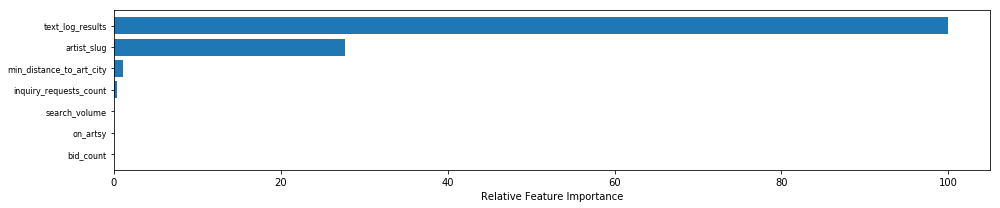

In [192]:
feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Decision Tree Regression Exploration

In [193]:
from sklearn.tree import DecisionTreeClassifier

# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', DecisionTreeClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: dec_scaled
dec_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a Decision Tree classifier to the unscaled data
dec_unscaled = DecisionTreeClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(dec_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(dec_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.5284552845528455
Accuracy without Scaling: 0.5284552845528455


In [196]:
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


# Setup the hyperparameter grid
param_dist = {"max_depth": [3,5,10,20,50,100],
              "max_features": [1,3,5,7],
              "min_samples_leaf": [1,3,5,7],
              "criterion": ["gini", "entropy"],
              "class_weight": ["balanced"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)    

y_pred = tree_cv.predict(X_test)

print(tree_cv.best_params_)
print(tree_cv.best_score_)
print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 3}
0.985964912281
Classification report for classifier              precision    recall  f1-score   support

          0       0.57      0.43      0.49        65
        100       0.50      0.64      0.56        58

avg / total       0.54      0.53      0.52       123
:

Confusion Matrix for classifier [[28 37]
 [21 37]]:



In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier(class_weight= 'balanced', criterion= 'gini', max_depth= 3, max_features= 7, min_samples_leaf= 3)

# Fit it to the data
tree.fit(X_train, y_train)    

y_pred = tree.predict(X_test)

print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

Classification report for classifier              precision    recall  f1-score   support

          0       0.57      0.43      0.49        65
        100       0.50      0.64      0.56        58

avg / total       0.54      0.53      0.52       123
:

Confusion Matrix for classifier [[28 37]
 [21 37]]:



#### Random Forest Classifier

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


# Setup the hyperparameter grid
param_dist = {"n_estimators": [1,5,10,100,200],
              "max_features": ['auto', 'sqrt', 'log2'],
              "max_depth": [1,5,10,50,100],
              "n_jobs": [-1,1,5,10],
              "class_weight": ["balanced"] }

# Instantiate a Random Forest classifier: tree
forest = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = GridSearchCV(forest, param_dist, cv=5)

# Fit it to the data
forest_cv.fit(X_train, y_train)

y_pred = forest_cv.predict(X_test)

print(forest_cv.best_params_)
print(forest_cv.best_score_)

print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200, 'n_jobs': 1}
0.969801980198
Classification report for classifier              precision    recall  f1-score   support

          0       0.82      0.58      0.68        96
        100       0.95      0.98      0.97       770

avg / total       0.94      0.94      0.94       866
:

Confusion Matrix for classifier [[ 56  40]
 [ 12 758]]:



In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

forest = RandomForestClassifier(class_weight='balanced', max_depth= 5, max_features= 'auto', n_estimators= 200, n_jobs= 1)

# Fit it to the data
forest.fit(X_train, y_train)

#can change to predict_proba to get the probabilities
y_pred = forest.predict(X_test)

print("Non CV Forest")
print("Classification report for classifier %s:\n"
      % classification_report(y_test, y_pred))
print("Confusion Matrix for classifier %s:\n"
      % confusion_matrix(y_test, y_pred))

Non CV Forest
Classification report for classifier              precision    recall  f1-score   support

          0       0.57      0.43      0.49        65
        100       0.50      0.64      0.56        58

avg / total       0.54      0.53      0.52       123
:

Confusion Matrix for classifier [[28 37]
 [21 37]]:



/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


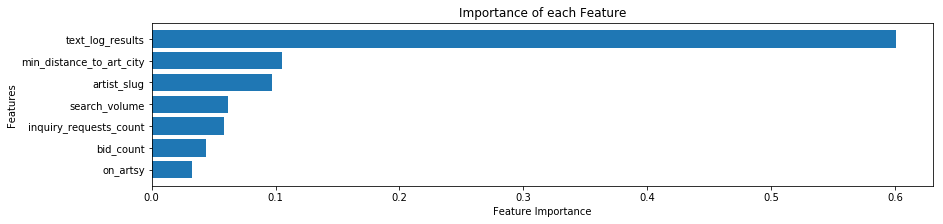

In [199]:
forest.fit(X,y)

imp = forest.feature_importances_
names = X.columns

imp, names = zip(*sorted(zip(imp,names)))

plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Importance of each Feature')
plt.show()

In [ ]:
#http://bigdata-madesimple.com/dealing-with-unbalanced-class-svm-random-forest-and-decision-tree-in-python/

#### Undersample

In [ ]:
df_open_with_many_text_not_on_artsy_undersample = pd.concat([df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 0],
                                                             df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 100].head(204)])

df_open_with_many_features_undersample = pd.concat([df_open_with_many_features[df_open_with_many_features.gallery_tier == 0], 
                                                    df_open_with_many_features[df_open_with_many_features.gallery_tier == 100].head(240)])df_open_with_many_text_not_on_artsy_undersample = pd.concat([df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 0],
                                                             df_open_with_many_text_not_on_artsy[df_open_with_many_text_not_on_artsy.gallery_tier == 100].head(204)])

df_open_with_many_features_undersample = pd.concat([df_open_with_many_features[df_open_with_many_features.gallery_tier == 0], 
                                                    df_open_with_many_features[df_open_with_many_features.gallery_tier == 100].head(240)])

### Notes

Features: Artists on Artsy, Artists Inquiries, Artists Bids, Fairs Participated In, Location, Google Search Score for Artist Name 
Optional: Structured data from website scrape (looking for keywords such Fair, Artists, Exhibitions, Current Exhibition, Past Exhibitions, Represented, Works Available, Services (negative), Submissions (negative) ) 

Take a list of orgs in bearden that have been tiered and have scraped artists. Score those galleries both computationally and by hand, and compare.

Another potential todo: Score a group of artsy partners, observe the distribution of scores-- giving a us a cutoff.

Final step, score the whole list of scraped artist galleries in bearden and see how much of distribution falls above cutoff giving a sense of TAM.

Heuristic models, combine linearly, set coefficients. once have heuristic model can compare to other models
eg. inquiries more important than fairs by 5x
still need pos and neg

will have to deal with biased positives
could normalize by amount of time been on the platform

pos = sub with artist roster
neg = tier 5 with artist roster


Features: Artists on Artsy, Artists Inquiries, Artists Bids, Fairs Participated In, Location, Google Search Score for Artist Name 
Optional: Structured data from website scrape (looking for keywords such Fair, Artists, Exhibitions, Current Exhibition, Past Exhibitions, Represented, Works Available, Services (negative), Submissions (negative) ) 

Other information from website beyond keywords: don't even know 

---------

artists_table = on_artsy, artist_inquries_count, artist_bid_count, google_search_score  
org_table = website, bearden_id, partner_id, location  
org_fairs = website, fair_name, fair_tier  

---------

Take a list of orgs in bearden that have been tiered and have scraped artists. Score those galleries both computationally and by hand, and compare.

Another potential todo: Score a group of artsy partners, observe the distribution of scores-- giving a us a cutoff.

Final step, score the whole list of scraped artist galleries in bearden and see how much of distribution falls above cutoff giving a sense of TAM.

---------

Could be interesting to look at galleries that we have only tier but not artist roster.

---------

if you have thousands of human scored galleries
you might want to see how many of those have, say, three or more of the features you're looking to use.

if you have a few hundred or more you could do a logistic regression on those scores
like that you don't have to worry about classes, positives or negatives, as long as you have a good range of scores in there.

that regression will give you a basic sense of the importance of each of those features in determining the score
as you can reason about the model by just looking at the coefficients it outputs for each feature

it would be good to try and leverage those scores if we have some faith in their consistency



**notes from meeting 11/30**

- *Decision Tree to small, Change to RandomForest Classifier*
- Normalize for how long artist has been on the platform maybe?
- *pass in class weights for logreg*
- *translate tier into #'s*
- *redundency between Impressions and Search Volume, remove one*
- include target in correlation and scatter matrix (new type of matrix)
    - Pair wise plots
- *Use either region or distance from art center *
- Look into how well artist slug match works, otherwise use Artsy Artist Name Match API
- Too much class imbalance
    - ie only predicting certain tiers
    - class weights might help
        - not all tiers are equal

 